# Random Forests Training

Example file showing random forest implementation for our data set

## Classifier training and testing

In [2]:
import bisect
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score, f1_score, matthews_corrcoef, roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import KFold
from sklearn.utils import shuffle
from sklearn import preprocessing

import immas
from immas import MammogramImage
from immas import get_img_features
from immas.basic_functions import show_image_plt
from immas import get_dataset_features

%matplotlib inline

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Helper functions

In [3]:
def line(x_coords, y_coords):
    """
    Given a pair of coordinates (x1,y2), (x2,y2), define the line equation. Note that this is the entire line vs. t
    the line segment.

    Parameters
    ----------
    x_coords: Numpy array of 2 points corresponding to x1,x2
    x_coords: Numpy array of 2 points corresponding to y1,y2

    Returns
    -------
    (Gradient, intercept) tuple pair
    """    
    if (x_coords.shape[0] < 2) or (y_coords.shape[0] < 2):
        raise ValueError('At least 2 points are needed to compute'
                         ' area under curve, but x.shape = %s' % p1.shape)
    if ((x_coords[0]-x_coords[1]) == 0):
        raise ValueError("gradient is infinity")
    gradient = (y_coords[0]-y_coords[1])/(x_coords[0]-x_coords[1])
    intercept = y_coords[0] - gradient*1.0*x_coords[0]
    return (gradient, intercept)

def x_val_line_intercept(gradient, intercept, x_val):
    """
    Given a x=X_val vertical line, what is the intersection point of that line with the 
    line defined by the gradient and intercept. Note: This can be further improved by using line
    segments.

    Parameters
    ----------
    gradient
    intercept

    Returns
    -------
    (x_val, y) corresponding to the intercepted point. Note that this will always return a result.
    There is no check for whether the x_val is within the bounds of the line segment.
    """    
    y = gradient*x_val + intercept
    return (x_val, y)

def get_fpr_tpr_for_thresh(fpr, tpr, thresh):
    """
    Derive the partial ROC curve to the point based on the fpr threshold.

    Parameters
    ----------
    fpr: Numpy array of the sorted FPR points that represent the entirety of the ROC.
    tpr: Numpy array of the sorted TPR points that represent the entirety of the ROC.
    thresh: The threshold based on the FPR to extract the partial ROC based to that value of the threshold.

    Returns
    -------
    thresh_fpr: The FPR points that represent the partial ROC to the point of the fpr threshold.
    thresh_tpr: The TPR points that represent the partial ROC to the point of the fpr threshold
    """    
    p = bisect.bisect_left(fpr, thresh)
    thresh_fpr = fpr[:p+1].copy()
    thresh_tpr = tpr[:p+1].copy()
    g, i = line(fpr[p-1:p+1], tpr[p-1:p+1])
    new_point = x_val_line_intercept(g, i, thresh)
    thresh_fpr[p] = new_point[0]
    thresh_tpr[p] = new_point[1]
    return thresh_fpr, thresh_tpr


def partial_auc_scorer(fpr, tpr, decile=1):
    """
    Derive the AUC based of the partial ROC curve from FPR=0 to FPR=decile threshold.

    Parameters
    ----------
    y_actual: numpy array of the actual labels.
    y_pred: Numpy array of The predicted probability scores.
    decile: The threshold based on the FPR to extract the partial ROC based to that value of the threshold.

    Returns
    -------
    AUC of the partial ROC. A value that ranges from 0 to 1.
    """        
    fpr_thresh, tpr_thresh = get_fpr_tpr_for_thresh(fpr, tpr, decile)
    return auc(fpr_thresh, tpr_thresh)

## Import and normalize data

In [38]:
NUMBER_OF_IMGS = 410
NUMBER_OF_MASSES = 107
test_set_perc = 0.5
# Loading of data and splitting in groups according to images
# Regions of the same image will stay in the same Pandas Dataframe in the end (dataset_df1 or dataset_df2)

# without lbp
file_path = "feature-tables/train-data_1527086478.csv"
# with lbp
#file_path = "feature-tables/train-data_1527093743.csv"

data = pd.read_csv(file_path, index_col=0)
data_per_imgfile = list(data['img_name'].unique())
np.random.shuffle(data_per_imgfile)
test_set_len = int(test_set_perc * len(data_per_imgfile))
print(f"Number of images in the test set {test_set_len}")

train_imgs = data_per_imgfile[test_set_len:]
test_imgs = data_per_imgfile[:test_set_len]
print(f"Number of images in the train set {len(train_imgs)}")

# sampling of the original data set according to images in train/test subsets
data_train = data[data["img_name"].isin(train_imgs)]
data_test = data[data["img_name"].isin(test_imgs)]
print(f"Number of train regions {len(data_train)}")
print(f"Number of test regions {len(data_test)}")


# average number of ROIs per image
# we need to do simple averaging since mass images have fprs as well
reg_per_img = len(data)/(NUMBER_OF_IMGS)
print(f"Regions per image {reg_per_img}")

data_train.head()

Number of images in the test set 205
Number of images in the train set 205
Number of train regions 3120
Number of test regions 3256
Regions per image 15.551219512195122


,perimeter,area,circularity,ac,shape_factor,mean NRL,SD NRL,Ratio SD NRL and mean RL,entropy NRL,NCPS,...,contrast,uniformity,homogeneity,energy,dissimilarity,gradient mean,gradient SD,gradient skewness,class_id,img_name
56,9587.079418,297266.5,24.604629,12081.730768,309.190883,0.590956,0.187331,0.000558,7.242881,0.000433,...,269.418552,0.370690,0.630531,0.608843,8.371314,37791.506766,30836.864641,-0.331781,-1.0,50993922_de5e8d61e501a71b_MG_R_ML_ANON
57,2247.345233,38256.5,10.505688,3641.503633,132.018365,0.500722,0.190529,0.001784,5.738154,0.004090,...,270.815268,0.375520,0.634973,0.612797,8.345418,35079.149254,31108.594185,-0.165264,-1.0,50993922_de5e8d61e501a71b_MG_R_ML_ANON
58,1292.551296,28414.5,4.678921,6072.874771,58.797053,0.537527,0.181179,0.002043,5.164260,0.003450,...,341.167077,0.250413,0.528077,0.500413,10.675856,31413.510753,32075.129927,0.085952,-1.0,50993922_de5e8d61e501a71b_MG_R_ML_ANON
59,1189.279218,22657.0,4.967700,4560.862856,62.425964,0.489515,0.175056,0.002110,5.181664,0.003984,...,279.454386,0.364483,0.625580,0.603724,8.609116,29695.920635,31258.470842,0.202474,-1.0,50993922_de5e8d61e501a71b_MG_R_ML_ANON
60,1198.007140,22561.5,5.062220,4456.839474,63.613727,0.590272,0.194134,0.002486,5.239305,0.002399,...,398.631234,0.182089,0.459809,0.426719,12.317373,31074.285000,30076.135970,0.091289,-1.0,50993922_de5e8d61e501a71b_MG_R_ML_ANON


In [39]:
# Converts from dataframe to numpy array
# Change here (or copy the code) if you want to select only some of the features to the array
# (only texture features, only geomatrical features...)

# Conversion from pandas dataframe to numpy array
# Keeps all the features from the original csv file
feature_train = data_train.drop(['class_id','img_name'], axis=1)
target_train  = data_train['class_id']
x_train = feature_train.as_matrix()
y_train = target_train.as_matrix()

feature_test = data_test.drop(['class_id','img_name'], axis=1)
target_test  = data_test['class_id']
x_test = feature_test.as_matrix()
y_test = target_test.as_matrix()

# Shuflles the datasets and creates one variable with labels for all the samples
x_train, y_train = shuffle(x_train, y_train, random_state=None)
x_test, y_test = shuffle(x_test, y_test, random_state=None)
all_data = np.vstack((x_train, x_test))
all_labels = np.concatenate((y_test, y_train),axis=0)

# Data standardization for each dataset (two methods)
x_train = preprocessing.StandardScaler().fit_transform(x_train)
x_test = preprocessing.StandardScaler().fit_transform(x_test)
all_data = preprocessing.StandardScaler().fit_transform(all_data)
#dataset01_data = preprocessing.robust_scale(dataset01_data)fit_transform
#dataset02_data = preprocessing.robust_scale(dataset02_data)

print(y_train.shape)
print(y_test.shape)


(3120,)
(3256,)


In [32]:
# Fit and tune the algorithm


clf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', oob_score=True)

# Choose some parameter combinations to try
# f1_score, matthews_corrcoef
parameters = {'n_estimators': [6, 9, 35, 75, 101, 300, 500, 700], 
              'max_features': ['log2', 'sqrt', 4],
              'criterion': ['entropy', 'gini'],
              'max_depth': [5, 10, 16],
              'min_samples_split': [3, 5, 8, 10],
              'min_samples_leaf': [1, 5, 8, 30, 50, 70]
             }

# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(matthews_corrcoef)#f1_score)

# Run the grid search
grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer, cv=2, verbose=3, return_train_score=False)
grid_obj = grid_obj.fit(all_data, all_labels)

# # Set the clf to the best combination of parameters
clf = grid_obj.best_estimator_


# Fit the best algorithm to the data. 
clf.fit(x_train, y_train)

Fitting 2 folds for each of 3456 candidates, totalling 6912 fits
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=6, score=0.03040695090257859, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=6, score=-0.003880089680427269, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=9, score=-0.008219702941304762, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=9, score=0.02318808447155744, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=35, score=0.007594888773109643, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=35, score=0.005462976154348693, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=75 
[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=75, score=0.003569670441666959, total=   0.8s
[CV] criterion=entropy, max_dept

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=6, score=-0.020583904413386207, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=6, score=0.018358712654487665, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=9, score=-0.010949970680490551, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=9, score=-0.002964642060118088, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=35, score=0.004680333798164519, total=   0.4s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=35, score=0.006283537346746207, total=   0.4s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=75 
[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=75, score=0.003931983896632234, total=   0.7s
[CV] criterion=entropy, max_de

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=6, score=-0.014576172411890837, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=6, score=0.027693193807894968, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=9, score=-0.023984782485542325, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=9, score=0.018836086721766496, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=35, score=0.004680333798164519, total=   0.4s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=35, score=0.006709328239353262, total=   0.4s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=75 
[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=75, score=0.003569670441666959, total=   0.6s
[CV] criterion=entropy, max_dep

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=6, score=0.016652236991433266, total=   0.4s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=6, score=0.03453491724062752, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=9, score=0.007566247284588151, total=   0.4s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=9, score=-0.023521390006896216, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=35, score=0.006283537346746207, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=35, score=-0.014979269469910676, total=   0.7s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=75 
[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=75, score=0.004680333798164519, total=   1.3s
[CV] criterion=entropy

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=6, score=0.012195685573086342, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=6, score=0.013874969725073062, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=9, score=0.020821031031551494, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=9, score=-0.011459220603253075, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=35, score=0.002866998725146108, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=35, score=0.004680333798164519, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=75 
[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=75, score=0.003569670441666959, total=   0.9s
[CV] criterion=entropy, max_de

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=6, score=-0.01646638933471498, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=6, score=0.015610046752166339, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=9, score=-0.0021985909090529105, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=9, score=0.011776839732777912, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=35, score=0.006709328239353262, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=35, score=-0.013881918152206702, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=75 
[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=75, score=0.005868268647855689, total=   0.6s
[CV] criterion=entropy, max_de

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=6, score=0.05032068042222877, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=6, score=0.014800521298239562, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=9, score=0.0006518195419684249, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=9, score=-0.00953492478254465, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=35, score=0.0050671542332340405, total=   0.4s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=35, score=0.004680333798164519, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=75 
[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=75, score=0.003931983896632234, total=   0.7s
[CV] criterion=entropy, max_de

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=6, score=0.008051916488073876, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=6, score=0.009965737134543533, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=9, score=0.024084109320667003, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=9, score=-0.006402556553935739, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=35, score=0.009521920035667908, total=   0.4s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=35, score=0.004680333798164519, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=75 
[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=75, score=0.004680333798164519, total=   0.6s
[CV] criterion=entropy,

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=3, n_estimators=6, score=-0.0143673706628161, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=3, n_estimators=6, score=-0.021881649009154652, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=3, n_estimators=9, score=-0.022690666077512314, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=3, n_estimators=9, score=0.04265417909343648, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=3, n_estimators=35, score=0.005868268647855689, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=3, n_estimators=35, score=0.005868268647855689, total=   0.4s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=3, n_estimators=75 
[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=3, n_estimators=75, score=0.0050671542332340405, total=   0.5s
[CV] criterion=entropy, max_dep

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=6, score=0.023325929970780365, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=6, score=-0.0023166626348144954, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=9, score=0.009247190243355201, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=9, score=-0.004420027940172736, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=35, score=0.005462976154348693, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=35, score=-0.015500278570419813, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=75 
[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=75, score=0.004302078933892102, total=   0.8s
[CV] criterion=entropy, max_d

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=6, score=0.013686750384132132, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=6, score=0.009582218808290298, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=9, score=-0.004871170870864274, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=9, score=0.017892813552052945, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=35, score=0.005462976154348693, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=35, score=0.004302078933892102, total=   0.4s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=75 
[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=75, score=0.004302078933892102, total=   0.5s
[CV] criterion=entropy, max_dep

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=6, score=-0.004957679045885222, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=6, score=-0.0071743582183697386, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=9, score=0.00845286314090717, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=9, score=-0.014459256069602645, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=35, score=-0.01532846838602545, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=35, score=0.005868268647855689, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=75 
[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=75, score=0.0050671542332340405, total=   0.6s
[CV] criterion=entropy

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=3, n_estimators=6, score=0.0018266546723055923, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=3, n_estimators=6, score=0.00823883125159477, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=3, n_estimators=9, score=-0.012284598975012277, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=3, n_estimators=9, score=-0.026618521231165544, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=3, n_estimators=35, score=0.006709328239353262, total=   0.4s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=3, n_estimators=35, score=0.009018645449215369, total=   0.4s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=3, n_estimators=75 
[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=3, n_estimators=75, score=0.003569670441666959, total=   0.8s
[CV] criterion=entropy,

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=5, n_estimators=6, score=-0.009933083751629268, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=5, n_estimators=6, score=-0.015734650047426208, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=5, n_estimators=9, score=0.0006518195419684249, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=5, n_estimators=9, score=0.0021597554069597777, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=5, n_estimators=35, score=0.011131742540519473, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=5, n_estimators=35, score=0.006283537346746207, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=5, n_estimators=75 
[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=5, n_estimators=75, score=0.005462976154348693, total=   0.7s
[CV] criterion=entropy,

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=8, n_estimators=6, score=0.010267201874039383, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=8, n_estimators=6, score=-0.0037774951620154263, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=8, n_estimators=9, score=-0.007140791226776317, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=8, n_estimators=9, score=0.03208199342600093, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=8, n_estimators=35, score=0.005868268647855689, total=   0.4s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=8, n_estimators=35, score=0.005462976154348693, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=8, n_estimators=75 
[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=8, n_estimators=75, score=0.00321478543666149, total=   0.5s
[CV] criterion=entropy, ma

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=6, score=0.019509263344702894, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=6, score=-0.010642869352550138, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=9, score=0.034924443450667315, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=9, score=-0.01109860424506587, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=35, score=0.005462976154348693, total=   0.4s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=35, score=0.006709328239353262, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=75 
[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=75, score=0.003569670441666959, total=   0.6s
[CV] criterion=en

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=3, n_estimators=6, score=0.018279590953563147, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=3, n_estimators=6, score=-0.00879494065874964, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=3, n_estimators=9, score=-0.03259721538226127, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=3, n_estimators=9, score=0.0025303706868647774, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=3, n_estimators=35, score=0.002866998725146108, total=   0.4s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=3, n_estimators=35, score=0.005462976154348693, total=   0.4s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=3, n_estimators=75 
[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=3, n_estimators=75, score=0.005462976154348693, total=   0.5s
[CV] criterion=entropy,

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=5, n_estimators=6, score=0.01740013762559018, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=5, n_estimators=6, score=0.016810398771999857, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=5, n_estimators=9, score=-0.01129068373170424, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=5, n_estimators=9, score=0.0028909293370399337, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=5, n_estimators=35, score=-0.014070461018367142, total=   0.4s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=5, n_estimators=35, score=0.025030978740452448, total=   0.4s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=5, n_estimators=75 
[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=5, n_estimators=75, score=0.006283537346746207, total=   0.6s
[CV] criterion=entropy

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=8, n_estimators=6, score=-0.0063577798269478895, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=8, n_estimators=6, score=0.024648157266429778, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=8, n_estimators=9, score=-0.0053205573025859034, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=8, n_estimators=9, score=-0.011626574893273183, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=8, n_estimators=35, score=0.004680333798164519, total=   0.4s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=8, n_estimators=35, score=0.005462976154348693, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=8, n_estimators=75 
[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=8, n_estimators=75, score=0.004680333798164519, total=   0.6s
[CV] criterion=entropy,

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=10, n_estimators=6, score=-0.011155465523246715, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=10, n_estimators=6, score=0.016006123271218246, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=10, n_estimators=9, score=-0.018208531370114335, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=10, n_estimators=9, score=0.030013036719885543, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=10, n_estimators=35, score=0.0050671542332340405, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=10, n_estimators=35, score=0.007146231978776819, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=10, n_estimators=75 
[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=10, n_estimators=75, score=0.003931983896632234, total=   0.6s
[CV] criterion=e

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=3, n_estimators=6, score=-0.008182772089506274, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=3, n_estimators=6, score=-0.004279361368466857, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=3, n_estimators=9, score=0.007269386739927421, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=3, n_estimators=9, score=0.0026786996208299856, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=3, n_estimators=35, score=0.00321478543666149, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=3, n_estimators=35, score=0.004680333798164519, total=   0.4s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=3, n_estimators=75 
[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=3, n_estimators=75, score=0.004680333798164519, total=   0.6s
[CV] criterion=entropy, 

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=5, n_estimators=6, score=-0.013816897783789799, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=5, n_estimators=6, score=-0.01850762183950951, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=5, n_estimators=9, score=-0.0026378290528097505, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=5, n_estimators=9, score=-0.00685440629048465, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=5, n_estimators=35, score=-0.013301005363779924, total=   0.4s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=5, n_estimators=35, score=-0.014440506008064971, total=   0.4s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=5, n_estimators=75 
[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=5, n_estimators=75, score=0.006709328239353262, total=   0.5s
[CV] criterion=entropy

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=8, n_estimators=6, score=-0.011787241232927279, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=8, n_estimators=6, score=0.005659562130560555, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=8, n_estimators=9, score=0.008805386545644412, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=8, n_estimators=9, score=0.006056121583595067, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=8, n_estimators=35, score=0.007146231978776819, total=   0.4s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=8, n_estimators=35, score=0.0050671542332340405, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=8, n_estimators=75 
[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=8, n_estimators=75, score=0.004680333798164519, total=   0.7s
[CV] criterion=entropy,

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=10, n_estimators=6, score=-0.02111980845694745, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=10, n_estimators=6, score=-0.003651225369022195, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=10, n_estimators=9, score=0.019373680939022628, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=10, n_estimators=9, score=-0.012766723714334982, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=10, n_estimators=35, score=0.007146231978776819, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=10, n_estimators=35, score=-0.01480174892051572, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=10, n_estimators=75 
[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=10, n_estimators=75, score=-0.015154820029678258, total=   0.6s
[CV] criterion=

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=6, score=-0.005641656034705142, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=6, score=0.001747255581828399, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=9, score=0.02648850627788384, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=9, score=0.028160207951991346, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=35, score=0.0050671542332340405, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=35, score=0.0050671542332340405, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=75 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=75, score=0.003569670441666959, total=   0.8s
[CV] criterion=entropy, max_d

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=6, score=0.023681948785854834, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=6, score=-0.0016097513186866322, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=9, score=0.035254232897690065, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=9, score=0.01791374130580498, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=35, score=0.006283537346746207, total=   0.7s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=35, score=0.005868268647855689, total=   0.6s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=75 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=75, score=0.003931983896632234, total=   0.8s
[CV] criterion=entropy, max_dept

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=6, score=-0.01475537710854943, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=6, score=-0.021415664192758543, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=9, score=-0.0053205573025859034, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=9, score=-0.003458920711340077, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=35, score=0.005462976154348693, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=35, score=0.004680333798164519, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=75 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=75, score=0.00321478543666149, total=   0.8s
[CV] criterion=entropy, max_dep

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=6, score=0.055201073514882903, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=6, score=0.03480839438600127, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=9, score=-0.0019362429776046265, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=9, score=-0.011957823474779462, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=35, score=0.004680333798164519, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=35, score=0.004680333798164519, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=75 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=75, score=0.002866998725146108, total=   0.9s
[CV] criterion=entropy,

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=6, score=0.023379534423682798, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=6, score=0.005251181612113347, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=9, score=0.0025260012096343823, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=9, score=0.006282259686429474, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=35, score=0.006709328239353262, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=35, score=0.006283537346746207, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=75 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=75, score=0.00321478543666149, total=   0.8s
[CV] criterion=entropy, max_dept

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=6, score=-0.004241186369846325, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=6, score=0.005251181612113347, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=9, score=-0.018768633855358267, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=9, score=0.008067138834655322, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=35, score=0.0050671542332340405, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=35, score=0.004302078933892102, total=   0.7s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=75 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=75, score=0.003569670441666959, total=   0.8s
[CV] criterion=entropy, max_de

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=6, score=-0.009182355826871855, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=6, score=0.019811369929161226, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=9, score=0.008067138834655322, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=9, score=0.0015409337291736461, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=35, score=0.005868268647855689, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=35, score=0.00321478543666149, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=75 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=75, score=0.004302078933892102, total=   0.9s
[CV] criterion=entropy, max_dep

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=6, score=-0.009167010955124412, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=6, score=-0.003880089680427269, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=9, score=0.002658095609550027, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=9, score=0.005865764484927809, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=35, score=0.006283537346746207, total=   0.4s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=35, score=0.005462976154348693, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=75 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=75, score=0.004680333798164519, total=   0.8s
[CV] criterion=entropy, 

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, n_estimators=6, score=0.00071773691012767, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, n_estimators=6, score=0.045403998507809046, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, n_estimators=9, score=-0.002956565267952162, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, n_estimators=9, score=-0.007829012519059864, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, n_estimators=35, score=0.004302078933892102, total=   0.6s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, n_estimators=35, score=0.006709328239353262, total=   0.6s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, n_estimators=75 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, n_estimators=75, score=0.004302078933892102, total=   0.9s
[CV] criterion=entropy, max_de

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=6, score=-0.005470266365105158, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=6, score=-0.021832264136075072, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=9, score=-0.009896943256272757, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=9, score=0.017585126644192796, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=35, score=-0.014622186525312645, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=35, score=0.005868268647855689, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=75 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=75, score=0.003931983896632234, total=   0.8s
[CV] criterion=entropy, max_de

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=6, score=-0.007624198588515731, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=6, score=-0.011525082140886137, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=9, score=0.0009133037679348829, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=9, score=0.010789166576435404, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=35, score=0.004680333798164519, total=   0.6s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=35, score=0.003931983896632234, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=75 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=75, score=0.003569670441666959, total=   0.8s
[CV] criterion=entropy, max_dep

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=6, score=0.01548332696105051, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=6, score=-0.0023874032103379512, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=9, score=0.003363051328857855, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=9, score=0.005865764484927809, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=35, score=0.0050671542332340405, total=   0.6s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=35, score=0.005868268647855689, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=75 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=75, score=0.004302078933892102, total=   1.0s
[CV] criterion=entropy,

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=3, n_estimators=6, score=0.0042527075173288955, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=3, n_estimators=6, score=-0.005881026231507051, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=3, n_estimators=9, score=-0.008412450796292253, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=3, n_estimators=9, score=0.011033048916716729, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=3, n_estimators=35, score=-0.014979269469910676, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=3, n_estimators=35, score=0.003569670441666959, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=3, n_estimators=75 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=3, n_estimators=75, score=0.006283537346746207, total=   0.8s
[CV] criterion=entropy,

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=5, n_estimators=6, score=0.018109641398463865, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=5, n_estimators=6, score=0.0032845210590589867, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=5, n_estimators=9, score=-0.01007581780212655, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=5, n_estimators=9, score=-0.004241186369846325, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=5, n_estimators=35, score=0.004680333798164519, total=   0.6s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=5, n_estimators=35, score=0.003569670441666959, total=   0.7s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=5, n_estimators=75 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=5, n_estimators=75, score=0.004302078933892102, total=   1.1s
[CV] criterion=entropy,

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=8, n_estimators=6, score=-0.028158393175321424, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=8, n_estimators=6, score=0.00019273691046348514, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=8, n_estimators=9, score=0.019811369929161226, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=8, n_estimators=9, score=-0.01859614440727426, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=8, n_estimators=35, score=-0.01480174892051572, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=8, n_estimators=35, score=0.006283537346746207, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=8, n_estimators=75 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=8, n_estimators=75, score=0.00321478543666149, total=   0.8s
[CV] criterion=entropy, m

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=10, n_estimators=6, score=-0.01007581780212655, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=10, n_estimators=6, score=-0.0016652713301657232, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=10, n_estimators=9, score=0.018805379472154646, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=10, n_estimators=9, score=-0.025330831422159774, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=10, n_estimators=35, score=0.005462976154348693, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=10, n_estimators=35, score=0.003569670441666959, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=10, n_estimators=75 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=10, n_estimators=75, score=0.005462976154348693, total=   0.8s
[CV] criterion=e

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=3, n_estimators=6, score=0.006704388589089784, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=3, n_estimators=6, score=0.03882931321663338, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=3, n_estimators=9, score=0.0008672739940668789, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=3, n_estimators=9, score=0.004583247626241808, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=3, n_estimators=35, score=0.004302078933892102, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=3, n_estimators=35, score=0.006283537346746207, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=3, n_estimators=75 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=3, n_estimators=75, score=0.004302078933892102, total=   0.8s
[CV] criterion=entropy, 

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=5, n_estimators=6, score=-0.01290825938243473, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=5, n_estimators=6, score=-0.01235440217536421, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=5, n_estimators=9, score=-0.0059765555262397485, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=5, n_estimators=9, score=-0.022930705538788496, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=5, n_estimators=35, score=0.004302078933892102, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=5, n_estimators=35, score=0.005462976154348693, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=5, n_estimators=75 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=5, n_estimators=75, score=0.003569670441666959, total=   0.8s
[CV] criterion=entropy,

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=8, n_estimators=6, score=-0.00746392250543632, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=8, n_estimators=6, score=0.015026630758488056, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=8, n_estimators=9, score=-0.015193419773924233, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=8, n_estimators=9, score=-0.0023874032103379512, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=8, n_estimators=35, score=0.005462976154348693, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=8, n_estimators=35, score=0.007146231978776819, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=8, n_estimators=75 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=8, n_estimators=75, score=0.0050671542332340405, total=   0.8s
[CV] criterion=entrop

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=10, n_estimators=6, score=-0.01699655090366191, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=10, n_estimators=6, score=0.014254078550807073, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=10, n_estimators=9, score=-0.010949970680490551, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=10, n_estimators=9, score=-0.009351720485499027, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=10, n_estimators=35, score=0.007146231978776819, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=10, n_estimators=35, score=0.003569670441666959, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=10, n_estimators=75 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=10, n_estimators=75, score=0.003931983896632234, total=   0.8s
[CV] criterion=e

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=3, n_estimators=6, score=-0.023574270947214378, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=3, n_estimators=6, score=-0.005404167797276684, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=3, n_estimators=9, score=0.023770317205339443, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=3, n_estimators=9, score=0.005088374490497811, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=3, n_estimators=35, score=0.026891357325389633, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=3, n_estimators=35, score=-0.014070461018367142, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=3, n_estimators=75 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=3, n_estimators=75, score=0.004302078933892102, total=   0.8s
[CV] criterion=entropy,

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=5, n_estimators=6, score=-0.0263320336214601, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=5, n_estimators=6, score=2.851592125547311e-05, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=5, n_estimators=9, score=-0.017947266165456038, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=5, n_estimators=9, score=0.03284407537616508, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=5, n_estimators=35, score=0.0050671542332340405, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=5, n_estimators=35, score=0.007594888773109643, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=5, n_estimators=75 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=5, n_estimators=75, score=0.006283537346746207, total=   0.8s
[CV] criterion=entropy, 

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=8, n_estimators=6, score=-0.016017221096273418, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=8, n_estimators=6, score=0.0016115835263005472, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=8, n_estimators=9, score=0.006917618346497909, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=8, n_estimators=9, score=0.034924443450667315, total=   0.4s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=8, n_estimators=35, score=0.008055993951728381, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=8, n_estimators=35, score=0.007594888773109643, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=8, n_estimators=75 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=8, n_estimators=75, score=0.003931983896632234, total=   0.8s
[CV] criterion=entropy, 

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=6, score=-0.021997134400476726, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=6, score=-0.013265230161247867, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=9, score=0.00019273691046348514, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=9, score=0.025580863301332305, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=35, score=0.0025260012096343823, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=35, score=0.003931983896632234, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=75 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=75, score=0.004680333798164519, total=   0.8s
[CV] criterion=e

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=3, n_estimators=6, score=-0.012361837304182385, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=3, n_estimators=6, score=-0.010081113240697484, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=3, n_estimators=9, score=0.005865757125617137, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=3, n_estimators=9, score=-0.009896943256272757, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=3, n_estimators=35, score=0.006283537346746207, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=3, n_estimators=35, score=-0.01600526987390895, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=3, n_estimators=75 
[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=3, n_estimators=75, score=0.005462976154348693, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_features=4

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=5, n_estimators=6, score=-0.013927660617798794, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=5, n_estimators=6, score=0.008409924476305298, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=5, n_estimators=9, score=-0.007783630634749162, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=5, n_estimators=9, score=-0.02875525646410748, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=5, n_estimators=35, score=-0.014256626282724798, total=   0.4s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=5, n_estimators=35, score=0.0085303043214629, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=5, n_estimators=75 
[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=5, n_estimators=75, score=0.003931983896632234, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_features=4, 

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=8, n_estimators=6, score=-0.017663845962570555, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=8, n_estimators=6, score=-0.0007257725286804774, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=8, n_estimators=9, score=0.00019273691046348514, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=8, n_estimators=9, score=0.0058798954546232665, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=8, n_estimators=35, score=0.0085303043214629, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=8, n_estimators=35, score=0.005462976154348693, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=8, n_estimators=75 
[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=8, n_estimators=75, score=0.004680333798164519, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_features=4, 

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=10, n_estimators=6, score=-0.01562439532744104, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=10, n_estimators=6, score=-0.021881649009154652, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=10, n_estimators=9, score=-0.002956565267952162, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=10, n_estimators=9, score=0.0024273537724501335, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=10, n_estimators=35, score=0.005868268647855689, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=10, n_estimators=35, score=0.0050671542332340405, total=   0.4s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=10, n_estimators=75 
[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=10, n_estimators=75, score=0.006709328239353262, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_fe

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=6, score=-0.008659548716628862, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=6, score=-0.007714111964482917, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=9, score=-0.01112094155289327, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=9, score=0.0010948665820198842, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=35, score=0.006283537346746207, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=35, score=0.003569670441666959, total=   0.4s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=75 
[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=75, score=0.007594888773109643, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_features=4

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=5, n_estimators=6, score=-0.027025681415346565, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=5, n_estimators=6, score=0.002196782624061167, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=5, n_estimators=9, score=0.02178768285082339, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=5, n_estimators=9, score=-0.013043496475950725, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=5, n_estimators=35, score=0.005462976154348693, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=5, n_estimators=35, score=0.007594888773109643, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=5, n_estimators=75 
[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=5, n_estimators=75, score=0.00321478543666149, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_features=4,

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=6, score=-0.0033125965231983133, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=6, score=0.01700307604184426, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=9, score=-0.005124421629111231, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=9, score=-0.025110794254140097, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=35, score=0.005462976154348693, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=35, score=0.00321478543666149, total=   0.4s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=75 
[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=75, score=0.003569670441666959, total=   0.6s
[CV] criterion=entropy, max_depth=5, max_features=4,

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=6, score=0.020874682767441442, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=6, score=-0.0055963009719167765, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=9, score=0.029160480584239628, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=9, score=-0.014754925052872818, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=35, score=0.006283537346746207, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=35, score=0.007594888773109643, total=   0.4s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=75 
[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=75, score=0.005462976154348693, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_fea

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=3, n_estimators=6, score=-0.0033879427252605167, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=3, n_estimators=6, score=0.023320853221653694, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=3, n_estimators=9, score=0.0016115835263005472, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=3, n_estimators=9, score=-0.022681889872925617, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=3, n_estimators=35, score=0.007146231978776819, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=3, n_estimators=35, score=0.007146231978776819, total=   0.4s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=3, n_estimators=75 
[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=3, n_estimators=75, score=0.005868268647855689, total=   0.6s
[CV] criterion=entropy, max_depth=5, max_features=4

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=5, n_estimators=6, score=0.027686129541226106, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=5, n_estimators=6, score=-0.035621409513726214, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=5, n_estimators=9, score=0.008210213696540437, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=5, n_estimators=9, score=-0.00685440629048465, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=5, n_estimators=35, score=0.011131742540519473, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=5, n_estimators=35, score=0.008055993951728381, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=5, n_estimators=75 
[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=5, n_estimators=75, score=0.004680333798164519, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_features=4,

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=8, n_estimators=6, score=0.0032773055384725924, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=8, n_estimators=6, score=0.03012674786705537, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=8, n_estimators=9, score=-0.011787241232927279, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=8, n_estimators=9, score=0.005251181612113347, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=8, n_estimators=35, score=0.006283537346746207, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=8, n_estimators=35, score=0.005462976154348693, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=8, n_estimators=75 
[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=8, n_estimators=75, score=0.004302078933892102, total=   0.6s
[CV] criterion=entropy, max_depth=5, max_features=4,

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=10, n_estimators=6, score=0.027078148773307328, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=10, n_estimators=6, score=-0.0063173439275947575, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=10, n_estimators=9, score=-0.0074311230788045865, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=10, n_estimators=9, score=0.021328462515527023, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=10, n_estimators=35, score=0.005868268647855689, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=10, n_estimators=35, score=0.0085303043214629, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=10, n_estimators=75 
[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=10, n_estimators=75, score=0.004302078933892102, total=   0.6s
[CV] criterion=entropy, max_depth=5, max_featur

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=3, n_estimators=6, score=-0.021230523494751415, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=3, n_estimators=6, score=-0.018029285291437366, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=3, n_estimators=9, score=0.00894672955529732, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=3, n_estimators=9, score=-0.0017511219304466514, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=3, n_estimators=35, score=0.005462976154348693, total=   0.4s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=3, n_estimators=35, score=-0.014070461018367142, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=3, n_estimators=75 
[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=3, n_estimators=75, score=0.006709328239353262, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_f

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=5, n_estimators=6, score=0.012575532986526097, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=5, n_estimators=6, score=-0.022317945900554137, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=5, n_estimators=9, score=-0.0069779119263927184, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=5, n_estimators=9, score=-0.02070404527120444, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=5, n_estimators=35, score=0.003931983896632234, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=5, n_estimators=35, score=-0.013690899342919643, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=5, n_estimators=75 
[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=5, n_estimators=75, score=0.005462976154348693, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_fea

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=8, n_estimators=6, score=0.022502121152579352, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=8, n_estimators=6, score=0.00689342585702665, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=8, n_estimators=9, score=0.005010972496844669, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=8, n_estimators=9, score=-0.008723124252720722, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=8, n_estimators=35, score=0.003931983896632234, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=8, n_estimators=35, score=0.005462976154348693, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=8, n_estimators=75 
[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=8, n_estimators=75, score=0.007146231978776819, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_fea

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=10, n_estimators=6, score=-0.008355179033995509, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=10, n_estimators=6, score=0.045777123396627456, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=10, n_estimators=9, score=0.014399889541863069, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=10, n_estimators=9, score=-0.003143723042214281, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=10, n_estimators=35, score=0.006709328239353262, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=10, n_estimators=35, score=0.004680333798164519, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=10, n_estimators=75 
[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=10, n_estimators=75, score=0.006709328239353262, total=   0.5s
[CV] criterion=entropy, max_depth=5, 

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=3, n_estimators=6, score=-0.002892507062523792, total=   0.4s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=3, n_estimators=6, score=0.012721617167899353, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=3, n_estimators=9, score=0.019404179445616558, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=3, n_estimators=9, score=-0.020942988694600054, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=3, n_estimators=35, score=0.00321478543666149, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=3, n_estimators=35, score=0.004302078933892102, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=3, n_estimators=75 
[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=3, n_estimators=75, score=0.005462976154348693, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_feat

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=5, n_estimators=6, score=-0.009047201253247636, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=5, n_estimators=6, score=0.03370770077175965, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=5, n_estimators=9, score=-0.019566608291136527, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=5, n_estimators=9, score=0.012758626874725013, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=5, n_estimators=35, score=-0.014440506008064971, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=5, n_estimators=35, score=-0.014256626282724798, total=   0.4s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=5, n_estimators=75 
[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=5, n_estimators=75, score=0.006709328239353262, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_fe

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=8, n_estimators=6, score=0.004535106820507753, total=   0.4s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=8, n_estimators=6, score=-0.029859870889539872, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=8, n_estimators=9, score=0.01312731852779678, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=8, n_estimators=9, score=-0.015159207410486254, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=8, n_estimators=35, score=-0.014440506008064971, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=8, n_estimators=35, score=0.008055993951728381, total=   0.4s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=8, n_estimators=75 
[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=8, n_estimators=75, score=0.007146231978776819, total=   0.6s
[CV] criterion=entropy, max_depth=5, max_fe

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=10, n_estimators=6, score=0.012080904026366739, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=10, n_estimators=6, score=0.013879950673008705, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=10, n_estimators=9, score=0.0008524564506411719, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=10, n_estimators=9, score=0.03248471629288444, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=10, n_estimators=35, score=0.006283537346746207, total=   0.4s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=10, n_estimators=35, score=0.0085303043214629, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=10, n_estimators=75 
[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=10, n_estimators=75, score=0.004302078933892102, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=3, n_estimators=6, score=-0.024766299248564074, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=3, n_estimators=6, score=0.04886311079640662, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=3, n_estimators=9, score=-0.0049499354763080945, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=3, n_estimators=9, score=-0.00977551179984731, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=3, n_estimators=35, score=0.005462976154348693, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=3, n_estimators=35, score=0.021198239372939742, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=3, n_estimators=75 
[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=3, n_estimators=75, score=0.007594888773109643, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_feat

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=5, n_estimators=6, score=0.008996214809254202, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=5, n_estimators=6, score=-0.016893575313656883, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=5, n_estimators=9, score=-0.012284598975012277, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=5, n_estimators=9, score=-0.003739293301646509, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=5, n_estimators=35, score=0.005462976154348693, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=5, n_estimators=35, score=0.006709328239353262, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=5, n_estimators=75 
[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=5, n_estimators=75, score=0.005868268647855689, total=   0.6s
[CV] criterion=entropy, max_depth=5, max_fea

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=8, n_estimators=6, score=0.004693401196008969, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=8, n_estimators=6, score=0.03288897957338433, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=8, n_estimators=9, score=-0.015768264668453557, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=8, n_estimators=9, score=-0.014626212272740437, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=8, n_estimators=35, score=0.010041117579518647, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=8, n_estimators=35, score=0.0085303043214629, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=8, n_estimators=75 
[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=8, n_estimators=75, score=0.005868268647855689, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_featu

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=10, n_estimators=6, score=-0.025348202893957113, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=10, n_estimators=6, score=0.03209421764069164, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=10, n_estimators=9, score=-0.02046331046754325, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=10, n_estimators=9, score=-0.01872252939214912, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=10, n_estimators=35, score=-0.014440506008064971, total=   0.4s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=10, n_estimators=35, score=0.007594888773109643, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=10, n_estimators=75 
[CV]  criterion=entropy, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=10, n_estimators=75, score=-0.014440506008064971, total=   0.5s
[CV] criterion=entropy, max_depth=5,

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=6, score=-0.014622186525312645, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=6, score=0.003931983896632234, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=9, score=-0.014256626282724798, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=9, score=0.007594888773109643, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=35, score=0.003931983896632234, total=   0.4s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=35, score=0.003569670441666959, total=   0.4s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=75 
[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=75, score=0.003931983896632234, total=   0.6s
[CV] criterion=entropy, 

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=6, score=0.01791374130580498, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=6, score=-0.01649571709081978, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=9, score=-0.01567031114412341, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=9, score=0.0050671542332340405, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=35, score=0.006283537346746207, total=   0.4s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=35, score=-0.01567031114412341, total=   0.4s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=75 
[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=75, score=0.0025260012096343823, total=   0.8s
[CV] criterion=entropy

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=6, score=0.008055993951728381, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=6, score=0.0085303043214629, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=9, score=-0.015154820029678258, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=9, score=0.006709328239353262, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=35, score=-0.01583862345560276, total=   0.4s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=35, score=0.003931983896632234, total=   0.4s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=75 
[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=75, score=0.0025260012096343823, total=   0.7s
[CV] criterion=entropy,

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=6, score=0.004680333798164519, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=6, score=0.005462976154348693, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=9, score=0.005462976154348693, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=9, score=0.0050671542332340405, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=35, score=-0.015500278570419813, total=   0.4s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=35, score=0.00321478543666149, total=   0.4s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=75 
[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=75, score=0.0025260012096343823, total=   0.6s
[CV] criterion=

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=6, score=0.005462976154348693, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=6, score=0.0085303043214629, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=9, score=0.008055993951728381, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=9, score=0.007594888773109643, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=35, score=0.0025260012096343823, total=   0.4s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=35, score=-0.01567031114412341, total=   0.4s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=75 
[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=75, score=0.002866998725146108, total=   0.8s
[CV] criterion=entropy,

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=6, score=0.007146231978776819, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=6, score=-0.01532846838602545, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=9, score=-0.014979269469910676, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=9, score=0.009521920035667908, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=35, score=0.004302078933892102, total=   0.5s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=35, score=0.002866998725146108, total=   0.4s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=75 
[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=75, score=0.0025260012096343823, total=   0.7s
[CV] criterion=entropy,

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=6, score=0.0050671542332340405, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=6, score=0.0015409337291736461, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=9, score=0.0050671542332340405, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=9, score=0.010577325575081372, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=35, score=0.004302078933892102, total=   0.5s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=35, score=0.003569670441666959, total=   0.4s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=75 
[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=75, score=0.0025260012096343823, total=   0.7s
[CV] criterion=entropy,

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=6, score=-0.013690899342919643, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=6, score=-0.01743786200392441, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=9, score=-0.01480174892051572, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=9, score=-0.014256626282724798, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=35, score=0.004680333798164519, total=   0.4s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=35, score=0.004680333798164519, total=   0.5s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=75 
[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=75, score=0.0025260012096343823, total=   0.8s
[CV] criterion=

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=3, n_estimators=6, score=1.106811325659869e-05, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=3, n_estimators=6, score=-0.014440506008064971, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=3, n_estimators=9, score=-0.014622186525312645, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=3, n_estimators=9, score=-0.013497299355077602, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=3, n_estimators=35, score=0.003569670441666959, total=   0.4s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=3, n_estimators=35, score=0.00321478543666149, total=   0.4s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=3, n_estimators=75 
[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=3, n_estimators=75, score=0.0025260012096343823, total=   0.6s
[CV] criterion=entropy,

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=6, score=-0.01480174892051572, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=6, score=0.002866998725146108, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=9, score=0.005462976154348693, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=9, score=-0.013301005363779924, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=35, score=0.004302078933892102, total=   0.4s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=35, score=0.00321478543666149, total=   0.4s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=75 
[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=75, score=0.002866998725146108, total=   0.6s
[CV] criterion=entropy, 

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=6, score=-0.0005665111379750805, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=6, score=-0.01789160507929178, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=9, score=0.007146231978776819, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=9, score=0.006709328239353262, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=35, score=0.003569670441666959, total=   0.5s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=35, score=0.003931983896632234, total=   0.5s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=75 
[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=75, score=0.002866998725146108, total=   0.7s
[CV] criterion=entropy, 

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=6, score=0.009521920035667908, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=6, score=0.0025260012096343823, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=9, score=0.007146231978776819, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=9, score=-0.015500278570419813, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=35, score=0.003569670441666959, total=   0.4s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=35, score=-0.01532846838602545, total=   0.4s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=75 
[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=75, score=0.0025260012096343823, total=   0.6s
[CV] criterion=

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=3, n_estimators=6, score=-0.004177639061018627, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=3, n_estimators=6, score=0.006941767305653367, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=3, n_estimators=9, score=0.006283537346746207, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=3, n_estimators=9, score=-0.016170302000713576, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=3, n_estimators=35, score=0.006283537346746207, total=   0.4s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=3, n_estimators=35, score=0.004302078933892102, total=   0.4s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=3, n_estimators=75 
[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=3, n_estimators=75, score=0.00321478543666149, total=   0.6s
[CV] criterion=en

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=5, n_estimators=6, score=-0.003458920711340077, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=5, n_estimators=6, score=0.007780890782248978, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=5, n_estimators=9, score=1.106811325659869e-05, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=5, n_estimators=9, score=0.004680333798164519, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=5, n_estimators=35, score=0.004680333798164519, total=   0.5s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=5, n_estimators=35, score=0.005868268647855689, total=   0.4s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=5, n_estimators=75 
[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=5, n_estimators=75, score=0.002866998725146108, total=   0.8s
[CV] criterion=en

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=8, n_estimators=6, score=-0.0021985909090529105, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=8, n_estimators=6, score=-0.012446359778970016, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=8, n_estimators=9, score=-0.0005665111379750805, total=   0.4s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=8, n_estimators=9, score=0.0015409337291736461, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=8, n_estimators=35, score=0.004302078933892102, total=   0.7s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=8, n_estimators=35, score=0.0050671542332340405, total=   0.7s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=8, n_estimators=75 
[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=8, n_estimators=75, score=0.002866998725146108, total=   1.0s
[CV] criterion=

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=6, score=-0.009167010955124412, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=6, score=0.010171794519075121, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=9, score=0.002866998725146108, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=9, score=0.004680333798164519, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=35, score=0.004302078933892102, total=   0.4s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=35, score=0.0050671542332340405, total=   0.5s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=75 
[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=75, score=0.003931983896632234, total=   0.8s
[CV] crit

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=3, n_estimators=6, score=0.004583247626241808, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=3, n_estimators=6, score=0.015518263129527855, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=3, n_estimators=9, score=-0.0011265357097159476, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=3, n_estimators=9, score=-0.01789160507929178, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=3, n_estimators=35, score=0.005462976154348693, total=   0.4s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=3, n_estimators=35, score=-0.01532846838602545, total=   0.5s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=3, n_estimators=75 
[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=3, n_estimators=75, score=0.004302078933892102, total=   0.8s
[CV] criterion=en

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=5, n_estimators=6, score=0.0006518195419684249, total=   0.4s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=5, n_estimators=6, score=0.028160207951991346, total=   0.4s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=5, n_estimators=9, score=0.002866998725146108, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=5, n_estimators=9, score=0.0012243663260645419, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=5, n_estimators=35, score=0.006283537346746207, total=   0.6s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=5, n_estimators=35, score=-0.015500278570419813, total=   0.5s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=5, n_estimators=75 
[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=5, n_estimators=75, score=0.00321478543666149, total=   0.7s
[CV] criterion=e

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=8, n_estimators=6, score=0.021867698566451765, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=8, n_estimators=6, score=0.005603925521970677, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=8, n_estimators=9, score=-0.0016702022805669423, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=8, n_estimators=9, score=0.018805379472154646, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=8, n_estimators=35, score=0.005868268647855689, total=   0.4s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=8, n_estimators=35, score=-0.01532846838602545, total=   0.4s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=8, n_estimators=75 
[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=8, n_estimators=75, score=0.003569670441666959, total=   0.6s
[CV] criterion=en

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=10, n_estimators=6, score=-0.024665696788334548, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=10, n_estimators=6, score=0.00894672955529732, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=10, n_estimators=9, score=0.01663766919568023, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=10, n_estimators=9, score=-0.001400343689616847, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=10, n_estimators=35, score=0.003569670441666959, total=   0.4s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=10, n_estimators=35, score=0.006283537346746207, total=   0.4s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=10, n_estimators=75 
[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=10, n_estimators=75, score=0.004302078933892102, total=   0.6s
[CV] crit

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=3, n_estimators=6, score=-0.007140791226776317, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=3, n_estimators=6, score=-0.01576653865408467, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=3, n_estimators=9, score=0.012828719028376297, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=3, n_estimators=9, score=-0.004177639061018627, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=3, n_estimators=35, score=0.005462976154348693, total=   0.5s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=3, n_estimators=35, score=0.005462976154348693, total=   0.4s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=3, n_estimators=75 
[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=3, n_estimators=75, score=0.005868268647855689, total=   0.8s
[CV] criterion=e

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=5, n_estimators=6, score=0.012393262065853958, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=5, n_estimators=6, score=-0.010081113240697484, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=5, n_estimators=9, score=0.009551449741561453, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=5, n_estimators=9, score=0.0038440916939600192, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=5, n_estimators=35, score=0.005868268647855689, total=   0.4s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=5, n_estimators=35, score=0.007594888773109643, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=5, n_estimators=75 
[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=5, n_estimators=75, score=0.0050671542332340405, total=   0.6s
[CV] criterion=

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=8, n_estimators=6, score=-0.008100008222425377, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=8, n_estimators=6, score=0.023477928012106762, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=8, n_estimators=9, score=0.02866107176094936, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=8, n_estimators=9, score=0.006492609884676317, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=8, n_estimators=35, score=0.004680333798164519, total=   0.4s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=8, n_estimators=35, score=0.005462976154348693, total=   0.4s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=8, n_estimators=75 
[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=8, n_estimators=75, score=0.004680333798164519, total=   0.6s
[CV] criterion=en

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=10, n_estimators=6, score=-0.0036977981390805483, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=10, n_estimators=6, score=-0.018208531370114335, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=10, n_estimators=9, score=-0.012121760130036609, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=10, n_estimators=9, score=0.003363051328857855, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=10, n_estimators=35, score=-0.01532846838602545, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=10, n_estimators=35, score=0.007594888773109643, total=   0.4s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=10, n_estimators=75 
[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=10, n_estimators=75, score=0.002866998725146108, total=   0.6s
[CV] crite

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=6, score=0.007146231978776819, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=6, score=-0.013690899342919643, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=9, score=0.004302078933892102, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=9, score=0.007594888773109643, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=35, score=0.003569670441666959, total=   0.6s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=35, score=0.00321478543666149, total=   0.5s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=75 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=75, score=0.0025260012096343823, total=   0.9s
[CV] criterion=entropy, 

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=6, score=-0.013497299355077602, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=6, score=0.008055993951728381, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=9, score=-0.014979269469910676, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=9, score=0.005868268647855689, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=35, score=0.004302078933892102, total=   0.5s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=35, score=0.003569670441666959, total=   0.5s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=75 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=75, score=0.0025260012096343823, total=   1.0s
[CV] criterion=entropy,

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=6, score=0.009521920035667908, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=6, score=0.007146231978776819, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=9, score=0.008055993951728381, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=9, score=0.005462976154348693, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=35, score=0.003569670441666959, total=   0.6s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=35, score=0.003569670441666959, total=   0.5s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=75 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=75, score=0.002866998725146108, total=   0.9s
[CV] criterion=entropy, 

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=6, score=-0.013497299355077602, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=6, score=0.006283537346746207, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=9, score=0.005868268647855689, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=9, score=-0.014979269469910676, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=35, score=0.003931983896632234, total=   0.5s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=35, score=0.002866998725146108, total=   0.6s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=75 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=75, score=0.002866998725146108, total=   0.9s
[CV] criterion=e

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=6, score=-0.013301005363779924, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=6, score=0.007146231978776819, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=9, score=0.004302078933892102, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=9, score=0.006709328239353262, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=35, score=0.002866998725146108, total=   0.5s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=35, score=0.003569670441666959, total=   0.5s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=75 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=75, score=0.002866998725146108, total=   1.0s
[CV] criterion=entropy, 

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=6, score=-0.012899841286303532, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=6, score=0.009018645449215369, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=9, score=0.004680333798164519, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=9, score=0.007146231978776819, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=35, score=0.004680333798164519, total=   0.5s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=35, score=0.00321478543666149, total=   0.5s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=75 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=75, score=0.0025260012096343823, total=   0.9s
[CV] criterion=entropy, 

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=6, score=0.004302078933892102, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=6, score=-0.014256626282724798, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=9, score=0.005462976154348693, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=9, score=0.009018645449215369, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=35, score=0.003569670441666959, total=   0.5s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=35, score=0.00321478543666149, total=   0.5s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=75 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=75, score=0.00321478543666149, total=   1.3s
[CV] criterion=entropy, ma

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=6, score=0.004680333798164519, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=6, score=0.007594888773109643, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=9, score=0.005868268647855689, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=9, score=-0.014622186525312645, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=35, score=0.002866998725146108, total=   0.5s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=35, score=0.003931983896632234, total=   0.5s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=75 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=75, score=0.0025260012096343823, total=   0.9s
[CV] criterion=

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, n_estimators=6, score=-0.013881918152206702, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, n_estimators=6, score=0.031131069661292945, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, n_estimators=9, score=0.006709328239353262, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, n_estimators=9, score=-0.01480174892051572, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, n_estimators=35, score=0.0025260012096343823, total=   0.6s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, n_estimators=35, score=0.005462976154348693, total=   0.5s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, n_estimators=75 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, n_estimators=75, score=0.0025260012096343823, total=   0.9s
[CV] criterion=entropy

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=6, score=0.0025260012096343823, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=6, score=0.005868268647855689, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=9, score=0.005462976154348693, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=9, score=0.007594888773109643, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=35, score=0.004302078933892102, total=   0.5s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=35, score=0.004680333798164519, total=   0.5s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=75 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=75, score=0.0025260012096343823, total=   0.9s
[CV] criterion=entropy,

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=6, score=0.025030978740452448, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=6, score=-0.012899841286303532, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=9, score=0.006283537346746207, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=9, score=-0.014622186525312645, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=35, score=0.00321478543666149, total=   0.5s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=35, score=0.002866998725146108, total=   0.5s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=75 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=75, score=0.002866998725146108, total=   0.9s
[CV] criterion=entropy, 

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=6, score=0.003931983896632234, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=6, score=-0.01532846838602545, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=9, score=0.007594888773109643, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=9, score=0.008055993951728381, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=35, score=0.00321478543666149, total=   0.5s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=35, score=0.003569670441666959, total=   0.5s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=75 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=75, score=0.0025260012096343823, total=   0.9s
[CV] criterion=en

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=3, n_estimators=6, score=0.00030685074146165705, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=3, n_estimators=6, score=0.002866998725146108, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=3, n_estimators=9, score=0.02170819349406449, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=3, n_estimators=9, score=0.004680333798164519, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=3, n_estimators=35, score=0.004680333798164519, total=   0.5s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=3, n_estimators=35, score=0.004302078933892102, total=   0.5s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=3, n_estimators=75 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=3, n_estimators=75, score=0.00321478543666149, total=   0.9s
[CV] criterion=ent

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=5, n_estimators=6, score=0.018355253443797303, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=5, n_estimators=6, score=-0.0002799956426683828, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=5, n_estimators=9, score=0.007146231978776819, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=5, n_estimators=9, score=1.106811325659869e-05, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=5, n_estimators=35, score=0.003569670441666959, total=   0.5s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=5, n_estimators=35, score=0.004302078933892102, total=   0.5s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=5, n_estimators=75 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=5, n_estimators=75, score=0.002866998725146108, total=   0.9s
[CV] criterion=e

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=8, n_estimators=6, score=0.008649965576865216, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=8, n_estimators=6, score=0.012136012862193754, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=8, n_estimators=9, score=0.007594888773109643, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=8, n_estimators=9, score=0.02754634416340309, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=8, n_estimators=35, score=0.003931983896632234, total=   0.5s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=8, n_estimators=35, score=0.003569670441666959, total=   0.5s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=8, n_estimators=75 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=8, n_estimators=75, score=0.002866998725146108, total=   0.8s
[CV] criterion=ent

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=10, n_estimators=6, score=0.011463050975485872, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=10, n_estimators=6, score=-0.0019362429776046265, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=10, n_estimators=9, score=-0.016333768863338358, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=10, n_estimators=9, score=0.0025260012096343823, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=10, n_estimators=35, score=0.004302078933892102, total=   0.5s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=10, n_estimators=35, score=0.003931983896632234, total=   0.5s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=10, n_estimators=75 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=10, n_estimators=75, score=0.003569670441666959, total=   0.9s
[CV] crit

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=3, n_estimators=6, score=0.012136012862193754, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=3, n_estimators=6, score=-0.006190650210072361, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=3, n_estimators=9, score=0.023869237667173415, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=3, n_estimators=9, score=-0.015500278570419813, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=3, n_estimators=35, score=0.005868268647855689, total=   0.5s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=3, n_estimators=35, score=0.005462976154348693, total=   0.5s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=3, n_estimators=75 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=3, n_estimators=75, score=0.002866998725146108, total=   0.9s
[CV] criterion=e

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=5, n_estimators=6, score=-0.006190650210072361, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=5, n_estimators=6, score=0.022225307980119062, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=5, n_estimators=9, score=0.004302078933892102, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=5, n_estimators=9, score=-0.016170302000713576, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=5, n_estimators=35, score=0.006709328239353262, total=   0.5s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=5, n_estimators=35, score=0.004302078933892102, total=   0.5s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=5, n_estimators=75 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=5, n_estimators=75, score=0.002866998725146108, total=   0.8s
[CV] criterion=e

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=8, n_estimators=6, score=-0.005097113346918303, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=8, n_estimators=6, score=0.007780890782248978, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=8, n_estimators=9, score=0.019264469539794177, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=8, n_estimators=9, score=-0.003213356221285061, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=8, n_estimators=35, score=0.004302078933892102, total=   0.5s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=8, n_estimators=35, score=0.0050671542332340405, total=   0.5s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=8, n_estimators=75 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=8, n_estimators=75, score=0.00321478543666149, total=   0.8s
[CV] criterion=e

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=10, n_estimators=6, score=0.006941767305653367, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=10, n_estimators=6, score=-0.006402556553935739, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=10, n_estimators=9, score=0.00321478543666149, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=10, n_estimators=9, score=-0.01583862345560276, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=10, n_estimators=35, score=0.003931983896632234, total=   0.5s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=10, n_estimators=35, score=0.005462976154348693, total=   0.5s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=10, n_estimators=75 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=10, n_estimators=75, score=0.004680333798164519, total=   0.9s
[CV] crite

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=3, n_estimators=6, score=0.008678578742038976, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=3, n_estimators=6, score=0.0024273537724501335, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=3, n_estimators=9, score=-0.002712679518193216, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=3, n_estimators=9, score=-0.0011265357097159476, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=3, n_estimators=35, score=0.004680333798164519, total=   0.5s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=3, n_estimators=35, score=0.004680333798164519, total=   0.5s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=3, n_estimators=75 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=3, n_estimators=75, score=0.003931983896632234, total=   0.8s
[CV] criterion=

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=5, n_estimators=6, score=0.03660375083509266, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=5, n_estimators=6, score=-0.012766723714334982, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=5, n_estimators=9, score=-0.0005665111379750805, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=5, n_estimators=9, score=-0.0011265357097159476, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=5, n_estimators=35, score=0.005868268647855689, total=   0.5s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=5, n_estimators=35, score=0.006709328239353262, total=   0.5s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=5, n_estimators=75 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=5, n_estimators=75, score=0.003931983896632234, total=   0.8s
[CV] criterion=

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=8, n_estimators=6, score=0.008228799049279945, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=8, n_estimators=6, score=-0.01112094155289327, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=8, n_estimators=9, score=0.01179713914512234, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=8, n_estimators=9, score=0.05664884998405819, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=8, n_estimators=35, score=0.004680333798164519, total=   0.5s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=8, n_estimators=35, score=0.005868268647855689, total=   0.5s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=8, n_estimators=75 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=8, n_estimators=75, score=0.003569670441666959, total=   0.8s
[CV] criterion=ent

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=6, score=-0.014309928294798973, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=6, score=-0.014459256069602645, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=9, score=0.018805379472154646, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=9, score=-0.016333768863338358, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=35, score=0.006283537346746207, total=   0.5s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=35, score=0.006283537346746207, total=   0.5s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=75 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=75, score=0.004302078933892102, total=   0.8s
[CV] crit

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=3, n_estimators=6, score=0.005868268647855689, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=3, n_estimators=6, score=0.004680333798164519, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=3, n_estimators=9, score=0.005868268647855689, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=3, n_estimators=9, score=0.007146231978776819, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=3, n_estimators=35, score=0.003569670441666959, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=3, n_estimators=35, score=0.003931983896632234, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=3, n_estimators=75 
[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=3, n_estimators=75, score=0.002866998725146108, total=   0.5s
[CV] criterion=entropy, max_depth=10, max_fea

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=5, n_estimators=6, score=0.008055993951728381, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=5, n_estimators=6, score=0.005868268647855689, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=5, n_estimators=9, score=-0.01480174892051572, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=5, n_estimators=9, score=0.005462976154348693, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=5, n_estimators=35, score=0.00321478543666149, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=5, n_estimators=35, score=0.004680333798164519, total=   0.4s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=5, n_estimators=75 
[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=5, n_estimators=75, score=0.002866998725146108, total=   0.5s
[CV] criterion=entropy, max_depth=10, max_feat

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=8, n_estimators=6, score=0.009521920035667908, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=8, n_estimators=6, score=0.020699348565102176, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=8, n_estimators=9, score=-0.013690899342919643, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=8, n_estimators=9, score=0.006283537346746207, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=8, n_estimators=35, score=0.004680333798164519, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=8, n_estimators=35, score=0.00321478543666149, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=8, n_estimators=75 
[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=8, n_estimators=75, score=0.0025260012096343823, total=   0.5s
[CV] criterion=entropy, max_depth=10, max_fea

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=10, n_estimators=6, score=-0.014622186525312645, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=10, n_estimators=6, score=0.0015409337291736461, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=10, n_estimators=9, score=-0.013690899342919643, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=10, n_estimators=9, score=0.004302078933892102, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=10, n_estimators=35, score=0.00321478543666149, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=10, n_estimators=35, score=0.003931983896632234, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=10, n_estimators=75 
[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=10, n_estimators=75, score=0.00321478543666149, total=   0.5s
[CV] criterion=entropy, max_depth=10, ma

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=6, score=-0.0181882758624884, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=6, score=0.0012243663260645419, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=9, score=-0.014256626282724798, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=9, score=0.006709328239353262, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=35, score=0.003569670441666959, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=35, score=0.00321478543666149, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=75 
[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=75, score=0.003569670441666959, total=   0.5s
[CV] criterion=entropy, max_depth=10, max_feat

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=5, n_estimators=6, score=-0.016333768863338358, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=5, n_estimators=6, score=0.005462976154348693, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=5, n_estimators=9, score=-0.014622186525312645, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=5, n_estimators=9, score=0.009018645449215369, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=5, n_estimators=35, score=0.0050671542332340405, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=5, n_estimators=35, score=0.004680333798164519, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=5, n_estimators=75 
[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=5, n_estimators=75, score=0.004302078933892102, total=   0.5s
[CV] criterion=entropy, max_depth=10, max_fe

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=6, score=0.0050671542332340405, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=6, score=0.004680333798164519, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=9, score=-0.01600526987390895, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=9, score=0.029630283554284258, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=35, score=0.004302078933892102, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=35, score=0.003931983896632234, total=   0.5s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=75 
[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=75, score=0.00321478543666149, total=   0.5s
[CV] criterion=entropy, max_depth=10, max_feat

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=6, score=-0.01480174892051572, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=6, score=-0.01567031114412341, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=9, score=0.005868268647855689, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=9, score=0.00030685074146165705, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=35, score=-0.014979269469910676, total=   0.4s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=35, score=0.004302078933892102, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=75 
[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=75, score=0.003569670441666959, total=   0.6s
[CV] criterion=entropy, max_depth=1

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=3, n_estimators=6, score=0.0018632325009374673, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=3, n_estimators=6, score=0.0050671542332340405, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=3, n_estimators=9, score=-0.014070461018367142, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=3, n_estimators=9, score=0.005462976154348693, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=3, n_estimators=35, score=-0.015500278570419813, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=3, n_estimators=35, score=0.004302078933892102, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=3, n_estimators=75 
[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=3, n_estimators=75, score=0.003931983896632234, total=   0.5s
[CV] criterion=entropy, max_depth=10, max_fe

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=5, n_estimators=6, score=0.0012243663260645419, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=5, n_estimators=6, score=-0.003458920711340077, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=5, n_estimators=9, score=0.006283537346746207, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=5, n_estimators=9, score=0.0085303043214629, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=5, n_estimators=35, score=0.003569670441666959, total=   0.5s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=5, n_estimators=35, score=0.004680333798164519, total=   0.4s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=5, n_estimators=75 
[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=5, n_estimators=75, score=0.0025260012096343823, total=   0.6s
[CV] criterion=entropy, max_depth=10, max_feat

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=8, n_estimators=6, score=0.00321478543666149, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=8, n_estimators=6, score=0.0021986607883172924, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=8, n_estimators=9, score=0.0050671542332340405, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=8, n_estimators=9, score=0.006283537346746207, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=8, n_estimators=35, score=0.005462976154348693, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=8, n_estimators=35, score=0.004302078933892102, total=   0.4s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=8, n_estimators=75 
[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=8, n_estimators=75, score=0.002866998725146108, total=   0.5s
[CV] criterion=entropy, max_depth=10, max_fea

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=10, n_estimators=6, score=0.00321478543666149, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=10, n_estimators=6, score=0.011131742540519473, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=10, n_estimators=9, score=-0.014440506008064971, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=10, n_estimators=9, score=-0.014256626282724798, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=10, n_estimators=35, score=0.003569670441666959, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=10, n_estimators=35, score=0.0050671542332340405, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=10, n_estimators=75 
[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=10, n_estimators=75, score=0.00321478543666149, total=   0.5s
[CV] criterion=entropy, max_depth=10,

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=3, n_estimators=6, score=0.026845342242273855, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=3, n_estimators=6, score=-0.006190650210072361, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=3, n_estimators=9, score=-0.0053205573025859034, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=3, n_estimators=9, score=-0.0011265357097159476, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=3, n_estimators=35, score=0.004302078933892102, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=3, n_estimators=35, score=-0.01583862345560276, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=3, n_estimators=75 
[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=3, n_estimators=75, score=0.003931983896632234, total=   0.6s
[CV] criterion=entropy, max_depth=10

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=5, n_estimators=6, score=-0.007829012519059864, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=5, n_estimators=6, score=0.012283200029069026, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=5, n_estimators=9, score=-0.000848640046693241, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=5, n_estimators=9, score=-0.00953492478254465, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=5, n_estimators=35, score=0.005462976154348693, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=5, n_estimators=35, score=-0.014979269469910676, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=5, n_estimators=75 
[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=5, n_estimators=75, score=0.003931983896632234, total=   0.5s
[CV] criterion=entropy, max_depth=10,

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=8, n_estimators=6, score=0.0036024325503196896, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=8, n_estimators=6, score=-0.012766723714334982, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=8, n_estimators=9, score=0.000607532450790518, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=8, n_estimators=9, score=-0.0011265357097159476, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=8, n_estimators=35, score=-0.01532846838602545, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=8, n_estimators=35, score=0.005868268647855689, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=8, n_estimators=75 
[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=8, n_estimators=75, score=0.004680333798164519, total=   0.5s
[CV] criterion=entropy, max_depth=10

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=10, n_estimators=6, score=-0.014902197000949257, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=10, n_estimators=6, score=-0.007630988848654642, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=10, n_estimators=9, score=0.0012243663260645419, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=10, n_estimators=9, score=0.007146231978776819, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=10, n_estimators=35, score=0.007146231978776819, total=   0.4s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=10, n_estimators=35, score=0.006709328239353262, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=10, n_estimators=75 
[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=10, n_estimators=75, score=0.002866998725146108, total=   0.5s
[CV] criterion=entropy, max_dep

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=3, n_estimators=6, score=-0.00933183787201356, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=3, n_estimators=6, score=0.005048956186848535, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=3, n_estimators=9, score=-0.003458920711340077, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=3, n_estimators=9, score=0.02486311471378707, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=3, n_estimators=35, score=0.006709328239353262, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=3, n_estimators=35, score=-0.014256626282724798, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=3, n_estimators=75 
[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=3, n_estimators=75, score=0.004302078933892102, total=   0.5s
[CV] criterion=entropy, max_depth=10, 

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=5, n_estimators=6, score=-0.0084131442489742, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=5, n_estimators=6, score=0.0003668226942988894, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=5, n_estimators=9, score=0.010171794519075121, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=5, n_estimators=9, score=-0.0068200226771016476, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=5, n_estimators=35, score=0.005462976154348693, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=5, n_estimators=35, score=0.006283537346746207, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=5, n_estimators=75 
[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=5, n_estimators=75, score=0.004680333798164519, total=   0.5s
[CV] criterion=entropy, max_depth=10

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=8, n_estimators=6, score=-0.01701384868155342, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=8, n_estimators=6, score=0.012798334296109876, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=8, n_estimators=9, score=0.0010845092767079148, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=8, n_estimators=9, score=-0.0057602152306641665, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=8, n_estimators=35, score=0.006283537346746207, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=8, n_estimators=35, score=0.007594888773109643, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=8, n_estimators=75 
[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=8, n_estimators=75, score=0.004302078933892102, total=   0.5s
[CV] criterion=entropy, max_depth=10

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=10, n_estimators=6, score=0.0008945889880148766, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=10, n_estimators=6, score=0.026845342242273855, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=10, n_estimators=9, score=-0.0057602152306641665, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=10, n_estimators=9, score=0.018203817727825804, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=10, n_estimators=35, score=0.004680333798164519, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=10, n_estimators=35, score=0.0050671542332340405, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=10, n_estimators=75 
[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=10, n_estimators=75, score=0.00321478543666149, total=   0.5s
[CV] criterion=entropy, max_dep

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=3, n_estimators=6, score=0.0030033331720762326, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=3, n_estimators=6, score=0.015217889740882234, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=3, n_estimators=9, score=0.004834537883321043, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=3, n_estimators=9, score=-0.015193419773924233, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=3, n_estimators=35, score=0.007594888773109643, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=3, n_estimators=35, score=0.003931983896632234, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=3, n_estimators=75 
[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=3, n_estimators=75, score=0.005462976154348693, total=   0.5s
[CV] criterion=entropy, max_depth=10,

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=5, n_estimators=6, score=-0.012361837304182385, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=5, n_estimators=6, score=-0.01526516902884039, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=5, n_estimators=9, score=0.006130399063617475, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=5, n_estimators=9, score=0.005865764484927809, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=5, n_estimators=35, score=0.006709328239353262, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=5, n_estimators=35, score=0.008055993951728381, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=5, n_estimators=75 
[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=5, n_estimators=75, score=0.003569670441666959, total=   0.6s
[CV] criterion=entropy, max_depth=10, 

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=8, n_estimators=6, score=-0.0027681402936573247, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=8, n_estimators=6, score=-0.021532775919808123, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=8, n_estimators=9, score=-0.006483869456242936, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=8, n_estimators=9, score=-0.0010116030249850893, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=8, n_estimators=35, score=0.010041117579518647, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=8, n_estimators=35, score=0.006283537346746207, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=8, n_estimators=75 
[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=8, n_estimators=75, score=0.005462976154348693, total=   0.5s
[CV] criterion=entropy, max_depth=10

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=10, n_estimators=6, score=-0.0023257396909741224, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=10, n_estimators=6, score=0.028053292370753182, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=10, n_estimators=9, score=0.00890597368949567, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=10, n_estimators=9, score=-0.023869667191430407, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=10, n_estimators=35, score=-0.013881918152206702, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=10, n_estimators=35, score=0.008055993951728381, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=10, n_estimators=75 
[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=10, n_estimators=75, score=0.004680333798164519, total=   0.5s
[CV] criterion=entropy, max_d

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=6, score=0.011705693242701142, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=6, score=0.0085303043214629, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=9, score=0.007146231978776819, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=9, score=0.006283537346746207, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=35, score=0.002866998725146108, total=   0.4s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=35, score=0.003931983896632234, total=   0.4s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=75 
[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=75, score=0.0025260012096343823, total=   0.7s
[CV] criterion=entropy,

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=6, score=0.011131742540519473, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=6, score=-0.011389517737362121, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=9, score=0.006283537346746207, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=9, score=-0.015154820029678258, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=35, score=0.00321478543666149, total=   0.4s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=35, score=0.003569670441666959, total=   0.4s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=75 
[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=75, score=0.0025260012096343823, total=   0.7s
[CV] criterion=entropy,

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=6, score=-0.013497299355077602, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=6, score=0.012300646571985086, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=9, score=-0.014622186525312645, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=9, score=0.004302078933892102, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=35, score=0.003569670441666959, total=   0.4s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=35, score=0.002866998725146108, total=   0.4s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=75 
[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=75, score=0.0025260012096343823, total=   0.7s
[CV] criterion=entropy,

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=6, score=-0.014256626282724798, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=6, score=0.009521920035667908, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=9, score=0.005462976154348693, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=9, score=0.006709328239353262, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=35, score=0.002866998725146108, total=   0.4s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=35, score=0.002866998725146108, total=   0.4s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=75 
[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=75, score=0.002866998725146108, total=   0.6s
[CV] criterion=en

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=6, score=-0.013881918152206702, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=6, score=0.007594888773109643, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=9, score=0.005868268647855689, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=9, score=-0.01583862345560276, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=35, score=0.00321478543666149, total=   0.4s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=35, score=0.004302078933892102, total=   0.4s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=75 
[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=75, score=0.002866998725146108, total=   0.6s
[CV] criterion=entropy, m

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=6, score=0.009521920035667908, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=6, score=0.0085303043214629, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=9, score=0.0050671542332340405, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=9, score=0.005868268647855689, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=35, score=0.00321478543666149, total=   0.5s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=35, score=0.003569670441666959, total=   0.4s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=75 
[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=75, score=0.0025260012096343823, total=   0.6s
[CV] criterion=entropy, 

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=6, score=-0.01480174892051572, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=6, score=-0.013881918152206702, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=9, score=0.005868268647855689, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=9, score=0.006709328239353262, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=35, score=0.002866998725146108, total=   0.4s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=35, score=0.003931983896632234, total=   0.4s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=75 
[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=75, score=0.00321478543666149, total=   0.7s
[CV] criterion=entropy, m

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=6, score=-0.013301005363779924, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=6, score=0.012300646571985086, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=9, score=-0.014622186525312645, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=9, score=0.006709328239353262, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=35, score=0.003569670441666959, total=   0.4s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=35, score=0.003931983896632234, total=   0.4s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=75 
[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=75, score=0.003569670441666959, total=   0.6s
[CV] criterion=en

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=3, n_estimators=6, score=0.009521920035667908, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=3, n_estimators=6, score=0.007146231978776819, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=3, n_estimators=9, score=0.006709328239353262, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=3, n_estimators=9, score=0.004680333798164519, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=3, n_estimators=35, score=0.004302078933892102, total=   0.5s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=3, n_estimators=35, score=0.003569670441666959, total=   0.4s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=3, n_estimators=75 
[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=3, n_estimators=75, score=0.0025260012096343823, total=   0.9s
[CV] criterion=entropy,

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=6, score=-0.012694699948348931, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=6, score=0.009521920035667908, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=9, score=0.008055993951728381, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=9, score=0.006709328239353262, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=35, score=0.00321478543666149, total=   0.4s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=35, score=0.003931983896632234, total=   0.4s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=75 
[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=75, score=0.0025260012096343823, total=   0.6s
[CV] criterion=entropy, 

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=6, score=0.011131742540519473, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=6, score=0.0085303043214629, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=9, score=0.006283537346746207, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=9, score=0.008055993951728381, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=35, score=0.003931983896632234, total=   0.4s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=35, score=0.00321478543666149, total=   0.4s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=75 
[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=75, score=0.0025260012096343823, total=   0.6s
[CV] criterion=entropy, 

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=6, score=0.010577325575081372, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=6, score=0.007594888773109643, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=9, score=0.004302078933892102, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=9, score=-0.014070461018367142, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=35, score=0.003569670441666959, total=   0.4s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=35, score=0.003569670441666959, total=   0.4s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=75 
[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=75, score=0.0025260012096343823, total=   0.7s
[CV] criterion=

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=3, n_estimators=6, score=0.010171794519075121, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=3, n_estimators=6, score=-0.0005665111379750805, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=3, n_estimators=9, score=0.006709328239353262, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=3, n_estimators=9, score=-0.015154820029678258, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=3, n_estimators=35, score=0.003569670441666959, total=   0.7s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=3, n_estimators=35, score=0.004302078933892102, total=   0.8s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=3, n_estimators=75 
[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=3, n_estimators=75, score=0.002866998725146108, total=   1.0s
[CV] criterion=e

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=5, n_estimators=6, score=-0.018480550095102095, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=5, n_estimators=6, score=0.0015409337291736461, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=5, n_estimators=9, score=0.0025260012096343823, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=5, n_estimators=9, score=0.005462976154348693, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=5, n_estimators=35, score=0.005462976154348693, total=   0.4s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=5, n_estimators=35, score=0.004302078933892102, total=   0.5s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=5, n_estimators=75 
[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=5, n_estimators=75, score=0.0025260012096343823, total=   0.6s
[CV] criterion=e

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=8, n_estimators=6, score=-0.002964642060118088, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=8, n_estimators=6, score=-0.0212003012958347, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=8, n_estimators=9, score=0.008055993951728381, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=8, n_estimators=9, score=0.005868268647855689, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=8, n_estimators=35, score=0.005462976154348693, total=   0.6s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=8, n_estimators=35, score=-0.01567031114412341, total=   0.7s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=8, n_estimators=75 
[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=8, n_estimators=75, score=0.00321478543666149, total=   0.6s
[CV] criterion=ent

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=6, score=-0.002964642060118088, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=6, score=-0.0037014298609253974, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=9, score=0.005462976154348693, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=9, score=0.02276333973666134, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=35, score=0.005462976154348693, total=   0.6s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=35, score=0.005462976154348693, total=   0.4s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=75 
[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=75, score=-0.016170302000713576, total=   0.6s
[CV] crite

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=3, n_estimators=6, score=-0.0006053526873162759, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=3, n_estimators=6, score=0.002658095609550027, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=3, n_estimators=9, score=-0.000848640046693241, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=3, n_estimators=9, score=0.0012243663260645419, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=3, n_estimators=35, score=0.003931983896632234, total=   0.4s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=3, n_estimators=35, score=0.003931983896632234, total=   0.4s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=3, n_estimators=75 
[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=3, n_estimators=75, score=0.003931983896632234, total=   0.6s
[CV] criterion=e

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=5, n_estimators=6, score=-0.0027681402936573247, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=5, n_estimators=6, score=0.007785517341256336, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=5, n_estimators=9, score=-0.004642660034781796, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=5, n_estimators=9, score=0.015428229294224381, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=5, n_estimators=35, score=0.005462976154348693, total=   0.4s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=5, n_estimators=35, score=0.005462976154348693, total=   0.4s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=5, n_estimators=75 
[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=5, n_estimators=75, score=0.003931983896632234, total=   0.6s
[CV] criterion=en

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=8, n_estimators=6, score=-0.009716655487246496, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=8, n_estimators=6, score=0.032073188983011036, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=8, n_estimators=9, score=0.00321478543666149, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=8, n_estimators=9, score=-0.017129180929540754, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=8, n_estimators=35, score=0.006283537346746207, total=   0.4s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=8, n_estimators=35, score=0.006709328239353262, total=   0.4s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=8, n_estimators=75 
[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=8, n_estimators=75, score=-0.016333768863338358, total=   0.6s
[CV] criterion=

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=10, n_estimators=6, score=-0.010949970680490551, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=10, n_estimators=6, score=0.02014397976614787, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=10, n_estimators=9, score=-0.000848640046693241, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=10, n_estimators=9, score=-0.0011265357097159476, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=10, n_estimators=35, score=0.0050671542332340405, total=   0.4s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=10, n_estimators=35, score=-0.015500278570419813, total=   0.4s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=10, n_estimators=75 
[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=10, n_estimators=75, score=0.00321478543666149, total=   0.6s
[CV] cr

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=3, n_estimators=6, score=0.014352672752867135, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=3, n_estimators=6, score=-0.016327832724379307, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=3, n_estimators=9, score=-0.01905271790143719, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=3, n_estimators=9, score=-0.0212003012958347, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=3, n_estimators=35, score=0.008055993951728381, total=   0.4s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=3, n_estimators=35, score=-0.014979269469910676, total=   0.4s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=3, n_estimators=75 
[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=3, n_estimators=75, score=0.005462976154348693, total=   0.6s
[CV] criterion=en

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=5, n_estimators=6, score=0.017997353202026264, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=5, n_estimators=6, score=-0.027550992515801533, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=5, n_estimators=9, score=0.01354244410938624, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=5, n_estimators=9, score=0.008356800144262912, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=5, n_estimators=35, score=0.006283537346746207, total=   0.4s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=5, n_estimators=35, score=0.004302078933892102, total=   0.4s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=5, n_estimators=75 
[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=5, n_estimators=75, score=0.0050671542332340405, total=   0.6s
[CV] criterion=e

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=8, n_estimators=6, score=0.01786237939332369, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=8, n_estimators=6, score=-0.010811153457357356, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=8, n_estimators=9, score=-0.021581459508771994, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=8, n_estimators=9, score=0.024084109320667003, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=8, n_estimators=35, score=0.005868268647855689, total=   0.4s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=8, n_estimators=35, score=0.006709328239353262, total=   0.4s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=8, n_estimators=75 
[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=8, n_estimators=75, score=0.0050671542332340405, total=   0.6s
[CV] criterion=e

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=10, n_estimators=6, score=0.006704388589089784, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=10, n_estimators=6, score=0.014399889541863069, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=10, n_estimators=9, score=-0.008980763523827333, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=10, n_estimators=9, score=0.024442781323386963, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=10, n_estimators=35, score=-0.014979269469910676, total=   0.4s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=10, n_estimators=35, score=0.006283537346746207, total=   0.4s
[CV] criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=10, n_estimators=75 
[CV]  criterion=entropy, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=10, n_estimators=75, score=0.004302078933892102, total=   0.6s
[CV] crit

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=6, score=-0.013881918152206702, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=6, score=0.011131742540519473, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=9, score=0.0085303043214629, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=9, score=0.004680333798164519, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=35, score=0.003569670441666959, total=   0.6s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=35, score=0.00321478543666149, total=   0.6s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=75 
[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=75, score=0.0025260012096343823, total=   1.0s
[CV] criterion=entropy, 

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=6, score=0.011131742540519473, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=6, score=0.011131742540519473, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=9, score=0.004302078933892102, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=9, score=0.005462976154348693, total=   0.4s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=35, score=0.002866998725146108, total=   0.6s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=35, score=0.00321478543666149, total=   0.6s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=75 
[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=75, score=0.0025260012096343823, total=   1.0s
[CV] criterion=entropy, 

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=6, score=-0.013881918152206702, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=6, score=0.0085303043214629, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=9, score=0.0050671542332340405, total=   0.4s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=9, score=0.008055993951728381, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=35, score=0.00321478543666149, total=   0.6s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=35, score=0.00321478543666149, total=   0.8s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=75 
[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=75, score=0.002866998725146108, total=   1.0s
[CV] criterion=entropy, ma

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=6, score=0.011705693242701142, total=   0.4s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=6, score=0.010577325575081372, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=9, score=0.007146231978776819, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=9, score=0.005868268647855689, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=35, score=-0.016333768863338358, total=   0.6s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=35, score=0.003569670441666959, total=   0.5s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=75 
[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=75, score=0.0025260012096343823, total=   1.0s
[CV] criterion=

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=6, score=0.007146231978776819, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=6, score=-0.013881918152206702, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=9, score=0.005868268647855689, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=9, score=-0.015154820029678258, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=35, score=0.004302078933892102, total=   0.6s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=35, score=0.003569670441666959, total=   0.8s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=75 
[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=75, score=0.00321478543666149, total=   2.2s
[CV] criterion=entropy, 

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=6, score=-0.013301005363779924, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=6, score=0.009521920035667908, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=9, score=0.006709328239353262, total=   0.4s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=9, score=-0.015154820029678258, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=35, score=0.003569670441666959, total=   0.6s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=35, score=0.002866998725146108, total=   0.5s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=75 
[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=75, score=0.0025260012096343823, total=   1.0s
[CV] criterion=entropy

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=6, score=0.011705693242701142, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=6, score=0.011705693242701142, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=9, score=0.006283537346746207, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=9, score=0.005462976154348693, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=35, score=0.002866998725146108, total=   0.7s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=35, score=0.002866998725146108, total=   0.8s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=75 
[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=75, score=0.0025260012096343823, total=   1.1s
[CV] criterion=entropy,

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=6, score=0.009018645449215369, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=6, score=-0.013497299355077602, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=9, score=0.004680333798164519, total=   0.5s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=9, score=0.0050671542332340405, total=   0.4s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=35, score=0.003931983896632234, total=   0.6s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=35, score=0.00321478543666149, total=   0.6s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=75 
[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=75, score=0.002866998725146108, total=   1.0s
[CV] criterion=en

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, n_estimators=6, score=-0.013881918152206702, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, n_estimators=6, score=-0.012486319905699978, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, n_estimators=9, score=0.0050671542332340405, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, n_estimators=9, score=0.0050671542332340405, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, n_estimators=35, score=0.003569670441666959, total=   0.6s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, n_estimators=35, score=0.00321478543666149, total=   0.5s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, n_estimators=75 
[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, n_estimators=75, score=0.002866998725146108, total=   1.2s
[CV] criterion=entropy, 

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=6, score=0.009521920035667908, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=6, score=0.009521920035667908, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=9, score=0.004302078933892102, total=   0.4s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=9, score=0.003931983896632234, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=35, score=0.00321478543666149, total=   0.5s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=35, score=0.003569670441666959, total=   0.6s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=75 
[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=75, score=0.00321478543666149, total=   1.0s
[CV] criterion=entropy, ma

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=6, score=0.009521920035667908, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=6, score=-0.012486319905699978, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=9, score=0.004680333798164519, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=9, score=0.005868268647855689, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=35, score=0.003931983896632234, total=   0.6s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=35, score=0.0050671542332340405, total=   0.5s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=75 
[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=75, score=0.00321478543666149, total=   1.0s
[CV] criterion=entropy, 

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=6, score=-0.014070461018367142, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=6, score=0.012918236631997775, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=9, score=0.005868268647855689, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=9, score=0.006283537346746207, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=35, score=0.003569670441666959, total=   0.6s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=35, score=0.003569670441666959, total=   0.6s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=75 
[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=75, score=0.0025260012096343823, total=   1.0s
[CV] criterion=e

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=3, n_estimators=6, score=0.0018632325009374673, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=3, n_estimators=6, score=0.018355253443797303, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=3, n_estimators=9, score=0.009018645449215369, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=3, n_estimators=9, score=-0.014070461018367142, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=3, n_estimators=35, score=0.004302078933892102, total=   0.6s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=3, n_estimators=35, score=0.003569670441666959, total=   0.5s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=3, n_estimators=75 
[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=3, n_estimators=75, score=0.003569670441666959, total=   0.9s
[CV] criterion=e

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=5, n_estimators=6, score=-0.019882680671862777, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=5, n_estimators=6, score=0.019264469539794177, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=5, n_estimators=9, score=0.009018645449215369, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=5, n_estimators=9, score=0.007594888773109643, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=5, n_estimators=35, score=0.00321478543666149, total=   0.6s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=5, n_estimators=35, score=0.003931983896632234, total=   0.5s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=5, n_estimators=75 
[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=5, n_estimators=75, score=0.00321478543666149, total=   1.0s
[CV] criterion=entr

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=8, n_estimators=6, score=-0.000848640046693241, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=8, n_estimators=6, score=0.003569670441666959, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=8, n_estimators=9, score=0.006283537346746207, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=8, n_estimators=9, score=0.005462976154348693, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=8, n_estimators=35, score=0.003931983896632234, total=   0.5s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=8, n_estimators=35, score=0.004302078933892102, total=   0.5s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=8, n_estimators=75 
[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=8, n_estimators=75, score=0.0025260012096343823, total=   0.9s
[CV] criterion=e

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=10, n_estimators=6, score=-0.01774155196087399, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=10, n_estimators=6, score=0.0018632325009374673, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=10, n_estimators=9, score=0.005868268647855689, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=10, n_estimators=9, score=0.007146231978776819, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=10, n_estimators=35, score=0.003569670441666959, total=   0.5s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=10, n_estimators=35, score=0.005462976154348693, total=   0.5s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=10, n_estimators=75 
[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=10, n_estimators=75, score=0.0025260012096343823, total=   1.0s
[CV] crit

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=3, n_estimators=6, score=-0.0072293709693627755, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=3, n_estimators=6, score=0.0015409337291736461, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=3, n_estimators=9, score=0.004302078933892102, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=3, n_estimators=9, score=0.0025260012096343823, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=3, n_estimators=35, score=0.003569670441666959, total=   0.5s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=3, n_estimators=35, score=-0.015154820029678258, total=   0.5s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=3, n_estimators=75 
[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=3, n_estimators=75, score=0.00321478543666149, total=   0.9s
[CV] criterion=e

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=5, n_estimators=6, score=-0.005541569792461365, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=5, n_estimators=6, score=-0.005541569792461365, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=5, n_estimators=9, score=0.022229714541111993, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=5, n_estimators=9, score=0.0025260012096343823, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=5, n_estimators=35, score=0.004680333798164519, total=   0.5s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=5, n_estimators=35, score=0.005462976154348693, total=   0.5s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=5, n_estimators=75 
[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=5, n_estimators=75, score=0.003569670441666959, total=   0.9s
[CV] criterion=e

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=8, n_estimators=6, score=-0.003940973873759069, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=8, n_estimators=6, score=-0.006402556553935739, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=8, n_estimators=9, score=-0.01600526987390895, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=8, n_estimators=9, score=0.003931983896632234, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=8, n_estimators=35, score=0.00321478543666149, total=   0.6s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=8, n_estimators=35, score=0.0050671542332340405, total=   0.5s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=8, n_estimators=75 
[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=8, n_estimators=75, score=-0.01567031114412341, total=   0.9s
[CV] criterion=en

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=10, n_estimators=6, score=-0.01743786200392441, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=10, n_estimators=6, score=0.015234633531958225, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=10, n_estimators=9, score=-0.016170302000713576, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=10, n_estimators=9, score=0.020211048387888047, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=10, n_estimators=35, score=0.004680333798164519, total=   0.5s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=10, n_estimators=35, score=0.004680333798164519, total=   0.6s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=10, n_estimators=75 
[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=10, n_estimators=75, score=0.00321478543666149, total=   0.9s
[CV] criter

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=3, n_estimators=6, score=-0.012121760130036609, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=3, n_estimators=6, score=-0.0006053526873162759, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=3, n_estimators=9, score=-0.003940973873759069, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=3, n_estimators=9, score=-0.002712679518193216, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=3, n_estimators=35, score=0.006283537346746207, total=   0.5s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=3, n_estimators=35, score=0.0050671542332340405, total=   0.5s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=3, n_estimators=75 
[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=3, n_estimators=75, score=0.0050671542332340405, total=   0.9s
[CV] criterion

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=5, n_estimators=6, score=-0.012121760130036609, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=5, n_estimators=6, score=0.013059297478535332, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=5, n_estimators=9, score=0.036403656146132946, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=5, n_estimators=9, score=0.004680333798164519, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=5, n_estimators=35, score=0.006709328239353262, total=   0.5s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=5, n_estimators=35, score=0.005462976154348693, total=   0.6s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=5, n_estimators=75 
[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=5, n_estimators=75, score=0.003569670441666959, total=   0.8s
[CV] criterion=en

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=8, n_estimators=6, score=0.0024273537724501335, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=8, n_estimators=6, score=0.003363051328857855, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=8, n_estimators=9, score=0.004680333798164519, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=8, n_estimators=9, score=0.00321478543666149, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=8, n_estimators=35, score=0.0050671542332340405, total=   0.5s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=8, n_estimators=35, score=0.00321478543666149, total=   0.5s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=8, n_estimators=75 
[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=8, n_estimators=75, score=0.004302078933892102, total=   0.9s
[CV] criterion=ent

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=6, score=0.02652465657592983, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=6, score=0.03695264745485998, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=9, score=-0.01905271790143719, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=9, score=-0.002712679518193216, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=35, score=0.004680333798164519, total=   0.5s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=35, score=0.008055993951728381, total=   0.6s
[CV] criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=75 
[CV]  criterion=entropy, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=75, score=0.003931983896632234, total=   0.9s
[CV] crit

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=3, n_estimators=6, score=0.011131742540519473, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=3, n_estimators=6, score=0.009521920035667908, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=3, n_estimators=9, score=0.007146231978776819, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=3, n_estimators=9, score=-0.015154820029678258, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=3, n_estimators=35, score=0.002866998725146108, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=3, n_estimators=35, score=0.002866998725146108, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=3, n_estimators=75 
[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=3, n_estimators=75, score=0.0025260012096343823, total=   0.6s
[CV] criterion=entropy, max_depth=16, max_f

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=5, n_estimators=6, score=-0.013301005363779924, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=5, n_estimators=6, score=0.009521920035667908, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=5, n_estimators=9, score=0.007146231978776819, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=5, n_estimators=9, score=-0.01567031114412341, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=5, n_estimators=35, score=0.004680333798164519, total=   0.4s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=5, n_estimators=35, score=0.003569670441666959, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=5, n_estimators=75 
[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=5, n_estimators=75, score=0.0025260012096343823, total=   0.6s
[CV] criterion=entropy, max_depth=16, max_fe

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=8, n_estimators=6, score=-0.013690899342919643, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=8, n_estimators=6, score=-0.013301005363779924, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=8, n_estimators=9, score=0.006709328239353262, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=8, n_estimators=9, score=0.007594888773109643, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=8, n_estimators=35, score=0.003931983896632234, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=8, n_estimators=35, score=0.002866998725146108, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=8, n_estimators=75 
[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=8, n_estimators=75, score=0.002866998725146108, total=   0.5s
[CV] criterion=entropy, max_depth=16, max_fea

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=10, n_estimators=6, score=0.009521920035667908, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=10, n_estimators=6, score=-0.013881918152206702, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=10, n_estimators=9, score=-0.01480174892051572, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=10, n_estimators=9, score=0.005462976154348693, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=10, n_estimators=35, score=0.003569670441666959, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=10, n_estimators=35, score=0.004302078933892102, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=10, n_estimators=75 
[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=10, n_estimators=75, score=0.0025260012096343823, total=   0.6s
[CV] criterion=entropy, max_depth=16,

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=6, score=-0.013301005363779924, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=6, score=0.010577325575081372, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=9, score=0.0050671542332340405, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=9, score=0.009018645449215369, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=35, score=0.0025260012096343823, total=   0.4s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=35, score=0.003569670441666959, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=75 
[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=75, score=0.0025260012096343823, total=   0.5s
[CV] criterion=entropy, max_depth=16, max_f

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=5, n_estimators=6, score=0.009018645449215369, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=5, n_estimators=6, score=-0.013101896166466056, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=5, n_estimators=9, score=0.0050671542332340405, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=5, n_estimators=9, score=0.0050671542332340405, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=5, n_estimators=35, score=0.00321478543666149, total=   0.4s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=5, n_estimators=35, score=0.00321478543666149, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=5, n_estimators=75 
[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=5, n_estimators=75, score=0.0025260012096343823, total=   0.5s
[CV] criterion=entropy, max_depth=16, max_fea

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=6, score=-0.012899841286303532, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=6, score=-0.013101896166466056, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=9, score=0.008055993951728381, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=9, score=0.008055993951728381, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=35, score=0.00321478543666149, total=   0.4s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=35, score=0.004302078933892102, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=75 
[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=75, score=0.002866998725146108, total=   0.5s
[CV] criterion=entropy, max_depth=16, max_feat

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=6, score=0.006283537346746207, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=6, score=-0.013301005363779924, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=9, score=0.005462976154348693, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=9, score=0.007594888773109643, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=35, score=0.0050671542332340405, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=35, score=0.002866998725146108, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=75 
[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=75, score=0.0025260012096343823, total=   0.5s
[CV] criterion=entropy, max_depth=16

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=3, n_estimators=6, score=-0.012694699948348931, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=3, n_estimators=6, score=0.005462976154348693, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=3, n_estimators=9, score=0.005868268647855689, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=3, n_estimators=9, score=0.005868268647855689, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=3, n_estimators=35, score=0.003931983896632234, total=   0.4s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=3, n_estimators=35, score=0.004302078933892102, total=   0.4s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=3, n_estimators=75 
[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=3, n_estimators=75, score=0.00321478543666149, total=   0.5s
[CV] criterion=entropy, max_depth=16, max_feat

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=5, n_estimators=6, score=0.010577325575081372, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=5, n_estimators=6, score=0.0085303043214629, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=5, n_estimators=9, score=-0.014440506008064971, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=5, n_estimators=9, score=0.007146231978776819, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=5, n_estimators=35, score=-0.01600526987390895, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=5, n_estimators=35, score=0.00321478543666149, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=5, n_estimators=75 
[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=5, n_estimators=75, score=0.0025260012096343823, total=   0.5s
[CV] criterion=entropy, max_depth=16, max_fea

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=8, n_estimators=6, score=0.006283537346746207, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=8, n_estimators=6, score=0.008055993951728381, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=8, n_estimators=9, score=0.010577325575081372, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=8, n_estimators=9, score=0.0050671542332340405, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=8, n_estimators=35, score=0.003569670441666959, total=   0.4s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=8, n_estimators=35, score=0.003931983896632234, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=8, n_estimators=75 
[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=8, n_estimators=75, score=0.0025260012096343823, total=   0.5s
[CV] criterion=entropy, max_depth=16, max_f

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=10, n_estimators=6, score=-0.014440506008064971, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=10, n_estimators=6, score=0.009018645449215369, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=10, n_estimators=9, score=0.006283537346746207, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=10, n_estimators=9, score=0.009018645449215369, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=10, n_estimators=35, score=0.003931983896632234, total=   0.4s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=10, n_estimators=35, score=0.003569670441666959, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=10, n_estimators=75 
[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=10, n_estimators=75, score=0.00321478543666149, total=   0.6s
[CV] criterion=entropy, max_depth=16, m

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=3, n_estimators=6, score=0.006397897115690877, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=3, n_estimators=6, score=-0.006612329682254541, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=3, n_estimators=9, score=0.00321478543666149, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=3, n_estimators=9, score=0.021198239372939742, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=3, n_estimators=35, score=-0.01600526987390895, total=   0.4s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=3, n_estimators=35, score=-0.015500278570419813, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=3, n_estimators=75 
[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=3, n_estimators=75, score=0.002866998725146108, total=   0.5s
[CV] criterion=entropy, max_depth=16,

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=5, n_estimators=6, score=-0.0053205573025859034, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=5, n_estimators=6, score=-0.010253307931286277, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=5, n_estimators=9, score=0.0025260012096343823, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=5, n_estimators=9, score=0.005868268647855689, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=5, n_estimators=35, score=-0.01532846838602545, total=   0.4s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=5, n_estimators=35, score=0.004302078933892102, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=5, n_estimators=75 
[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=5, n_estimators=75, score=0.004302078933892102, total=   0.5s
[CV] criterion=entropy, max_depth=16, 

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=8, n_estimators=6, score=-0.008412450796292253, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=8, n_estimators=6, score=-0.011957823474779462, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=8, n_estimators=9, score=-0.01532846838602545, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=8, n_estimators=9, score=0.006709328239353262, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=8, n_estimators=35, score=0.005462976154348693, total=   0.4s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=8, n_estimators=35, score=0.004302078933892102, total=   0.4s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=8, n_estimators=75 
[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=8, n_estimators=75, score=-0.01567031114412341, total=   0.6s
[CV] criterion=entropy, max_depth=16, 

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=10, n_estimators=6, score=-0.0059765555262397485, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=10, n_estimators=6, score=0.005603925521970677, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=10, n_estimators=9, score=0.024442781323386963, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=10, n_estimators=9, score=0.01663766919568023, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=10, n_estimators=35, score=0.006283537346746207, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=10, n_estimators=35, score=0.004302078933892102, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=10, n_estimators=75 
[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=10, n_estimators=75, score=0.003931983896632234, total=   0.5s
[CV] criterion=entropy, max_dept

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=3, n_estimators=6, score=0.007865950984241065, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=3, n_estimators=6, score=-0.003329634359114184, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=3, n_estimators=9, score=-0.0072293709693627755, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=3, n_estimators=9, score=-0.009351720485499027, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=3, n_estimators=35, score=0.004680333798164519, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=3, n_estimators=35, score=-0.01532846838602545, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=3, n_estimators=75 
[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=3, n_estimators=75, score=0.003569670441666959, total=   0.5s
[CV] criterion=entropy, max_depth=16,

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=5, n_estimators=6, score=0.009769739104418635, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=5, n_estimators=6, score=-0.0021950470016517914, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=5, n_estimators=9, score=-0.0016702022805669423, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=5, n_estimators=9, score=-0.002712679518193216, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=5, n_estimators=35, score=-0.015500278570419813, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=5, n_estimators=35, score=0.006283537346746207, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=5, n_estimators=75 
[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=5, n_estimators=75, score=0.003569670441666959, total=   0.5s
[CV] criterion=entropy, max_depth=16

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=8, n_estimators=6, score=0.00845286314090717, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=8, n_estimators=6, score=0.0021597554069597777, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=8, n_estimators=9, score=-0.019609582366170192, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=8, n_estimators=9, score=-0.0072293709693627755, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=8, n_estimators=35, score=0.0050671542332340405, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=8, n_estimators=35, score=0.0050671542332340405, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=8, n_estimators=75 
[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=8, n_estimators=75, score=0.0050671542332340405, total=   0.5s
[CV] criterion=entropy, max_depth

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=10, n_estimators=6, score=0.011526848261707493, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=10, n_estimators=6, score=0.008006359293230132, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=10, n_estimators=9, score=-0.002712679518193216, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=10, n_estimators=9, score=0.010488105629717527, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=10, n_estimators=35, score=0.006283537346746207, total=   0.4s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=10, n_estimators=35, score=-0.01532846838602545, total=   0.4s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=10, n_estimators=75 
[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=10, n_estimators=75, score=0.003931983896632234, total=   0.5s
[CV] criterion=entropy, max_dep

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=3, n_estimators=6, score=-0.01551759228059142, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=3, n_estimators=6, score=0.0509098069493429, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=3, n_estimators=9, score=0.021226718276485878, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=3, n_estimators=9, score=0.010069162066299063, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=3, n_estimators=35, score=0.006709328239353262, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=3, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=3, n_estimators=35, score=0.006709328239353262, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=3, n_estimators=75 
[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=3, n_estimators=75, score=-0.01480174892051572, total=   0.5s
[CV] criterion=entropy, max_depth=16, 

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=5, n_estimators=6, score=-0.007555155189066728, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=5, n_estimators=6, score=0.0026786996208299856, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=5, n_estimators=9, score=0.015713957830087156, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=5, n_estimators=9, score=0.0028909293370399337, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=5, n_estimators=35, score=-0.013881918152206702, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=5, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=5, n_estimators=35, score=0.007594888773109643, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=5, n_estimators=75 
[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=5, n_estimators=75, score=0.004680333798164519, total=   0.5s
[CV] criterion=entropy, max_depth=16

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=8, n_estimators=6, score=-0.002956565267952162, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=8, n_estimators=6, score=-0.00038213034506472907, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=8, n_estimators=9, score=0.03875500983846713, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=8, n_estimators=9, score=-0.010253307931286277, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=8, n_estimators=35, score=0.009521920035667908, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=8, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=8, n_estimators=35, score=-0.014070461018367142, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=8, n_estimators=75 
[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=8, n_estimators=75, score=0.005868268647855689, total=   0.5s
[CV] criterion=entropy, max_depth=16

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=10, n_estimators=6, score=0.041534474845723444, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=10, n_estimators=6, score=-0.024120803739952946, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=10, n_estimators=9, score=0.01609393826094743, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=10, n_estimators=9, score=0.020821031031551494, total=   0.2s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=10, n_estimators=35, score=0.005868268647855689, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=10, n_estimators=35 
[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=10, n_estimators=35, score=0.006283537346746207, total=   0.3s
[CV] criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=10, n_estimators=75 
[CV]  criterion=entropy, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=10, n_estimators=75, score=0.006283537346746207, total=   0.5s
[CV] criterion=entropy, max_dep

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=6, score=-0.015768264668453557, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=6, score=-0.014309928294798973, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=9, score=0.025664146340736143, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=9, score=-0.004871170870864274, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=35, score=0.005868268647855689, total=   0.4s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=35, score=-0.01567031114412341, total=   0.4s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=75 
[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=75, score=0.004302078933892102, total=   0.6s
[CV] criterion=gini, max_depth=5, max_features=log2

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=6, score=-0.02522101749199298, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=6, score=-0.012499276253870057, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=9, score=0.01354244410938624, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=9, score=-0.018040503564868745, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=35, score=0.003931983896632234, total=   0.4s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=35, score=-0.01532846838602545, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=75 
[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=75, score=0.004680333798164519, total=   0.6s
[CV] criterion=gini, max_depth=5, max_features=log2

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=6, score=0.009574800916138593, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=6, score=-0.01755092914652649, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=9, score=-0.006190650210072361, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=9, score=0.0043344464726405765, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=35, score=0.005868268647855689, total=   0.4s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=35, score=0.005868268647855689, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=75 
[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=75, score=0.004680333798164519, total=   0.6s
[CV] criterion=gini, max_depth=5, max_features=log2

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=6, score=-0.0036977981390805483, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=6, score=0.01948257771906215, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=9, score=-0.020286067094460014, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=9, score=-0.027448684685134003, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=35, score=0.005868268647855689, total=   0.4s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=35, score=0.0050671542332340405, total=   0.4s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=75 
[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=75, score=0.003569670441666959, total=   0.6s
[CV] criterion=gini, max_depth=5, max_featu

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=6, score=0.004839566961102374, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=6, score=-0.0063173439275947575, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=9, score=0.036087279614269385, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=9, score=0.012136012862193754, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=35, score=0.007146231978776819, total=   0.4s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=35, score=0.006283537346746207, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=75 
[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=75, score=0.003931983896632234, total=   0.6s
[CV] criterion=gini, max_depth=5, max_features=log2,

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=6, score=-0.005641656034705142, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=6, score=-0.007975356640800709, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=9, score=0.03362033880501237, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=9, score=-0.0016702022805669423, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=35, score=0.007146231978776819, total=   0.4s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=35, score=-0.01480174892051572, total=   0.4s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=75 
[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=75, score=0.004302078933892102, total=   0.6s
[CV] criterion=gini, max_depth=5, max_features=log

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=6, score=0.009365916413634608, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=6, score=0.01177970980931213, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=9, score=-0.003940973873759069, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=9, score=-0.0016097513186866322, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=35, score=0.006283537346746207, total=   0.4s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=35, score=0.005462976154348693, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=75 
[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=75, score=0.004680333798164519, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=log

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=6, score=0.012616615423453794, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=6, score=0.013588238058949126, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=9, score=-0.008412450796292253, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=9, score=-0.019471728229622415, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=35, score=0.011131742540519473, total=   0.4s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=35, score=0.005462976154348693, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=75 
[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=75, score=0.003931983896632234, total=   0.7s
[CV] criterion=gini, max_depth=5, max_featur

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=3, n_estimators=6, score=-0.014008669213808668, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=3, n_estimators=6, score=-0.0021950470016517914, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=3, n_estimators=9, score=0.032013600017251564, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=3, n_estimators=9, score=0.032013600017251564, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=3, n_estimators=35, score=0.006709328239353262, total=   0.4s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=3, n_estimators=35, score=0.005868268647855689, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=3, n_estimators=75 
[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=3, n_estimators=75, score=0.004302078933892102, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=log2,

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=6, score=0.016179898983460898, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=6, score=-0.01899716653865203, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=9, score=-0.0072293709693627755, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=9, score=0.0043344464726405765, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=35, score=0.006709328239353262, total=   0.4s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=35, score=0.006283537346746207, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=75 
[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=75, score=0.004302078933892102, total=   0.7s
[CV] criterion=gini, max_depth=5, max_features=log2

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=6, score=0.0034954574623799993, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=6, score=-0.022226923059502038, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=9, score=0.036087279614269385, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=9, score=-0.003940973873759069, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=35, score=-0.014979269469910676, total=   0.4s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=35, score=0.004680333798164519, total=   0.4s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=75 
[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=75, score=0.004680333798164519, total=   0.6s
[CV] criterion=gini, max_depth=5, max_features=log

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=6, score=0.01240552287947295, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=6, score=-0.011957823474779462, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=9, score=0.02048050106853971, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=9, score=-0.0068200226771016476, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=35, score=0.0085303043214629, total=   0.4s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=35, score=0.003569670441666959, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=75 
[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=75, score=0.0050671542332340405, total=   0.6s
[CV] criterion=gini, max_depth=5, max_featur

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=3, n_estimators=6, score=-0.002751535934495515, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=3, n_estimators=6, score=0.0014119556778860285, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=3, n_estimators=9, score=-0.002578426867182745, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=3, n_estimators=9, score=0.029658447615741487, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=3, n_estimators=35, score=0.005462976154348693, total=   0.6s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=3, n_estimators=35, score=-0.015154820029678258, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=3, n_estimators=75 
[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=3, n_estimators=75, score=0.005462976154348693, total=   0.9s
[CV] criterion=gini, max_depth=5, max_featur

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=5, n_estimators=6, score=-0.014008669213808668, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=5, n_estimators=6, score=1.580529088744659e-05, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=5, n_estimators=9, score=0.012798334296109876, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=5, n_estimators=9, score=-0.012223832164074388, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=5, n_estimators=35, score=0.005868268647855689, total=   0.4s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=5, n_estimators=35, score=-0.013497299355077602, total=   0.4s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=5, n_estimators=75 
[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=5, n_estimators=75, score=0.003569670441666959, total=   0.6s
[CV] criterion=gini, max_depth=5, max_featu

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=8, n_estimators=6, score=0.019373680939022628, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=8, n_estimators=6, score=0.0032845210590589867, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=8, n_estimators=9, score=0.014126842028195292, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=8, n_estimators=9, score=0.006704388589089784, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=8, n_estimators=35, score=0.003931983896632234, total=   0.4s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=8, n_estimators=35, score=0.007146231978776819, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=8, n_estimators=75 
[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=8, n_estimators=75, score=0.004680333798164519, total=   0.6s
[CV] criterion=gini, max_depth=5, max_feature

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=6, score=0.011274176526766447, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=6, score=-0.0106664656457641, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=9, score=0.022333371134249918, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=9, score=0.014675501875774892, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=35, score=-0.014979269469910676, total=   0.4s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=35, score=0.005462976154348693, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=75 
[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=75, score=0.004302078933892102, total=   0.6s
[CV] criterion=gini, max_depth=5, max

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=3, n_estimators=6, score=0.00749682294937498, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=3, n_estimators=6, score=0.003827074782111179, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=3, n_estimators=9, score=0.004088079032403225, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=3, n_estimators=9, score=0.017585126644192796, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=3, n_estimators=35, score=0.007146231978776819, total=   0.4s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=3, n_estimators=35, score=0.007594888773109643, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=3, n_estimators=75 
[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=3, n_estimators=75, score=-0.01532846838602545, total=   0.6s
[CV] criterion=gini, max_depth=5, max_feature

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=5, n_estimators=6, score=-0.0018062448180900565, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=5, n_estimators=6, score=0.017424587423020246, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=5, n_estimators=9, score=-0.008980763523827333, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=5, n_estimators=9, score=0.014352672752867135, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=5, n_estimators=35, score=-0.015154820029678258, total=   0.4s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=5, n_estimators=35, score=0.007594888773109643, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=5, n_estimators=75 
[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=5, n_estimators=75, score=0.0050671542332340405, total=   0.6s
[CV] criterion=gini, max_depth=5, max_featu

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=8, n_estimators=6, score=0.011274176526766447, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=8, n_estimators=6, score=0.03581701549126263, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=8, n_estimators=9, score=0.021226718276485878, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=8, n_estimators=9, score=0.005048956186848535, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=8, n_estimators=35, score=0.007146231978776819, total=   0.4s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=8, n_estimators=35, score=0.004680333798164519, total=   0.4s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=8, n_estimators=75 
[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=8, n_estimators=75, score=0.005462976154348693, total=   0.6s
[CV] criterion=gini, max_depth=5, max_feature

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=10, n_estimators=6, score=0.010440231734617049, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=10, n_estimators=6, score=-0.007975356640800709, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=10, n_estimators=9, score=-0.0003998999051915227, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=10, n_estimators=9, score=-0.0063173439275947575, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=10, n_estimators=35, score=0.008055993951728381, total=   0.4s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=10, n_estimators=35, score=0.007146231978776819, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=10, n_estimators=75 
[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=10, n_estimators=75, score=0.005462976154348693, total=   0.6s
[CV] criterion=gini, max_depth=5, ma

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=3, n_estimators=6, score=-0.013985237936722697, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=3, n_estimators=6, score=-0.009030030503288728, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=3, n_estimators=9, score=0.017616898267791368, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=3, n_estimators=9, score=-0.0068141403663816895, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=3, n_estimators=35, score=0.006709328239353262, total=   0.4s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=3, n_estimators=35, score=0.011705693242701142, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=3, n_estimators=75 
[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=3, n_estimators=75, score=0.0050671542332340405, total=   0.6s
[CV] criterion=gini, max_depth=5, max_feat

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=5, n_estimators=6, score=-0.004279361368466857, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=5, n_estimators=6, score=0.0060022271078796945, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=5, n_estimators=9, score=-0.0008332908055375994, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=5, n_estimators=9, score=0.011278930564781759, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=5, n_estimators=35, score=0.006283537346746207, total=   0.4s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=5, n_estimators=35, score=-0.01567031114412341, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=5, n_estimators=75 
[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=5, n_estimators=75, score=0.009018645449215369, total=   0.6s
[CV] criterion=gini, max_depth=5, max_feature

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=8, n_estimators=6, score=0.00823883125159477, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=8, n_estimators=6, score=0.007328364068216379, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=8, n_estimators=9, score=-0.02554925271955741, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=8, n_estimators=9, score=-0.03578853104213321, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=8, n_estimators=35, score=0.02754634416340309, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=8, n_estimators=35, score=0.003569670441666959, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=8, n_estimators=75 
[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=8, n_estimators=75, score=0.007146231978776819, total=   0.6s
[CV] criterion=gini, max_depth=5, max_features

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=10, n_estimators=6, score=0.015807589502486664, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=10, n_estimators=6, score=0.007108925486218117, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=10, n_estimators=9, score=0.01457587560936761, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=10, n_estimators=9, score=-0.011459220603253075, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=10, n_estimators=35, score=0.008055993951728381, total=   0.4s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=10, n_estimators=35, score=0.004302078933892102, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=10, n_estimators=75 
[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=70, min_samples_split=10, n_estimators=75, score=0.005868268647855689, total=   0.6s
[CV] criterion=gini, max_depth=5, max

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=6, score=0.017616898267791368, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=6, score=-0.005541569792461365, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=9, score=-0.014979269469910676, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=9, score=-0.006612329682254541, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=35, score=0.003931983896632234, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=35, score=0.00321478543666149, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=75 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=75, score=-0.016170302000713576, total=   0.8s
[CV] criterion=gini, max_depth=5, max_features=sqrt

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=6, score=0.004834537883321043, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=6, score=0.021165670364922576, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=9, score=-0.0002799956426683828, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=9, score=0.013182869923600068, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=35, score=0.004680333798164519, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=35, score=0.003569670441666959, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=75 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=75, score=0.00321478543666149, total=   0.8s
[CV] criterion=gini, max_depth=5, max_features=sqrt, 

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=6, score=-0.003880089680427269, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=6, score=0.00721828774382359, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=9, score=-0.004411508059487071, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=9, score=-0.003458920711340077, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=35, score=0.004680333798164519, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=35, score=0.005868268647855689, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=75 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=75, score=0.00321478543666149, total=   0.9s
[CV] criterion=gini, max_depth=5, max_features=sqrt,

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=6, score=-0.024213589693244775, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=6, score=-0.018467501421375654, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=9, score=0.020211048387888047, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=9, score=0.004680333798164519, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=35, score=0.007146231978776819, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=35, score=0.005462976154348693, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=75 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=75, score=0.003569670441666959, total=   0.8s
[CV] criterion=gini, max_depth=5, max_feature

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=6, score=0.020686791843192137, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=6, score=-0.008980763523827333, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=9, score=-0.017129180929540754, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=9, score=0.014655536083331368, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=35, score=0.004302078933892102, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=35, score=0.005462976154348693, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=75 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=75, score=0.003931983896632234, total=   0.8s
[CV] criterion=gini, max_depth=5, max_features=sqrt,

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=6, score=-0.02477761327779722, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=6, score=0.0043344464726405765, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=9, score=-0.000848640046693241, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=9, score=-0.019193315839173677, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=35, score=0.003569670441666959, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=35, score=-0.014979269469910676, total=   0.6s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=75 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=75, score=0.004302078933892102, total=   0.9s
[CV] criterion=gini, max_depth=5, max_features=sqr

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=6, score=0.022225307980119062, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=6, score=-0.011792768691438605, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=9, score=-0.0016702022805669423, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=9, score=0.014655536083331368, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=35, score=0.003931983896632234, total=   0.6s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=35, score=0.003931983896632234, total=   0.6s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=75 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=75, score=0.003931983896632234, total=   0.9s
[CV] criterion=gini, max_depth=5, max_features=sqrt,

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=6, score=-0.008025236800169741, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=6, score=-0.003428084721596366, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=9, score=0.015518263129527855, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=9, score=0.005462976154348693, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=35, score=0.006709328239353262, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=35, score=0.004680333798164519, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=75 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=75, score=0.002866998725146108, total=   0.8s
[CV] criterion=gini, max_depth=5, max_feature

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, n_estimators=6, score=-0.005097113346918303, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, n_estimators=6, score=-0.002956565267952162, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, n_estimators=9, score=-0.0019362429776046265, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, n_estimators=9, score=0.0162274786756702, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, n_estimators=35, score=0.005868268647855689, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, n_estimators=35, score=0.0050671542332340405, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, n_estimators=75 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, n_estimators=75, score=0.002866998725146108, total=   0.8s
[CV] criterion=gini, max_depth=5, max_features=sqrt, 

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=6, score=0.02295430034641229, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=6, score=0.019373680939022628, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=9, score=0.0050671542332340405, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=9, score=0.006709328239353262, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=35, score=-0.015154820029678258, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=35, score=-0.014979269469910676, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=75 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=75, score=0.002866998725146108, total=   0.9s
[CV] criterion=gini, max_depth=5, max_features=sqr

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=6, score=-0.014159737390016764, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=6, score=-0.01905271790143719, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=9, score=0.0025260012096343823, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=9, score=-0.0002799956426683828, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=35, score=0.006283537346746207, total=   0.8s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=35, score=0.006709328239353262, total=   1.2s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=75 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=75, score=0.00321478543666149, total=   2.0s
[CV] criterion=gini, max_depth=5, max_features=sqrt

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=6, score=0.011278930564781759, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=6, score=-0.020152417267159592, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=9, score=0.022229714541111993, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=9, score=0.0015409337291736461, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=35, score=0.0050671542332340405, total=   0.6s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=35, score=-0.014622186525312645, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=75 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=75, score=0.003569670441666959, total=   0.8s
[CV] criterion=gini, max_depth=5, max_feat

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=3, n_estimators=6, score=0.01786237939332369, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=3, n_estimators=6, score=0.03169754807170267, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=3, n_estimators=9, score=-0.0053205573025859034, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=3, n_estimators=9, score=-0.01891116447503272, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=3, n_estimators=35, score=0.006709328239353262, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=3, n_estimators=35, score=0.005868268647855689, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=3, n_estimators=75 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=3, n_estimators=75, score=0.003931983896632234, total=   0.8s
[CV] criterion=gini, max_depth=5, max_feature

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=5, n_estimators=6, score=0.015518263129527855, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=5, n_estimators=6, score=-0.010429441580453327, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=5, n_estimators=9, score=-0.0005665111379750805, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=5, n_estimators=9, score=-0.019609582366170192, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=5, n_estimators=35, score=0.004680333798164519, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=5, n_estimators=35, score=0.003931983896632234, total=   0.6s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=5, n_estimators=75 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=5, n_estimators=75, score=0.003569670441666959, total=   1.0s
[CV] criterion=gini, max_depth=5, max_featur

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=8, n_estimators=6, score=-0.013395328443988884, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=8, n_estimators=6, score=0.025272156224812766, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=8, n_estimators=9, score=-0.0024573652354737186, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=8, n_estimators=9, score=0.00030685074146165705, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=8, n_estimators=35, score=0.0050671542332340405, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=8, n_estimators=35, score=0.004680333798164519, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=8, n_estimators=75 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=8, n_estimators=75, score=0.0050671542332340405, total=   0.8s
[CV] criterion=gini, max_depth=5, max_fea

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=10, n_estimators=6, score=0.016415256301291828, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=10, n_estimators=6, score=0.02318808447155744, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=10, n_estimators=9, score=-0.0024573652354737186, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=10, n_estimators=9, score=-0.002956565267952162, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=10, n_estimators=35, score=0.005462976154348693, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=10, n_estimators=35, score=0.0085303043214629, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=10, n_estimators=75 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=10, n_estimators=75, score=0.004680333798164519, total=   0.9s
[CV] criterion=gini, max_depth=5, max_f

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=3, n_estimators=6, score=0.013722834252475176, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=3, n_estimators=6, score=-0.017815753676094854, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=3, n_estimators=9, score=0.00894672955529732, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=3, n_estimators=9, score=-0.02328668859723986, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=3, n_estimators=35, score=0.0050671542332340405, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=3, n_estimators=35, score=0.006709328239353262, total=   0.4s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=3, n_estimators=75 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=3, n_estimators=75, score=0.004680333798164519, total=   0.8s
[CV] criterion=gini, max_depth=5, max_featur

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=5, n_estimators=6, score=-0.008568523537194048, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=5, n_estimators=6, score=-0.021532775919808123, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=5, n_estimators=9, score=-0.022569804946227, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=5, n_estimators=9, score=0.022225307980119062, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=5, n_estimators=35, score=0.0050671542332340405, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=5, n_estimators=35, score=0.0050671542332340405, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=5, n_estimators=75 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=5, n_estimators=75, score=0.00321478543666149, total=   0.8s
[CV] criterion=gini, max_depth=5, max_featur

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=8, n_estimators=6, score=0.0040567170711497055, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=8, n_estimators=6, score=0.0052287619125516325, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=8, n_estimators=9, score=0.029182002678331504, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=8, n_estimators=9, score=-0.0006053526873162759, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=8, n_estimators=35, score=0.004680333798164519, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=8, n_estimators=35, score=-0.014622186525312645, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=8, n_estimators=75 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=8, n_estimators=75, score=0.006709328239353262, total=   0.8s
[CV] criterion=gini, max_depth=5, max_feat

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=10, n_estimators=6, score=0.027078148773307328, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=10, n_estimators=6, score=0.01157353871579394, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=10, n_estimators=9, score=0.038363392306554736, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=10, n_estimators=9, score=-0.006612329682254541, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=10, n_estimators=35, score=0.005868268647855689, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=10, n_estimators=35, score=0.005868268647855689, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=10, n_estimators=75 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=10, n_estimators=75, score=0.004680333798164519, total=   0.8s
[CV] criterion=gini, max_depth=5, max

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=3, n_estimators=6, score=-0.0035840307075712553, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=3, n_estimators=6, score=0.0016942962560563327, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=3, n_estimators=9, score=-0.0074311230788045865, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=3, n_estimators=9, score=-0.0008092443556054859, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=3, n_estimators=35, score=0.009018645449215369, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=3, n_estimators=35, score=0.007594888773109643, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=3, n_estimators=75 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=3, n_estimators=75, score=0.003569670441666959, total=   0.8s
[CV] criterion=gini, max_depth=5, max_featu

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=5, n_estimators=6, score=-0.010375125892068284, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=5, n_estimators=6, score=0.00535613627298279, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=5, n_estimators=9, score=-0.020152417267159592, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=5, n_estimators=9, score=-0.002964642060118088, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=5, n_estimators=35, score=0.004302078933892102, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=5, n_estimators=35, score=0.004680333798164519, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=5, n_estimators=75 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=5, n_estimators=75, score=0.005868268647855689, total=   0.8s
[CV] criterion=gini, max_depth=5, max_featur

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=8, n_estimators=6, score=0.012616615423453794, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=8, n_estimators=6, score=0.009769739104418635, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=8, n_estimators=9, score=-0.008025236800169741, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=8, n_estimators=9, score=-0.0267234651375535, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=8, n_estimators=35, score=-0.01480174892051572, total=   0.6s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=8, n_estimators=35, score=0.006283537346746207, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=8, n_estimators=75 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=8, n_estimators=75, score=0.005462976154348693, total=   0.8s
[CV] criterion=gini, max_depth=5, max_features

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=6, score=0.0038619200318668204, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=6, score=-0.020942988694600054, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=9, score=-0.01007581780212655, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=9, score=0.02014397976614787, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=35, score=0.006283537346746207, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=35, score=0.007594888773109643, total=   0.4s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=75 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=75, score=0.003569670441666959, total=   0.8s
[CV] criterion=gini, max_depth=5, max_f

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=3, n_estimators=6, score=-0.0059911187135297935, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=3, n_estimators=6, score=-0.01290825938243473, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=3, n_estimators=9, score=-0.005541569792461365, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=3, n_estimators=9, score=0.0040567170711497055, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=3, n_estimators=35, score=0.005868268647855689, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=3, n_estimators=35, score=-0.01532846838602545, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=3, n_estimators=75 
[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=3, n_estimators=75, score=-0.015500278570419813, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=1, m

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=5, n_estimators=6, score=0.012283200029069026, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=5, n_estimators=6, score=-0.022568714200310515, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=5, n_estimators=9, score=-0.0016702022805669423, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=5, n_estimators=9, score=-0.02477761327779722, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=5, n_estimators=35, score=-0.014256626282724798, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=5, n_estimators=35, score=0.0085303043214629, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=5, n_estimators=75 
[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=5, n_estimators=75, score=0.006283537346746207, total=   0.6s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=1, min_

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=8, n_estimators=6, score=0.004449908731852733, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=8, n_estimators=6, score=0.009412722367697347, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=8, n_estimators=9, score=-0.012766723714334982, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=8, n_estimators=9, score=-0.02554925271955741, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=8, n_estimators=35, score=-0.014070461018367142, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=8, n_estimators=35, score=0.00321478543666149, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=8, n_estimators=75 
[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=8, n_estimators=75, score=0.006283537346746207, total=   0.6s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=1, min

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=10, n_estimators=6, score=0.002905252844162651, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=10, n_estimators=6, score=0.016422945218268023, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=10, n_estimators=9, score=0.01427858536822624, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=10, n_estimators=9, score=0.008678578742038976, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=10, n_estimators=35, score=0.006283537346746207, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=10, n_estimators=35, score=0.006709328239353262, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=10, n_estimators=75 
[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=1, min_samples_split=10, n_estimators=75, score=-0.01480174892051572, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=6, score=-0.006996362156839991, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=6, score=-0.016752231142095196, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=9, score=-0.009351720485499027, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=9, score=0.005088374490497811, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=35, score=0.004680333798164519, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=35, score=0.005462976154348693, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=75 
[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=75, score=0.006283537346746207, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=5, min

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=5, n_estimators=6, score=-0.005812044067662124, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=5, n_estimators=6, score=-0.005881026231507051, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=5, n_estimators=9, score=-0.01308299983945207, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=5, n_estimators=9, score=0.013856308118170367, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=5, n_estimators=35, score=-0.013881918152206702, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=5, n_estimators=35, score=0.005462976154348693, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=5, n_estimators=75 
[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=5, n_estimators=75, score=0.006709328239353262, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=5, mi

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=6, score=0.004161590140435244, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=6, score=-0.0033125965231983133, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=9, score=-0.0072293709693627755, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=9, score=0.032453183849723476, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=35, score=0.003569670441666959, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=35, score=0.006709328239353262, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=75 
[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=75, score=0.005868268647855689, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=5, min

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=6, score=0.004168456441082765, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=6, score=-0.004597755250835656, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=9, score=0.018203817727825804, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=9, score=0.030592477169795292, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=35, score=0.002866998725146108, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=35, score=-0.01567031114412341, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=75 
[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=75, score=-0.01583862345560276, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=3, n_estimators=6, score=0.0017932924600825334, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=3, n_estimators=6, score=-0.00406121294988395, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=3, n_estimators=9, score=-0.011459220603253075, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=3, n_estimators=9, score=0.012798334296109876, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=3, n_estimators=35, score=0.006709328239353262, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=3, n_estimators=35, score=0.006709328239353262, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=3, n_estimators=75 
[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=3, n_estimators=75, score=0.005462976154348693, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=8, min

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=5, n_estimators=6, score=-0.013975492641103527, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=5, n_estimators=6, score=0.028713466188397156, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=5, n_estimators=9, score=-0.0038938801040281127, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=5, n_estimators=9, score=-0.01129068373170424, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=5, n_estimators=35, score=0.004302078933892102, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=5, n_estimators=35, score=0.007146231978776819, total=   0.4s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=5, n_estimators=75 
[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=5, n_estimators=75, score=0.005868268647855689, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=8, min

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=8, n_estimators=6, score=-0.005698817694969202, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=8, n_estimators=6, score=0.031291587697930015, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=8, n_estimators=9, score=-0.013395328443988884, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=8, n_estimators=9, score=0.017585126644192796, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=8, n_estimators=35, score=-0.014256626282724798, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=8, n_estimators=35, score=0.003931983896632234, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=8, n_estimators=75 
[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=8, n_estimators=75, score=0.003569670441666959, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=8, mi

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=10, n_estimators=6, score=0.012234054738957783, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=10, n_estimators=6, score=-0.01277248105499448, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=10, n_estimators=9, score=-0.013239649096788228, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=10, n_estimators=9, score=0.008615554534502435, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=10, n_estimators=35, score=-0.014622186525312645, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=10, n_estimators=35, score=0.006283537346746207, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=10, n_estimators=75 
[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=8, min_samples_split=10, n_estimators=75, score=0.005868268647855689, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_lea

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=3, n_estimators=6, score=0.007767262581616216, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=3, n_estimators=6, score=-0.017357276180069905, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=3, n_estimators=9, score=-0.0032714476192185838, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=3, n_estimators=9, score=0.011278930564781759, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=3, n_estimators=35, score=0.008055993951728381, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=3, n_estimators=35, score=0.008055993951728381, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=3, n_estimators=75 
[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=3, n_estimators=75, score=0.005868268647855689, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=5, n_estimators=6, score=0.0069490653996673105, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=5, n_estimators=6, score=0.03433091275104964, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=5, n_estimators=9, score=0.01177970980931213, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=5, n_estimators=9, score=0.034924443450667315, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=5, n_estimators=35, score=0.0050671542332340405, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=5, n_estimators=35, score=0.009018645449215369, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=5, n_estimators=75 
[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=5, n_estimators=75, score=0.0050671542332340405, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_le

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=8, n_estimators=6, score=-0.023353294010437026, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=8, n_estimators=6, score=-0.030141265432072826, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=8, n_estimators=9, score=0.01609393826094743, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=8, n_estimators=9, score=0.01911125683332881, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=8, n_estimators=35, score=-0.014440506008064971, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=8, n_estimators=35, score=0.011705693242701142, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=8, n_estimators=75 
[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=8, n_estimators=75, score=0.007146231978776819, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=10, n_estimators=6, score=0.008358781037768851, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=10, n_estimators=6, score=0.0254964853438117, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=10, n_estimators=9, score=0.005659562130560555, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=10, n_estimators=9, score=-0.006649463860484198, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=10, n_estimators=35, score=0.005462976154348693, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=10, n_estimators=35, score=0.007594888773109643, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=10, n_estimators=75 
[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=30, min_samples_split=10, n_estimators=75, score=-0.013690899342919643, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=4, min_sam

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=3, n_estimators=6, score=-0.025084385774070534, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=3, n_estimators=6, score=-0.022638311208137942, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=3, n_estimators=9, score=-0.01714906919502742, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=3, n_estimators=9, score=0.023171741844813777, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=3, n_estimators=35, score=0.009018645449215369, total=   0.4s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=3, n_estimators=35, score=0.0085303043214629, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=3, n_estimators=75 
[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=3, n_estimators=75, score=0.007146231978776819, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=5

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=5, n_estimators=6, score=-0.036866613191450195, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=5, n_estimators=6, score=-0.024167650859789325, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=5, n_estimators=9, score=-0.004353659953063071, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=5, n_estimators=9, score=-0.01701384868155342, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=5, n_estimators=35, score=0.008055993951728381, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=5, n_estimators=35, score=0.008055993951728381, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=5, n_estimators=75 
[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=5, n_estimators=75, score=0.006283537346746207, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=8, n_estimators=6, score=0.009752408122902958, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=8, n_estimators=6, score=-0.0031428639286311044, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=8, n_estimators=9, score=-0.01859614440727426, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=8, n_estimators=9, score=-0.017950971634802783, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=8, n_estimators=35, score=-0.014256626282724798, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=8, n_estimators=35, score=0.007594888773109643, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=8, n_estimators=75 
[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=8, n_estimators=75, score=0.007146231978776819, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_le

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=10, n_estimators=6, score=0.013499408313462479, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=10, n_estimators=6, score=-0.009124022555734688, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=10, n_estimators=9, score=0.0043344464726405765, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=10, n_estimators=9, score=0.013588238058949126, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=10, n_estimators=35, score=0.0085303043214629, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=10, n_estimators=35, score=0.0085303043214629, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=10, n_estimators=75 
[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=50, min_samples_split=10, n_estimators=75, score=-0.014622186525312645, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=3, n_estimators=6, score=-0.007932765660205371, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=3, n_estimators=6, score=0.051298126288888565, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=3, n_estimators=9, score=0.023681948785854834, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=3, n_estimators=9, score=-0.0026378290528097505, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=3, n_estimators=35, score=0.006283537346746207, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=3, n_estimators=35, score=0.008055993951728381, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=3, n_estimators=75 
[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=3, n_estimators=75, score=0.005462976154348693, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_le

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=5, n_estimators=6, score=-0.0021922933146974314, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=5, n_estimators=6, score=0.009002024172637714, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=5, n_estimators=9, score=0.005704495311746938, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=5, n_estimators=9, score=0.004771199093337084, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=5, n_estimators=35, score=0.006283537346746207, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=5, n_estimators=35, score=0.003569670441666959, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=5, n_estimators=75 
[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=5, n_estimators=75, score=-0.013497299355077602, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_lea

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=8, n_estimators=6, score=0.012590170567682886, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=8, n_estimators=6, score=-0.021649474248889983, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=8, n_estimators=9, score=-0.028358484656686327, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=8, n_estimators=9, score=0.017183183477411098, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=8, n_estimators=35, score=0.005462976154348693, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=8, n_estimators=35, score=0.006709328239353262, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=8, n_estimators=75 
[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=8, n_estimators=75, score=0.006283537346746207, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=10, n_estimators=6, score=0.017010970619260178, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=10, n_estimators=6, score=0.01791107117571864, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=10, n_estimators=9, score=0.015241143327084912, total=   0.2s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=10, n_estimators=9, score=-0.010771630600820724, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=10, n_estimators=35, score=0.005868268647855689, total=   0.3s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=10, n_estimators=35, score=0.010577325575081372, total=   0.4s
[CV] criterion=gini, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=10, n_estimators=75 
[CV]  criterion=gini, max_depth=5, max_features=4, min_samples_leaf=70, min_samples_split=10, n_estimators=75, score=0.008055993951728381, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=4, min_samp

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=6, score=0.009018645449215369, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=6, score=0.009521920035667908, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=9, score=-0.013497299355077602, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=9, score=-0.014979269469910676, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=35, score=0.003569670441666959, total=   0.4s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=35, score=0.003569670441666959, total=   0.4s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=75 
[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=75, score=0.0025260012096343823, total=   0.6s
[CV] criterion=gini, max_depth=10, max_feat

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=6, score=0.006709328239353262, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=6, score=0.007594888773109643, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=9, score=0.006283537346746207, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=9, score=-0.01583862345560276, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=35, score=0.00321478543666149, total=   0.4s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=35, score=0.0025260012096343823, total=   0.4s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=75 
[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=75, score=0.002866998725146108, total=   0.7s
[CV] criterion=gini, max_depth=10, max_featur

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=6, score=-0.01480174892051572, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=6, score=0.007594888773109643, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=9, score=0.0050671542332340405, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=9, score=0.005868268647855689, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=35, score=0.003569670441666959, total=   0.4s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=35, score=0.00321478543666149, total=   0.4s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=75 
[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=75, score=0.0025260012096343823, total=   0.6s
[CV] criterion=gini, max_depth=10, max_featur

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=6, score=0.012300646571985086, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=6, score=0.005868268647855689, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=9, score=0.006709328239353262, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=9, score=-0.015500278570419813, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=35, score=-0.01583862345560276, total=   0.4s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=35, score=0.004680333798164519, total=   0.4s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=75 
[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=75, score=0.002866998725146108, total=   0.6s
[CV] criterion=gini, max_depth=10, ma

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=6, score=0.009018645449215369, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=6, score=0.004302078933892102, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=9, score=0.0050671542332340405, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=9, score=0.006709328239353262, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=35, score=0.003569670441666959, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=35, score=0.003569670441666959, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=75 
[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=75, score=0.002866998725146108, total=   0.8s
[CV] criterion=gini, max_depth=10, max_featur

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=6, score=0.009018645449215369, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=6, score=0.006283537346746207, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=9, score=0.009018645449215369, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=9, score=0.005868268647855689, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=35, score=0.002866998725146108, total=   0.4s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=35, score=0.003569670441666959, total=   0.4s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=75 
[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=75, score=0.002866998725146108, total=   0.6s
[CV] criterion=gini, max_depth=10, max_featur

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=6, score=-0.014070461018367142, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=6, score=-0.013881918152206702, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=9, score=-0.01583862345560276, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=9, score=0.005868268647855689, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=35, score=0.00321478543666149, total=   0.4s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=35, score=0.002866998725146108, total=   0.4s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=75 
[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=75, score=0.002866998725146108, total=   0.6s
[CV] criterion=gini, max_depth=10, max_feature

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=6, score=0.003569670441666959, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=6, score=0.010041117579518647, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=9, score=0.003569670441666959, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=9, score=0.008055993951728381, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=35, score=0.00321478543666149, total=   0.4s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=35, score=0.003569670441666959, total=   0.4s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=75 
[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=75, score=0.002866998725146108, total=   0.6s
[CV] criterion=gini, max_depth=10, max_

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=3, n_estimators=6, score=0.013182869923600068, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=3, n_estimators=6, score=0.007146231978776819, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=3, n_estimators=9, score=-0.01480174892051572, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=3, n_estimators=9, score=-0.014070461018367142, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=3, n_estimators=35, score=0.004680333798164519, total=   0.4s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=3, n_estimators=35, score=0.003931983896632234, total=   0.4s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=3, n_estimators=75 
[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=3, n_estimators=75, score=0.0025260012096343823, total=   0.6s
[CV] criterion=gini, max_depth=10, max_feat

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=6, score=0.0085303043214629, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=6, score=0.011705693242701142, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=9, score=-0.014979269469910676, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=9, score=0.004302078933892102, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=35, score=0.003931983896632234, total=   0.4s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=35, score=0.0050671542332340405, total=   0.4s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=75 
[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=75, score=0.002866998725146108, total=   0.6s
[CV] criterion=gini, max_depth=10, max_featu

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=6, score=0.006709328239353262, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=6, score=-0.015154820029678258, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=9, score=0.006283537346746207, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=9, score=0.006709328239353262, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=35, score=0.0050671542332340405, total=   0.4s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=35, score=-0.01600526987390895, total=   0.4s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=75 
[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=75, score=0.002866998725146108, total=   0.6s
[CV] criterion=gini, max_depth=10, max_featu

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=6, score=0.007594888773109643, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=6, score=-0.013497299355077602, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=9, score=0.0050671542332340405, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=9, score=0.005462976154348693, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=35, score=0.003931983896632234, total=   0.4s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=35, score=0.002866998725146108, total=   0.4s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=75 
[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=75, score=0.0025260012096343823, total=   0.6s
[CV] criterion=gini, max_depth=10, ma

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=3, n_estimators=6, score=-0.0021985909090529105, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=3, n_estimators=6, score=-0.006190650210072361, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=3, n_estimators=9, score=0.003931983896632234, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=3, n_estimators=9, score=-0.016815233116783134, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=3, n_estimators=35, score=0.004302078933892102, total=   0.4s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=3, n_estimators=35, score=0.004302078933892102, total=   0.4s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=3, n_estimators=75 
[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=3, n_estimators=75, score=0.00321478543666149, total=   0.6s
[CV] criterion=gini, max_depth=10, max

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=5, n_estimators=6, score=-0.020812909124246926, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=5, n_estimators=6, score=-0.020017960609711893, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=5, n_estimators=9, score=0.003569670441666959, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=5, n_estimators=9, score=-0.01532846838602545, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=5, n_estimators=35, score=0.004680333798164519, total=   0.4s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=5, n_estimators=35, score=-0.016170302000713576, total=   0.4s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=5, n_estimators=75 
[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=5, n_estimators=75, score=0.003931983896632234, total=   0.6s
[CV] criterion=gini, max_depth=10, ma

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=8, n_estimators=6, score=-0.019609582366170192, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=8, n_estimators=6, score=-0.019882680671862777, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=8, n_estimators=9, score=-0.016972883563227244, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=8, n_estimators=9, score=0.0009133037679348829, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=8, n_estimators=35, score=0.004302078933892102, total=   0.4s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=8, n_estimators=35, score=0.002866998725146108, total=   0.4s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=8, n_estimators=75 
[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=8, n_estimators=75, score=0.002866998725146108, total=   0.6s
[CV] criterion=gini, max_depth=10, ma

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=6, score=-0.006612329682254541, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=6, score=-0.005541569792461365, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=9, score=0.023869237667173415, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=9, score=0.020699348565102176, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=35, score=0.004680333798164519, total=   0.4s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=35, score=0.004302078933892102, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=75 
[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=75, score=-0.016170302000713576, total=   0.6s
[CV] criterion=gini, max_depth

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=3, n_estimators=6, score=-0.014008669213808668, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=3, n_estimators=6, score=0.02048050106853971, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=3, n_estimators=9, score=0.011133605944755084, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=3, n_estimators=9, score=-0.001400343689616847, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=3, n_estimators=35, score=0.004302078933892102, total=   0.4s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=3, n_estimators=35, score=0.006709328239353262, total=   0.4s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=3, n_estimators=75 
[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=3, n_estimators=75, score=0.005868268647855689, total=   0.6s
[CV] criterion=gini, max_depth=10, ma

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=5, n_estimators=6, score=-0.003329634359114184, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=5, n_estimators=6, score=-0.01129068373170424, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=5, n_estimators=9, score=-0.017129180929540754, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=5, n_estimators=9, score=-0.004411508059487071, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=5, n_estimators=35, score=-0.014256626282724798, total=   0.4s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=5, n_estimators=35, score=0.005462976154348693, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=5, n_estimators=75 
[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=5, n_estimators=75, score=0.004680333798164519, total=   0.6s
[CV] criterion=gini, max_depth=10, m

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=8, n_estimators=6, score=0.018203817727825804, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=8, n_estimators=6, score=0.01580467822539082, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=8, n_estimators=9, score=0.005868268647855689, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=8, n_estimators=9, score=0.0015409337291736461, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=8, n_estimators=35, score=0.003931983896632234, total=   0.4s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=8, n_estimators=35, score=0.003931983896632234, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=8, n_estimators=75 
[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=8, n_estimators=75, score=0.004680333798164519, total=   0.6s
[CV] criterion=gini, max_depth=10, ma

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=10, n_estimators=6, score=-0.023049901538152475, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=10, n_estimators=6, score=0.01054724775383665, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=10, n_estimators=9, score=-0.0016702022805669423, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=10, n_estimators=9, score=-0.000848640046693241, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=10, n_estimators=35, score=-0.01532846838602545, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=10, n_estimators=35, score=0.0050671542332340405, total=   0.4s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=10, n_estimators=75 
[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=10, n_estimators=75, score=0.004302078933892102, total=   0.6s
[CV] criterion=gini, max_dept

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=3, n_estimators=6, score=0.003363051328857855, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=3, n_estimators=6, score=-0.025981412532372284, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=3, n_estimators=9, score=-0.008219702941304762, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=3, n_estimators=9, score=-0.007025686676913047, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=3, n_estimators=35, score=0.009521920035667908, total=   0.4s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=3, n_estimators=35, score=-0.01480174892051572, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=3, n_estimators=75 
[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=3, n_estimators=75, score=0.003931983896632234, total=   0.6s
[CV] criterion=gini, max_depth=10, ma

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=5, n_estimators=6, score=-0.00406121294988395, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=5, n_estimators=6, score=0.006233183063420644, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=5, n_estimators=9, score=0.010808667703509783, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=5, n_estimators=9, score=-0.008412450796292253, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=5, n_estimators=35, score=0.007594888773109643, total=   0.4s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=5, n_estimators=35, score=0.005868268647855689, total=   0.4s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=5, n_estimators=75 
[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=5, n_estimators=75, score=0.005462976154348693, total=   0.6s
[CV] criterion=gini, max_depth=10, ma

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=8, n_estimators=6, score=0.009365916413634608, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=8, n_estimators=6, score=-0.006649463860484198, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=8, n_estimators=9, score=0.003363051328857855, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=8, n_estimators=9, score=0.02648850627788384, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=8, n_estimators=35, score=-0.01532846838602545, total=   0.4s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=8, n_estimators=35, score=0.0050671542332340405, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=8, n_estimators=75 
[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=8, n_estimators=75, score=0.006283537346746207, total=   0.6s
[CV] criterion=gini, max_depth=10, max

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=10, n_estimators=6, score=0.0025303706868647774, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=10, n_estimators=6, score=-0.007302790694754416, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=10, n_estimators=9, score=0.012479820950011981, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=10, n_estimators=9, score=0.009247190243355201, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=10, n_estimators=35, score=-0.01480174892051572, total=   0.4s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=10, n_estimators=35, score=0.007594888773109643, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=10, n_estimators=75 
[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=70, min_samples_split=10, n_estimators=75, score=0.004680333798164519, total=   0.6s
[CV] criterion=gini, max_depth=

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=6, score=-0.013101896166466056, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=6, score=0.008055993951728381, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=9, score=-0.015154820029678258, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=9, score=0.004680333798164519, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=35, score=0.005462976154348693, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=35, score=0.002866998725146108, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=75 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=75, score=0.002866998725146108, total=   0.9s
[CV] criterion=gini, max_depth=10, max_featur

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=6, score=0.0085303043214629, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=6, score=0.0085303043214629, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=9, score=-0.015154820029678258, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=9, score=0.003569670441666959, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=35, score=0.002866998725146108, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=35, score=0.0025260012096343823, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=75 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=75, score=0.002866998725146108, total=   0.9s
[CV] criterion=gini, max_depth=10, max_featu

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=6, score=0.008055993951728381, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=6, score=0.011131742540519473, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=9, score=0.0050671542332340405, total=   0.4s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=9, score=0.004302078933892102, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=35, score=0.003569670441666959, total=   0.6s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=35, score=0.004680333798164519, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=75 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=75, score=0.002866998725146108, total=   0.9s
[CV] criterion=gini, max_depth=10, max_featur

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=6, score=0.010577325575081372, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=6, score=0.014228844329122031, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=9, score=0.007594888773109643, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=9, score=0.004302078933892102, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=35, score=0.002866998725146108, total=   0.6s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=35, score=0.00321478543666149, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=75 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=75, score=0.0025260012096343823, total=   0.9s
[CV] criterion=gini, max_depth=10, max

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=6, score=0.008055993951728381, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=6, score=0.007594888773109643, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=9, score=-0.015500278570419813, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=9, score=0.003931983896632234, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=35, score=0.002866998725146108, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=35, score=0.003569670441666959, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=75 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=75, score=0.002866998725146108, total=   0.9s
[CV] criterion=gini, max_depth=10, max_featur

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=6, score=-0.013690899342919643, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=6, score=-0.012694699948348931, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=9, score=0.0018632325009374673, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=9, score=-0.014979269469910676, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=35, score=0.003931983896632234, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=35, score=0.00321478543666149, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=75 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=75, score=0.002866998725146108, total=   0.9s
[CV] criterion=gini, max_depth=10, max_featur

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=6, score=0.004302078933892102, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=6, score=0.007594888773109643, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=9, score=0.006709328239353262, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=9, score=-0.016333768863338358, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=35, score=0.003569670441666959, total=   0.6s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=35, score=0.002866998725146108, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=75 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=75, score=0.002866998725146108, total=   0.9s
[CV] criterion=gini, max_depth=10, max_featu

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=6, score=0.004680333798164519, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=6, score=0.010577325575081372, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=9, score=0.006283537346746207, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=9, score=0.004680333798164519, total=   0.4s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=35, score=0.005462976154348693, total=   0.6s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=35, score=0.00321478543666149, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=75 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=75, score=0.0025260012096343823, total=   0.9s
[CV] criterion=gini, max_depth=10, max

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, n_estimators=6, score=0.004680333798164519, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, n_estimators=6, score=0.0085303043214629, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, n_estimators=9, score=0.004302078933892102, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, n_estimators=9, score=0.0050671542332340405, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, n_estimators=35, score=0.004302078933892102, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, n_estimators=35, score=0.003931983896632234, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, n_estimators=75 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, n_estimators=75, score=0.0025260012096343823, total=   0.9s
[CV] criterion=gini, max_depth=10, max_feat

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=6, score=0.009018645449215369, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=6, score=-0.014979269469910676, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=9, score=0.006283537346746207, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=9, score=0.0050671542332340405, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=35, score=0.003931983896632234, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=35, score=0.00321478543666149, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=75 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=75, score=0.0025260012096343823, total=   0.9s
[CV] criterion=gini, max_depth=10, max_featu

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=6, score=-0.014622186525312645, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=6, score=-0.01567031114412341, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=9, score=0.006709328239353262, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=9, score=-0.014440506008064971, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=35, score=0.004302078933892102, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=35, score=0.003569670441666959, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=75 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=75, score=0.0025260012096343823, total=   0.9s
[CV] criterion=gini, max_depth=10, max_feat

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=6, score=0.010577325575081372, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=6, score=-0.016170302000713576, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=9, score=0.0050671542332340405, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=9, score=0.006709328239353262, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=35, score=-0.01567031114412341, total=   0.6s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=35, score=0.004302078933892102, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=75 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=75, score=0.0025260012096343823, total=   0.9s
[CV] criterion=gini, max_depth=10, ma

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=3, n_estimators=6, score=0.012828719028376297, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=3, n_estimators=6, score=-0.0021985909090529105, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=3, n_estimators=9, score=0.006283537346746207, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=3, n_estimators=9, score=0.00321478543666149, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=3, n_estimators=35, score=0.004680333798164519, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=3, n_estimators=35, score=0.003569670441666959, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=3, n_estimators=75 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=3, n_estimators=75, score=0.0025260012096343823, total=   0.9s
[CV] criterion=gini, max_depth=10, max

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=5, n_estimators=6, score=0.0025260012096343823, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=5, n_estimators=6, score=-0.016815233116783134, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=5, n_estimators=9, score=0.006709328239353262, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=5, n_estimators=9, score=0.004302078933892102, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=5, n_estimators=35, score=0.004680333798164519, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=5, n_estimators=35, score=0.006283537346746207, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=5, n_estimators=75 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=5, n_estimators=75, score=0.002866998725146108, total=   0.9s
[CV] criterion=gini, max_depth=10, max

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=8, n_estimators=6, score=-0.002712679518193216, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=8, n_estimators=6, score=-0.0002799956426683828, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=8, n_estimators=9, score=0.002191503128078305, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=8, n_estimators=9, score=0.004302078933892102, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=8, n_estimators=35, score=0.003931983896632234, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=8, n_estimators=35, score=0.003569670441666959, total=   0.6s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=8, n_estimators=75 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=8, n_estimators=75, score=0.003569670441666959, total=   0.9s
[CV] criterion=gini, max_depth=10, max

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=10, n_estimators=6, score=0.002866998725146108, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=10, n_estimators=6, score=-0.0002799956426683828, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=10, n_estimators=9, score=-0.01567031114412341, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=10, n_estimators=9, score=0.005868268647855689, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=10, n_estimators=35, score=0.004302078933892102, total=   0.7s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=10, n_estimators=35, score=0.004680333798164519, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=10, n_estimators=75 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=10, n_estimators=75, score=0.0025260012096343823, total=   0.9s
[CV] criterion=gini, max_depth

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=3, n_estimators=6, score=-0.007630988848654642, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=3, n_estimators=6, score=-0.023168559793569868, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=3, n_estimators=9, score=0.0025260012096343823, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=3, n_estimators=9, score=0.004302078933892102, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=3, n_estimators=35, score=0.005868268647855689, total=   0.6s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=3, n_estimators=35, score=0.004302078933892102, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=3, n_estimators=75 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=3, n_estimators=75, score=0.002866998725146108, total=   0.9s
[CV] criterion=gini, max_depth=10, max

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=5, n_estimators=6, score=-0.007829012519059864, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=5, n_estimators=6, score=-0.021707184188858617, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=5, n_estimators=9, score=0.0012243663260645419, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=5, n_estimators=9, score=0.019732894666339273, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=5, n_estimators=35, score=0.005462976154348693, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=5, n_estimators=35, score=0.006283537346746207, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=5, n_estimators=75 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=5, n_estimators=75, score=0.00321478543666149, total=   0.9s
[CV] criterion=gini, max_depth=10, max_

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=8, n_estimators=6, score=0.033581493061056344, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=8, n_estimators=6, score=-0.004177639061018627, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=8, n_estimators=9, score=0.003569670441666959, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=8, n_estimators=9, score=0.0050671542332340405, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=8, n_estimators=35, score=0.005868268647855689, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=8, n_estimators=35, score=0.003931983896632234, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=8, n_estimators=75 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=8, n_estimators=75, score=0.003931983896632234, total=   0.9s
[CV] criterion=gini, max_depth=10, ma

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=10, n_estimators=6, score=-0.009351720485499027, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=10, n_estimators=6, score=-0.008980763523827333, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=10, n_estimators=9, score=0.023309642884047493, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=10, n_estimators=9, score=-0.018040503564868745, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=10, n_estimators=35, score=0.002866998725146108, total=   0.6s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=10, n_estimators=35, score=0.004680333798164519, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=10, n_estimators=75 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=50, min_samples_split=10, n_estimators=75, score=0.002866998725146108, total=   0.9s
[CV] criterion=gini, max_depth

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=3, n_estimators=6, score=-0.01129068373170424, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=3, n_estimators=6, score=0.0043344464726405765, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=3, n_estimators=9, score=0.011133605944755084, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=3, n_estimators=9, score=-0.016333768863338358, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=3, n_estimators=35, score=0.006709328239353262, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=3, n_estimators=35, score=0.003931983896632234, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=3, n_estimators=75 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=3, n_estimators=75, score=0.004680333798164519, total=   0.8s
[CV] criterion=gini, max_depth=10, ma

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=5, n_estimators=6, score=-0.005297860020464742, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=5, n_estimators=6, score=-0.02477761327779722, total=   0.4s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=5, n_estimators=9, score=0.003569670441666959, total=   0.4s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=5, n_estimators=9, score=-0.003940973873759069, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=5, n_estimators=35, score=0.004680333798164519, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=5, n_estimators=35, score=0.004680333798164519, total=   0.7s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=5, n_estimators=75 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=5, n_estimators=75, score=0.004302078933892102, total=   0.9s
[CV] criterion=gini, max_depth=10, ma

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=8, n_estimators=6, score=-0.014008669213808668, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=8, n_estimators=6, score=0.002658095609550027, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=8, n_estimators=9, score=-0.006190650210072361, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=8, n_estimators=9, score=-0.0021985909090529105, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=8, n_estimators=35, score=0.003931983896632234, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=8, n_estimators=35, score=0.006709328239353262, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=8, n_estimators=75 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=8, n_estimators=75, score=0.00321478543666149, total=   0.9s
[CV] criterion=gini, max_depth=10, ma

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=6, score=-0.009182355826871855, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=6, score=-0.0027681402936573247, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=9, score=-0.02041892601431868, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=9, score=0.01663766919568023, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=35, score=0.007146231978776819, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=35, score=0.005462976154348693, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=75 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=75, score=-0.01532846838602545, total=   0.8s
[CV] criterion=gini, max_depth=1

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=3, n_estimators=6, score=-0.013690899342919643, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=3, n_estimators=6, score=0.007146231978776819, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=3, n_estimators=9, score=0.006283537346746207, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=3, n_estimators=9, score=-0.014440506008064971, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=3, n_estimators=35, score=0.004302078933892102, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=3, n_estimators=35, score=-0.01583862345560276, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=3, n_estimators=75 
[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=3, n_estimators=75, score=0.00321478543666149, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_lea

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=5, n_estimators=6, score=0.015038678519823467, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=5, n_estimators=6, score=-0.014070461018367142, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=5, n_estimators=9, score=0.006709328239353262, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=5, n_estimators=9, score=0.006709328239353262, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=5, n_estimators=35, score=0.003569670441666959, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=5, n_estimators=35, score=0.002866998725146108, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=5, n_estimators=75 
[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=5, n_estimators=75, score=0.002866998725146108, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_lea

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=8, n_estimators=6, score=-0.013301005363779924, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=8, n_estimators=6, score=-0.015500278570419813, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=8, n_estimators=9, score=0.004302078933892102, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=8, n_estimators=9, score=0.005868268647855689, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=8, n_estimators=35, score=0.003569670441666959, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=8, n_estimators=35, score=-0.01583862345560276, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=8, n_estimators=75 
[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=8, n_estimators=75, score=0.00321478543666149, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=10, n_estimators=6, score=-0.012059169037359848, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=10, n_estimators=6, score=-0.016972883563227244, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=10, n_estimators=9, score=0.004680333798164519, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=10, n_estimators=9, score=0.006709328239353262, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=10, n_estimators=35, score=0.003931983896632234, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=10, n_estimators=35, score=0.004302078933892102, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=10, n_estimators=75 
[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=1, min_samples_split=10, n_estimators=75, score=0.0025260012096343823, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=4, min_sam

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=6, score=-0.013101896166466056, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=6, score=0.021198239372939742, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=9, score=0.007146231978776819, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=9, score=0.005868268647855689, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=35, score=0.003569670441666959, total=   0.4s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=35, score=0.003569670441666959, total=   0.4s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=75 
[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=75, score=0.00321478543666149, total=   0.6s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=5, n_estimators=6, score=0.026891357325389633, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=5, n_estimators=6, score=0.003931983896632234, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=5, n_estimators=9, score=0.007594888773109643, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=5, n_estimators=9, score=0.005462976154348693, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=5, n_estimators=35, score=0.0050671542332340405, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=5, n_estimators=35, score=0.003569670441666959, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=5, n_estimators=75 
[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=5, n_estimators=75, score=0.0025260012096343823, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_l

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=6, score=0.0025260012096343823, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=6, score=0.018355253443797303, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=9, score=0.007594888773109643, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=9, score=0.007594888773109643, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=35, score=0.004302078933892102, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=35, score=0.00321478543666149, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=75 
[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=75, score=0.0025260012096343823, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_lea

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=6, score=0.007594888773109643, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=6, score=-0.000848640046693241, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=9, score=0.004680333798164519, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=9, score=-0.014256626282724798, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=35, score=0.00321478543666149, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=35, score=0.004302078933892102, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=75 
[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=75, score=0.002866998725146108, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=4, min_samp

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=3, n_estimators=6, score=-0.014440506008064971, total=   0.4s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=3, n_estimators=6, score=0.003569670441666959, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=3, n_estimators=9, score=0.007594888773109643, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=3, n_estimators=9, score=0.006709328239353262, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=3, n_estimators=35, score=0.0025260012096343823, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=3, n_estimators=35, score=0.00321478543666149, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=3, n_estimators=75 
[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=3, n_estimators=75, score=0.00321478543666149, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=5, n_estimators=6, score=0.004302078933892102, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=5, n_estimators=6, score=0.002866998725146108, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=5, n_estimators=9, score=0.007594888773109643, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=5, n_estimators=9, score=-0.014979269469910676, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=5, n_estimators=35, score=0.003931983896632234, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=5, n_estimators=35, score=0.003569670441666959, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=5, n_estimators=75 
[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=5, n_estimators=75, score=0.00321478543666149, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_lea

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=8, n_estimators=6, score=0.018355253443797303, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=8, n_estimators=6, score=-0.014979269469910676, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=8, n_estimators=9, score=0.005462976154348693, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=8, n_estimators=9, score=0.006283537346746207, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=8, n_estimators=35, score=0.003569670441666959, total=   0.4s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=8, n_estimators=35, score=-0.01600526987390895, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=8, n_estimators=75 
[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=8, n_estimators=75, score=0.002866998725146108, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_lea

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=10, n_estimators=6, score=-0.01567031114412341, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=10, n_estimators=6, score=-0.016656191074795726, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=10, n_estimators=9, score=0.005868268647855689, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=10, n_estimators=9, score=-0.014256626282724798, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=10, n_estimators=35, score=0.003931983896632234, total=   0.4s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=10, n_estimators=35, score=0.003569670441666959, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=10, n_estimators=75 
[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=8, min_samples_split=10, n_estimators=75, score=0.002866998725146108, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=4, min_sam

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=3, n_estimators=6, score=0.021867698566451765, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=3, n_estimators=6, score=0.016979410589001986, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=3, n_estimators=9, score=0.020211048387888047, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=3, n_estimators=9, score=0.01390762018134287, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=3, n_estimators=35, score=0.004302078933892102, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=3, n_estimators=35, score=0.006283537346746207, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=3, n_estimators=75 
[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=3, n_estimators=75, score=0.002866998725146108, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=4, min_sampl

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=5, n_estimators=6, score=0.005865764484927809, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=5, n_estimators=6, score=-0.002712679518193216, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=5, n_estimators=9, score=0.004302078933892102, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=5, n_estimators=9, score=0.003931983896632234, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=5, n_estimators=35, score=0.006709328239353262, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=5, n_estimators=35, score=0.007594888773109643, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=5, n_estimators=75 
[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=5, n_estimators=75, score=0.003569670441666959, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=4, min_samp

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=8, n_estimators=6, score=0.0013035604252122316, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=8, n_estimators=6, score=-0.008412450796292253, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=8, n_estimators=9, score=0.015428229294224381, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=8, n_estimators=9, score=0.003931983896632234, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=8, n_estimators=35, score=0.0050671542332340405, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=8, n_estimators=35, score=-0.014622186525312645, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=8, n_estimators=75 
[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=8, n_estimators=75, score=-0.01567031114412341, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=4, min_sa

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=10, n_estimators=6, score=-0.00879294445283828, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=10, n_estimators=6, score=0.03651710938907994, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=10, n_estimators=9, score=0.01179713914512234, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=10, n_estimators=9, score=-0.01532846838602545, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=10, n_estimators=35, score=0.004680333798164519, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=10, n_estimators=35, score=0.0050671542332340405, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=10, n_estimators=75 
[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=30, min_samples_split=10, n_estimators=75, score=0.003931983896632234, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=4, 

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=3, n_estimators=6, score=-0.005812044067662124, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=3, n_estimators=6, score=0.013588238058949126, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=3, n_estimators=9, score=0.00030685074146165705, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=3, n_estimators=9, score=-0.021581459508771994, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=3, n_estimators=35, score=0.004302078933892102, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=3, n_estimators=35, score=0.008055993951728381, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=3, n_estimators=75 
[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=3, n_estimators=75, score=0.003569670441666959, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=4, min_sam

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=5, n_estimators=6, score=-0.0049499354763080945, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=5, n_estimators=6, score=-0.0048076198879478844, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=5, n_estimators=9, score=-0.0059765555262397485, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=5, n_estimators=9, score=-0.020812909124246926, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=5, n_estimators=35, score=0.004680333798164519, total=   0.4s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=5, n_estimators=35, score=0.006709328239353262, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=5, n_estimators=75 
[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=5, n_estimators=75, score=0.0050671542332340405, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=4, min_sa

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=8, n_estimators=6, score=0.006917618346497909, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=8, n_estimators=6, score=0.024170657930706833, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=8, n_estimators=9, score=0.017585126644192796, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=8, n_estimators=9, score=0.0043344464726405765, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=8, n_estimators=35, score=0.006283537346746207, total=   0.4s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=8, n_estimators=35, score=0.008055993951728381, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=8, n_estimators=75 
[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=8, n_estimators=75, score=0.003931983896632234, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=4, min_sam

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=10, n_estimators=6, score=0.03735605221173053, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=10, n_estimators=6, score=-0.004774385494108535, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=10, n_estimators=9, score=-0.004411508059487071, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=10, n_estimators=9, score=-0.009167010955124412, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=10, n_estimators=35, score=0.0050671542332340405, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=10, n_estimators=35, score=0.005462976154348693, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=10, n_estimators=75 
[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=50, min_samples_split=10, n_estimators=75, score=0.005462976154348693, total=   0.6s
[CV] criterion=gini, max_depth=10, max_features=4,

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=3, n_estimators=6, score=-0.023244067450659427, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=3, n_estimators=6, score=0.01809494359188021, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=3, n_estimators=9, score=-0.007025686676913047, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=3, n_estimators=9, score=-0.0049499354763080945, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=3, n_estimators=35, score=0.004302078933892102, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=3, n_estimators=35, score=0.005462976154348693, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=3, n_estimators=75 
[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=3, n_estimators=75, score=0.006283537346746207, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=4, min_sa

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=5, n_estimators=6, score=-0.00685440629048465, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=5, n_estimators=6, score=0.03288897957338433, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=5, n_estimators=9, score=-0.0172836502658848, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=5, n_estimators=9, score=-0.008568523537194048, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=5, n_estimators=35, score=-0.014440506008064971, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=5, n_estimators=35, score=0.005462976154348693, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=5, n_estimators=75 
[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=5, n_estimators=75, score=0.007146231978776819, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=4, min_sa

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=8, n_estimators=6, score=0.024221040887223277, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=8, n_estimators=6, score=0.01149395606123236, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=8, n_estimators=9, score=-0.01129068373170424, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=8, n_estimators=9, score=-0.0023874032103379512, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=8, n_estimators=35, score=0.010577325575081372, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=8, n_estimators=35, score=-0.014979269469910676, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=8, n_estimators=75 
[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=8, n_estimators=75, score=0.0050671542332340405, total=   0.6s
[CV] criterion=gini, max_depth=10, max_features=4, min_

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=10, n_estimators=6, score=-0.011383539384058455, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=10, n_estimators=6, score=0.02617813579355495, total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=10, n_estimators=9, score=-0.0068200226771016476, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=10, n_estimators=9, score=0.01989280826688753, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=10, n_estimators=35, score=-0.014070461018367142, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=10, n_estimators=35, score=-0.014440506008064971, total=   0.3s
[CV] criterion=gini, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=10, n_estimators=75 
[CV]  criterion=gini, max_depth=10, max_features=4, min_samples_leaf=70, min_samples_split=10, n_estimators=75, score=0.0050671542332340405, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=4,

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=6, score=-0.011616884263121664, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=6, score=0.010041117579518647, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=9, score=0.005868268647855689, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=9, score=0.006709328239353262, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=35, score=0.003569670441666959, total=   0.4s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=35, score=0.003569670441666959, total=   0.4s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=75 
[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=75, score=0.0025260012096343823, total=   0.6s
[CV] criterion=gini, max_depth=16, max_featu

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=6, score=-0.013497299355077602, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=6, score=0.012918236631997775, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=9, score=0.0050671542332340405, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=9, score=0.005868268647855689, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=35, score=0.003931983896632234, total=   0.4s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=35, score=0.003569670441666959, total=   0.4s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=75 
[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=75, score=0.0025260012096343823, total=   0.6s
[CV] criterion=gini, max_depth=16, max_featu

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=6, score=0.008055993951728381, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=6, score=0.010577325575081372, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=9, score=0.005868268647855689, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=9, score=0.004680333798164519, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=35, score=0.0050671542332340405, total=   0.4s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=35, score=0.004302078933892102, total=   0.4s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=75 
[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=75, score=0.0025260012096343823, total=   0.6s
[CV] criterion=gini, max_depth=16, max_feat

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=6, score=-0.014256626282724798, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=6, score=0.009018645449215369, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=9, score=0.004302078933892102, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=9, score=-0.014622186525312645, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=35, score=0.003569670441666959, total=   0.4s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=35, score=0.003569670441666959, total=   0.4s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=75 
[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=75, score=0.0025260012096343823, total=   0.6s
[CV] criterion=gini, max_depth=16, m

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=6, score=0.011705693242701142, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=6, score=0.010041117579518647, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=9, score=0.0085303043214629, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=9, score=-0.015154820029678258, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=35, score=0.002866998725146108, total=   0.4s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=35, score=0.00321478543666149, total=   0.4s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=75 
[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=75, score=0.0025260012096343823, total=   0.6s
[CV] criterion=gini, max_depth=16, max_featu

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=6, score=0.010041117579518647, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=6, score=0.0085303043214629, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=9, score=0.005462976154348693, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=9, score=0.005462976154348693, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=35, score=0.003569670441666959, total=   0.5s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=35, score=0.003931983896632234, total=   0.4s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=75 
[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=75, score=0.0025260012096343823, total=   0.6s
[CV] criterion=gini, max_depth=16, max_featu

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=6, score=0.007146231978776819, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=6, score=0.008055993951728381, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=9, score=0.007146231978776819, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=9, score=0.007594888773109643, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=35, score=0.0025260012096343823, total=   0.4s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=35, score=0.003569670441666959, total=   0.4s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=75 
[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=75, score=0.0025260012096343823, total=   0.6s
[CV] criterion=gini, max_depth=16, max_feat

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=6, score=-0.012899841286303532, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=6, score=0.009018645449215369, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=9, score=0.006283537346746207, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=9, score=0.005462976154348693, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=35, score=0.002866998725146108, total=   0.4s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=35, score=0.00321478543666149, total=   0.4s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=75 
[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=75, score=0.0025260012096343823, total=   0.6s
[CV] criterion=gini, max_depth=16, max

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=3, n_estimators=6, score=0.007594888773109643, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=3, n_estimators=6, score=-0.013497299355077602, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=3, n_estimators=9, score=-0.01532846838602545, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=3, n_estimators=9, score=0.006283537346746207, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=3, n_estimators=35, score=0.003931983896632234, total=   0.4s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=3, n_estimators=35, score=0.003569670441666959, total=   0.4s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=3, n_estimators=75 
[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=3, n_estimators=75, score=0.0025260012096343823, total=   0.6s
[CV] criterion=gini, max_depth=16, max_featu

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=6, score=0.008055993951728381, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=6, score=0.010577325575081372, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=9, score=0.007594888773109643, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=9, score=0.0085303043214629, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=35, score=0.002866998725146108, total=   0.4s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=35, score=0.003931983896632234, total=   0.4s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=75 
[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=75, score=0.0025260012096343823, total=   0.6s
[CV] criterion=gini, max_depth=16, max_feature

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=6, score=0.007146231978776819, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=6, score=0.0085303043214629, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=9, score=0.006283537346746207, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=9, score=0.007594888773109643, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=35, score=0.003931983896632234, total=   0.4s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=35, score=0.004680333798164519, total=   0.4s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=75 
[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=75, score=0.002866998725146108, total=   0.7s
[CV] criterion=gini, max_depth=16, max_featur

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=6, score=0.008055993951728381, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=6, score=0.010577325575081372, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=9, score=0.007594888773109643, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=9, score=0.008055993951728381, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=35, score=0.004680333798164519, total=   0.4s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=35, score=0.003569670441666959, total=   0.4s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=75 
[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=75, score=0.002866998725146108, total=   0.6s
[CV] criterion=gini, max_depth=16, max

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=3, n_estimators=6, score=0.010171794519075121, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=3, n_estimators=6, score=0.019264469539794177, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=3, n_estimators=9, score=0.009018645449215369, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=3, n_estimators=9, score=0.005462976154348693, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=3, n_estimators=35, score=0.004302078933892102, total=   0.4s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=3, n_estimators=35, score=0.003931983896632234, total=   0.4s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=3, n_estimators=75 
[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=3, n_estimators=75, score=0.003569670441666959, total=   0.6s
[CV] criterion=gini, max_depth=16, max

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=5, n_estimators=6, score=0.013182869923600068, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=5, n_estimators=6, score=-0.003213356221285061, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=5, n_estimators=9, score=0.005868268647855689, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=5, n_estimators=9, score=0.004302078933892102, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=5, n_estimators=35, score=0.003569670441666959, total=   0.4s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=5, n_estimators=35, score=0.004680333798164519, total=   0.4s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=5, n_estimators=75 
[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=5, n_estimators=75, score=0.00321478543666149, total=   0.6s
[CV] criterion=gini, max_depth=16, max_

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=8, n_estimators=6, score=-0.0057602152306641665, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=8, n_estimators=6, score=0.05724376255962502, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=8, n_estimators=9, score=0.003931983896632234, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=8, n_estimators=9, score=0.026254420694722835, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=8, n_estimators=35, score=0.004680333798164519, total=   0.4s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=8, n_estimators=35, score=0.003569670441666959, total=   0.4s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=8, n_estimators=75 
[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=8, n_estimators=75, score=0.003931983896632234, total=   0.7s
[CV] criterion=gini, max_depth=16, max

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=6, score=-0.004411508059487071, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=6, score=-0.0019362429776046265, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=9, score=0.005462976154348693, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=9, score=0.026254420694722835, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=35, score=0.003931983896632234, total=   0.4s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=35, score=0.004302078933892102, total=   0.4s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=75 
[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=75, score=0.003569670441666959, total=   0.6s
[CV] criterion=gini, max_depth=

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=3, n_estimators=6, score=-0.01308299983945207, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=3, n_estimators=6, score=0.003363051328857855, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=3, n_estimators=9, score=0.000607532450790518, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=3, n_estimators=9, score=0.018355253443797303, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=3, n_estimators=35, score=0.004302078933892102, total=   0.4s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=3, n_estimators=35, score=0.003931983896632234, total=   0.4s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=3, n_estimators=75 
[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=3, n_estimators=75, score=0.003569670441666959, total=   0.6s
[CV] criterion=gini, max_depth=16, max

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=5, n_estimators=6, score=0.0028909293370399337, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=5, n_estimators=6, score=1.580529088744659e-05, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=5, n_estimators=9, score=0.017480512279531978, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=5, n_estimators=9, score=-0.016170302000713576, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=5, n_estimators=35, score=0.005868268647855689, total=   0.4s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=5, n_estimators=35, score=0.004680333798164519, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=5, n_estimators=75 
[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=5, n_estimators=75, score=0.004302078933892102, total=   0.6s
[CV] criterion=gini, max_depth=16, ma

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=8, n_estimators=6, score=-0.0014118301786733053, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=8, n_estimators=6, score=0.00022611784820064215, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=8, n_estimators=9, score=1.106811325659869e-05, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=8, n_estimators=9, score=-0.004177639061018627, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=8, n_estimators=35, score=0.006283537346746207, total=   0.4s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=8, n_estimators=35, score=0.008055993951728381, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=8, n_estimators=75 
[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=8, n_estimators=75, score=0.005462976154348693, total=   0.6s
[CV] criterion=gini, max_depth=16, ma

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=10, n_estimators=6, score=0.022333371134249918, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=10, n_estimators=6, score=-0.012446359778970016, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=10, n_estimators=9, score=0.0162274786756702, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=10, n_estimators=9, score=0.02607332460635336, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=10, n_estimators=35, score=-0.01567031114412341, total=   0.5s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=10, n_estimators=35, score=0.005868268647855689, total=   0.4s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=10, n_estimators=75 
[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=50, min_samples_split=10, n_estimators=75, score=0.003569670441666959, total=   0.6s
[CV] criterion=gini, max_depth=1

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=3, n_estimators=6, score=-0.009784360739764185, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=3, n_estimators=6, score=0.038004662904032406, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=3, n_estimators=9, score=-0.025110794254140097, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=3, n_estimators=9, score=-0.02244837071603036, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=3, n_estimators=35, score=0.004680333798164519, total=   0.4s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=3, n_estimators=35, score=0.005462976154348693, total=   0.4s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=3, n_estimators=75 
[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=3, n_estimators=75, score=0.005462976154348693, total=   0.6s
[CV] criterion=gini, max_depth=16, max

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=5, n_estimators=6, score=-0.0035143194677732213, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=5, n_estimators=6, score=0.00749682294937498, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=5, n_estimators=9, score=-0.004177639061018627, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=5, n_estimators=9, score=0.03004953027889057, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=5, n_estimators=35, score=0.007146231978776819, total=   0.4s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=5, n_estimators=35, score=0.005462976154348693, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=5, n_estimators=75 
[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=5, n_estimators=75, score=0.003569670441666959, total=   0.6s
[CV] criterion=gini, max_depth=16, max_

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=8, n_estimators=6, score=-0.005641656034705142, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=8, n_estimators=6, score=-0.014309928294798973, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=8, n_estimators=9, score=0.0043344464726405765, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=8, n_estimators=9, score=0.02866107176094936, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=8, n_estimators=35, score=0.007146231978776819, total=   0.4s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=8, n_estimators=35, score=0.004680333798164519, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=8, n_estimators=75 
[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=8, n_estimators=75, score=0.00321478543666149, total=   0.6s
[CV] criterion=gini, max_depth=16, max_f

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=10, n_estimators=6, score=-0.02544024141246874, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=10, n_estimators=6, score=-0.01948158402649434, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=10, n_estimators=9, score=-0.008025236800169741, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=10, n_estimators=9, score=0.006941767305653367, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=10, n_estimators=35, score=0.007146231978776819, total=   0.4s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=10, n_estimators=35, score=0.005462976154348693, total=   0.4s
[CV] criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=10, n_estimators=75 
[CV]  criterion=gini, max_depth=16, max_features=log2, min_samples_leaf=70, min_samples_split=10, n_estimators=75, score=0.0050671542332340405, total=   0.6s
[CV] criterion=gini, max_depth

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=6, score=0.010041117579518647, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=6, score=0.011131742540519473, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=9, score=0.005868268647855689, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=9, score=0.006283537346746207, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=35, score=0.003569670441666959, total=   0.5s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=35, score=0.003931983896632234, total=   0.5s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=75 
[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=75, score=0.0025260012096343823, total=   0.9s
[CV] criterion=gini, max_depth=16, max_featu

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=6, score=-0.012059169037359848, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=6, score=0.011131742540519473, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=9, score=0.0050671542332340405, total=   0.4s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=9, score=0.005462976154348693, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=35, score=0.00321478543666149, total=   0.6s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=35, score=0.003569670441666959, total=   0.5s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=75 
[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=75, score=0.0025260012096343823, total=   0.9s
[CV] criterion=gini, max_depth=16, max_featur

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=6, score=-0.013497299355077602, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=6, score=-0.013497299355077602, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=9, score=0.006709328239353262, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=9, score=0.005868268647855689, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=35, score=0.003569670441666959, total=   0.6s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=35, score=0.003569670441666959, total=   0.5s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=75 
[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=75, score=0.0025260012096343823, total=   0.9s
[CV] criterion=gini, max_depth=16, max_featu

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=6, score=0.009018645449215369, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=6, score=-0.012486319905699978, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=9, score=0.005462976154348693, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=9, score=0.00321478543666149, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=35, score=0.00321478543666149, total=   0.6s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=35, score=0.002866998725146108, total=   0.5s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=75 
[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=75, score=0.0025260012096343823, total=   1.0s
[CV] criterion=gini, max_depth=16, max_

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=6, score=0.010041117579518647, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=6, score=0.011705693242701142, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=9, score=0.007146231978776819, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=9, score=0.006283537346746207, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=35, score=-0.01567031114412341, total=   0.6s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=35, score=0.004302078933892102, total=   0.5s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=75 
[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=75, score=0.0025260012096343823, total=   0.9s
[CV] criterion=gini, max_depth=16, max_featu

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=6, score=-0.011157664930460817, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=6, score=-0.013101896166466056, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=9, score=0.006709328239353262, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=9, score=0.005462976154348693, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=35, score=0.004680333798164519, total=   0.5s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=35, score=0.00321478543666149, total=   0.5s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=75 
[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=75, score=0.0025260012096343823, total=   0.9s
[CV] criterion=gini, max_depth=16, max_featur

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=6, score=-0.014256626282724798, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=6, score=0.0085303043214629, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=9, score=0.005462976154348693, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=9, score=-0.01480174892051572, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=35, score=0.003569670441666959, total=   0.6s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=35, score=0.003931983896632234, total=   0.5s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=75 
[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=75, score=0.0025260012096343823, total=   0.9s
[CV] criterion=gini, max_depth=16, max_featu

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=6, score=0.010577325575081372, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=6, score=-0.013497299355077602, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=9, score=0.007146231978776819, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=9, score=0.004680333798164519, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=35, score=0.00321478543666149, total=   0.6s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=35, score=0.00321478543666149, total=   0.5s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=75 
[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=75, score=0.003569670441666959, total=   0.9s
[CV] criterion=gini, max_depth=16, max_f

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, n_estimators=6, score=0.0085303043214629, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, n_estimators=6, score=0.0085303043214629, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, n_estimators=9, score=0.006709328239353262, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, n_estimators=9, score=0.005868268647855689, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, n_estimators=35, score=0.0025260012096343823, total=   1.1s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, n_estimators=35, score=0.003931983896632234, total=   0.9s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, n_estimators=75 
[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, n_estimators=75, score=0.0025260012096343823, total=   1.0s
[CV] criterion=gini, max_depth=16, max_feat

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=6, score=0.0085303043214629, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=6, score=0.009521920035667908, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=9, score=0.0050671542332340405, total=   0.4s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=9, score=0.004302078933892102, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=35, score=0.003569670441666959, total=   0.5s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=35, score=0.004302078933892102, total=   0.5s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=75 
[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=75, score=0.002866998725146108, total=   0.9s
[CV] criterion=gini, max_depth=16, max_featur

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=6, score=-0.013690899342919643, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=6, score=0.009521920035667908, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=9, score=0.006283537346746207, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=9, score=-0.01480174892051572, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=35, score=0.004302078933892102, total=   0.5s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=35, score=-0.016170302000713576, total=   0.5s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=75 
[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=75, score=0.00321478543666149, total=   0.9s
[CV] criterion=gini, max_depth=16, max_featur

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=6, score=0.007594888773109643, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=6, score=0.010577325575081372, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=9, score=-0.01480174892051572, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=9, score=0.0050671542332340405, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=35, score=0.003569670441666959, total=   0.6s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=35, score=0.003931983896632234, total=   0.6s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=75 
[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=75, score=0.002866998725146108, total=   0.9s
[CV] criterion=gini, max_depth=16, ma

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=3, n_estimators=6, score=0.00030685074146165705, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=3, n_estimators=6, score=-0.0016702022805669423, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=3, n_estimators=9, score=0.0050671542332340405, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=3, n_estimators=9, score=0.011131742540519473, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=3, n_estimators=35, score=0.003931983896632234, total=   0.5s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=3, n_estimators=35, score=0.003931983896632234, total=   0.5s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=3, n_estimators=75 
[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=3, n_estimators=75, score=0.003931983896632234, total=   0.8s
[CV] criterion=gini, max_depth=16, max

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=5, n_estimators=6, score=-0.004411508059487071, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=5, n_estimators=6, score=-0.001400343689616847, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=5, n_estimators=9, score=0.007146231978776819, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=5, n_estimators=9, score=0.006283537346746207, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=5, n_estimators=35, score=0.003931983896632234, total=   0.5s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=5, n_estimators=35, score=0.003931983896632234, total=   0.5s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=5, n_estimators=75 
[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=5, n_estimators=75, score=0.002866998725146108, total=   1.0s
[CV] criterion=gini, max_depth=16, max

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=8, n_estimators=6, score=0.002191503128078305, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=8, n_estimators=6, score=-0.016656191074795726, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=8, n_estimators=9, score=-0.013881918152206702, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=8, n_estimators=9, score=0.010041117579518647, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=8, n_estimators=35, score=0.003931983896632234, total=   0.6s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=8, n_estimators=35, score=0.004680333798164519, total=   0.5s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=8, n_estimators=75 
[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=8, n_estimators=75, score=0.002866998725146108, total=   0.9s
[CV] criterion=gini, max_depth=16, max

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=10, n_estimators=6, score=-0.001400343689616847, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=10, n_estimators=6, score=1.106811325659869e-05, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=10, n_estimators=9, score=0.005462976154348693, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=10, n_estimators=9, score=-0.01567031114412341, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=10, n_estimators=35, score=0.003931983896632234, total=   0.6s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=10, n_estimators=35, score=0.0050671542332340405, total=   0.5s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=10, n_estimators=75 
[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=30, min_samples_split=10, n_estimators=75, score=0.002866998725146108, total=   0.9s
[CV] criterion=gini, max_depth

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=3, n_estimators=6, score=0.01390762018134287, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=3, n_estimators=6, score=-0.007630988848654642, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=3, n_estimators=9, score=0.0050671542332340405, total=   0.4s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=3, n_estimators=9, score=-0.01649571709081978, total=   0.4s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=3, n_estimators=35, score=-0.01567031114412341, total=   0.5s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=3, n_estimators=35, score=0.006283537346746207, total=   0.5s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=3, n_estimators=75 
[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=3, n_estimators=75, score=0.002866998725146108, total=   0.8s
[CV] criterion=gini, max_depth=16, max

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=5, n_estimators=6, score=-0.0021950470016517914, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=5, n_estimators=6, score=-0.0072293709693627755, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=5, n_estimators=9, score=0.011133605944755084, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=5, n_estimators=9, score=-0.014440506008064971, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=5, n_estimators=35, score=0.004680333798164519, total=   0.6s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=5, n_estimators=35, score=0.005868268647855689, total=   0.5s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=5, n_estimators=75 
[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=5, n_estimators=75, score=0.003569670441666959, total=   0.8s
[CV] criterion=gini, max_depth=16, ma

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=8, n_estimators=6, score=0.010808667703509783, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=8, n_estimators=6, score=0.0036024325503196896, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=8, n_estimators=9, score=0.005868268647855689, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=8, n_estimators=9, score=0.018355253443797303, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=8, n_estimators=35, score=0.0050671542332340405, total=   0.5s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=8, n_estimators=35, score=0.0050671542332340405, total=   0.5s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=8, n_estimators=75 
[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=8, n_estimators=75, score=0.003569670441666959, total=   0.8s
[CV] criterion=gini, max_depth=16, m

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=10, n_estimators=6, score=-0.0059765555262397485, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=10, n_estimators=6, score=-0.00879294445283828, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=10, n_estimators=9, score=0.00030685074146165705, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=10, n_estimators=9, score=0.007146231978776819, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=10, n_estimators=35, score=0.004302078933892102, total=   0.5s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=10, n_estimators=35, score=-0.014979269469910676, total=   0.5s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=10, n_estimators=75 
[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=50, min_samples_split=10, n_estimators=75, score=0.003569670441666959, total=   0.8s
[CV] criterion=gini, max_depth

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=3, n_estimators=6, score=-0.010949970680490551, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=3, n_estimators=6, score=0.009365916413634608, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=3, n_estimators=9, score=0.01948257771906215, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=3, n_estimators=9, score=-0.001400343689616847, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=3, n_estimators=35, score=-0.014622186525312645, total=   0.5s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=3, n_estimators=35, score=0.005462976154348693, total=   0.5s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=3, n_estimators=75 
[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=3, n_estimators=75, score=0.003931983896632234, total=   0.8s
[CV] criterion=gini, max_depth=16, m

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=5, n_estimators=6, score=-0.010604245851018053, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=5, n_estimators=6, score=-0.012607061782134048, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=5, n_estimators=9, score=0.011133605944755084, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=5, n_estimators=9, score=-0.02208053390143276, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=5, n_estimators=35, score=0.0050671542332340405, total=   0.5s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=5, n_estimators=35, score=-0.014622186525312645, total=   0.6s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=5, n_estimators=75 
[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=5, n_estimators=75, score=0.004302078933892102, total=   0.8s
[CV] criterion=gini, max_depth=16, m

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=8, n_estimators=6, score=0.013059297478535332, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=8, n_estimators=6, score=-0.015481502076453612, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=8, n_estimators=9, score=0.033049175975101784, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=8, n_estimators=9, score=0.011463050975485872, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=8, n_estimators=35, score=0.005462976154348693, total=   0.5s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=8, n_estimators=35, score=0.009018645449215369, total=   0.5s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=8, n_estimators=75 
[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=8, n_estimators=75, score=0.0050671542332340405, total=   0.8s
[CV] criterion=gini, max_depth=16, ma

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=6, score=0.001971974900126993, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=6, score=0.014126842028195292, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=9, score=-0.0002799956426683828, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=9, score=0.00030685074146165705, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=35, score=0.005868268647855689, total=   0.5s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=35, score=-0.015500278570419813, total=   0.5s
[CV] criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=75 
[CV]  criterion=gini, max_depth=16, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=75, score=0.003569670441666959, total=   0.8s
[CV] criterion=gini, max_dep

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=3, n_estimators=6, score=0.009521920035667908, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=3, n_estimators=6, score=-0.013301005363779924, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=3, n_estimators=9, score=-0.01480174892051572, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=3, n_estimators=9, score=0.004680333798164519, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=3, n_estimators=35, score=0.00321478543666149, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=3, n_estimators=35, score=0.002866998725146108, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=3, n_estimators=75 
[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=3, n_estimators=75, score=0.0025260012096343823, total=   0.6s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_lea

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=5, n_estimators=6, score=-0.012899841286303532, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=5, n_estimators=6, score=0.008055993951728381, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=5, n_estimators=9, score=-0.013690899342919643, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=5, n_estimators=9, score=0.007594888773109643, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=5, n_estimators=35, score=0.003569670441666959, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=5, n_estimators=35, score=0.002866998725146108, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=5, n_estimators=75 
[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=5, n_estimators=75, score=0.0025260012096343823, total=   0.5s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_le

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=8, n_estimators=6, score=0.009018645449215369, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=8, n_estimators=6, score=0.011131742540519473, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=8, n_estimators=9, score=0.005868268647855689, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=8, n_estimators=9, score=0.008055993951728381, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=8, n_estimators=35, score=-0.01583862345560276, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=8, n_estimators=35, score=0.00321478543666149, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=8, n_estimators=75 
[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=8, n_estimators=75, score=0.0025260012096343823, total=   0.5s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_lea

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=10, n_estimators=6, score=-0.014440506008064971, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=10, n_estimators=6, score=0.009521920035667908, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=10, n_estimators=9, score=-0.01480174892051572, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=10, n_estimators=9, score=0.007146231978776819, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=10, n_estimators=35, score=0.0025260012096343823, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=10, n_estimators=35, score=0.003569670441666959, total=   0.5s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=10, n_estimators=75 
[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=1, min_samples_split=10, n_estimators=75, score=0.0025260012096343823, total=   0.7s
[CV] criterion=gini, max_depth=16, max_features=4, min_sa

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=6, score=0.012300646571985086, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=6, score=-0.014070461018367142, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=9, score=0.005462976154348693, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=9, score=-0.014070461018367142, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=35, score=0.00321478543666149, total=   0.4s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=35, score=0.00321478543666149, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=75 
[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=75, score=0.002866998725146108, total=   0.5s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=5, n_estimators=6, score=0.010577325575081372, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=5, n_estimators=6, score=0.005868268647855689, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=5, n_estimators=9, score=0.006709328239353262, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=5, n_estimators=9, score=0.005868268647855689, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=5, n_estimators=35, score=0.003569670441666959, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=5, n_estimators=35, score=0.003569670441666959, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=5, n_estimators=75 
[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=5, n_estimators=75, score=0.0025260012096343823, total=   0.5s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_le

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=6, score=0.009521920035667908, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=6, score=0.008055993951728381, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=9, score=0.005462976154348693, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=9, score=-0.015154820029678258, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=35, score=0.004680333798164519, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=35, score=0.004302078933892102, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=75 
[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=75, score=0.002866998725146108, total=   0.5s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_le

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=6, score=0.010041117579518647, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=6, score=0.010041117579518647, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=9, score=0.004680333798164519, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=9, score=0.005868268647855689, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=35, score=0.00321478543666149, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=35, score=0.003931983896632234, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=75 
[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=75, score=0.0025260012096343823, total=   0.6s
[CV] criterion=gini, max_depth=16, max_features=4, min_samp

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=3, n_estimators=6, score=0.009018645449215369, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=3, n_estimators=6, score=0.011131742540519473, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=3, n_estimators=9, score=0.007146231978776819, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=3, n_estimators=9, score=0.0050671542332340405, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=3, n_estimators=35, score=0.005462976154348693, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=3, n_estimators=35, score=0.003931983896632234, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=3, n_estimators=75 
[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=3, n_estimators=75, score=0.0025260012096343823, total=   0.5s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_l

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=5, n_estimators=6, score=0.0085303043214629, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=5, n_estimators=6, score=-0.014440506008064971, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=5, n_estimators=9, score=0.007146231978776819, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=5, n_estimators=9, score=0.005868268647855689, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=5, n_estimators=35, score=0.003569670441666959, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=5, n_estimators=35, score=0.004680333798164519, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=5, n_estimators=75 
[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=5, n_estimators=75, score=0.00321478543666149, total=   0.5s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=8, n_estimators=6, score=-0.012899841286303532, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=8, n_estimators=6, score=0.0085303043214629, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=8, n_estimators=9, score=0.008055993951728381, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=8, n_estimators=9, score=0.004680333798164519, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=8, n_estimators=35, score=0.00321478543666149, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=8, n_estimators=35, score=0.003931983896632234, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=8, n_estimators=75 
[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=8, n_estimators=75, score=0.0025260012096343823, total=   0.6s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_lea

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=10, n_estimators=6, score=-0.014070461018367142, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=10, n_estimators=6, score=-0.013690899342919643, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=10, n_estimators=9, score=-0.014256626282724798, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=10, n_estimators=9, score=0.0050671542332340405, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=10, n_estimators=35, score=0.004302078933892102, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=10, n_estimators=35, score=0.002866998725146108, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=10, n_estimators=75 
[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=8, min_samples_split=10, n_estimators=75, score=0.0025260012096343823, total=   0.5s
[CV] criterion=gini, max_depth=16, max_features=4, min_sa

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=3, n_estimators=6, score=0.0043344464726405765, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=3, n_estimators=6, score=0.011526848261707493, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=3, n_estimators=9, score=0.017480512279531978, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=3, n_estimators=9, score=0.003569670441666959, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=3, n_estimators=35, score=0.005462976154348693, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=3, n_estimators=35, score=0.004680333798164519, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=3, n_estimators=75 
[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=3, n_estimators=75, score=0.0025260012096343823, total=   0.5s
[CV] criterion=gini, max_depth=16, max_features=4, min_sam

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=5, n_estimators=6, score=-0.0006053526873162759, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=5, n_estimators=6, score=-0.024665696788334548, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=5, n_estimators=9, score=0.01705525358653824, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=5, n_estimators=9, score=0.004302078933892102, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=5, n_estimators=35, score=-0.015154820029678258, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=5, n_estimators=35, score=0.005462976154348693, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=5, n_estimators=75 
[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=5, n_estimators=75, score=0.004680333798164519, total=   0.5s
[CV] criterion=gini, max_depth=16, max_features=4, min_sam

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=8, n_estimators=6, score=-0.004642660034781796, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=8, n_estimators=6, score=-0.000848640046693241, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=8, n_estimators=9, score=-0.0011265357097159476, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=8, n_estimators=9, score=0.026891357325389633, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=8, n_estimators=35, score=-0.01567031114412341, total=   0.4s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=8, n_estimators=35, score=0.007146231978776819, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=8, n_estimators=75 
[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=8, n_estimators=75, score=0.002866998725146108, total=   0.5s
[CV] criterion=gini, max_depth=16, max_features=4, min_samp

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=10, n_estimators=6, score=0.017585126644192796, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=10, n_estimators=6, score=0.007780890782248978, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=10, n_estimators=9, score=-0.016170302000713576, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=10, n_estimators=9, score=-0.0021985909090529105, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=10, n_estimators=35, score=-0.015154820029678258, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=10, n_estimators=35, score=0.004680333798164519, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=10, n_estimators=75 
[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=30, min_samples_split=10, n_estimators=75, score=0.00321478543666149, total=   0.5s
[CV] criterion=gini, max_depth=16, max_features=4,

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=3, n_estimators=6, score=0.013042635066640277, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=3, n_estimators=6, score=0.006492609884676317, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=3, n_estimators=9, score=0.019157512504822956, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=3, n_estimators=9, score=-0.021071880202889786, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=3, n_estimators=35, score=0.006709328239353262, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=3, n_estimators=35, score=0.005462976154348693, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=3, n_estimators=75 
[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=3, n_estimators=75, score=0.0050671542332340405, total=   0.5s
[CV] criterion=gini, max_depth=16, max_features=4, min_sa

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=5, n_estimators=6, score=-0.013043496475950725, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=5, n_estimators=6, score=-0.00598144517854407, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=5, n_estimators=9, score=0.009859614295693717, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=5, n_estimators=9, score=-0.0074311230788045865, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=5, n_estimators=35, score=0.008055993951728381, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=5, n_estimators=35, score=0.007146231978776819, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=5, n_estimators=75 
[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=5, n_estimators=75, score=0.003569670441666959, total=   0.5s
[CV] criterion=gini, max_depth=16, max_features=4, min_sa

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=8, n_estimators=6, score=0.013059297478535332, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=8, n_estimators=6, score=-0.030770234533216662, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=8, n_estimators=9, score=-0.008603518885219872, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=8, n_estimators=9, score=0.007497968505378143, total=   0.5s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=8, n_estimators=35, score=-0.014979269469910676, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=8, n_estimators=35, score=0.005868268647855689, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=8, n_estimators=75 
[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=8, n_estimators=75, score=0.004680333798164519, total=   0.6s
[CV] criterion=gini, max_depth=16, max_features=4, min_sam

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=10, n_estimators=6, score=-0.01960600391240122, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=10, n_estimators=6, score=-0.004420027940172736, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=10, n_estimators=9, score=0.0012243663260645419, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=10, n_estimators=9, score=0.010171794519075121, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=10, n_estimators=35, score=0.006709328239353262, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=10, n_estimators=35, score=0.006283537346746207, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=10, n_estimators=75 
[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=50, min_samples_split=10, n_estimators=75, score=0.004302078933892102, total=   0.5s
[CV] criterion=gini, max_depth=16, max_features=4, m

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=3, n_estimators=6, score=0.008507812847160054, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=3, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=3, n_estimators=6, score=0.025310404080675565, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=3, n_estimators=9, score=-0.011459220603253075, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=3, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=3, n_estimators=9, score=-0.010253307931286277, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=3, n_estimators=35, score=0.007594888773109643, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=3, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=3, n_estimators=35, score=0.0050671542332340405, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=3, n_estimators=75 
[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=3, n_estimators=75, score=0.003931983896632234, total=   0.5s
[CV] criterion=gini, max_depth=16, max_features=4, min_sa

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=5, n_estimators=6, score=0.005075707451992399, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=5, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=5, n_estimators=6, score=-0.0143673706628161, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=5, n_estimators=9, score=-0.0035143194677732213, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=5, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=5, n_estimators=9, score=-0.00406121294988395, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=5, n_estimators=35, score=0.010577325575081372, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=5, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=5, n_estimators=35, score=0.006283537346746207, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=5, n_estimators=75 
[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=5, n_estimators=75, score=0.0050671542332340405, total=   0.5s
[CV] criterion=gini, max_depth=16, max_features=4, min_sam

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=8, n_estimators=6, score=-0.008929861122924461, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=8, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=8, n_estimators=6, score=-0.007698216555389095, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=8, n_estimators=9, score=0.028602774527005912, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=8, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=8, n_estimators=9, score=-0.005470266365105158, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=8, n_estimators=35, score=0.006283537346746207, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=8, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=8, n_estimators=35, score=0.009018645449215369, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=8, n_estimators=75 
[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=8, n_estimators=75, score=0.004680333798164519, total=   0.5s
[CV] criterion=gini, max_depth=16, max_features=4, min_sam

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=10, n_estimators=6, score=2.575895543226148e-05, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=10, n_estimators=6 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=10, n_estimators=6, score=-0.008659548716628862, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=10, n_estimators=9, score=-0.01308299983945207, total=   0.2s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=10, n_estimators=9 


/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=10, n_estimators=9, score=1.580529088744659e-05, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=10, n_estimators=35, score=0.010577325575081372, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=10, n_estimators=35 
[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=10, n_estimators=35, score=0.0050671542332340405, total=   0.3s
[CV] criterion=gini, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=10, n_estimators=75 
[CV]  criterion=gini, max_depth=16, max_features=4, min_samples_leaf=70, min_samples_split=10, n_estimators=75, score=0.006283537346746207, total=   0.5s
[CV] criterion=gini, max_depth=16, max_features=4,

[Parallel(n_jobs=1)]: Done 6912 out of 6912 | elapsed: 192.4min finished
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarn

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=5, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            n_estimators=6, n_jobs=-1, oob_score=True, random_state=None,
            verbose=0, warm_start=False)

In [33]:
pred_test = clf.predict(x_test)
print(accuracy_score(y_test, pred_test))

0.9746522411128284


In [34]:
# Let's see how many masses we managed to detect out of all regions
x_test2 = x_test[y_test == 1]
y_test2 = y_test[y_test == 1]

print(f"Length of test data {len(x_test)}")
print(f"Number of masses in the test data {len(x_test2)}")

predictions = clf.predict_proba(x_test2)

pred_class = clf.predict(x_test2)

print(f"Detected percentage of masses {accuracy_score(y_test2, pred_class)}")

prob = clf.predict_proba(x_test)

pred = clf.predict(x_test)

print(f"Overall accuracy {accuracy_score(y_test, pred)}")

Length of test data 3235
Number of masses in the test data 53
Detected percentage of masses 0.8301886792452831
Overall accuracy 0.9746522411128284


## Two-fold validation

In [40]:
# do two fold validation
# put estimator with the best parameters here
clf_train = RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=5, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            n_estimators=6, n_jobs=-1, oob_score=True, random_state=None,
            verbose=0, warm_start=False)

clf_test = RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=5, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            n_estimators=6, n_jobs=-1, oob_score=True, random_state=None,
            verbose=0, warm_start=False)

clf_train = clf_train.fit(x_train, y_train)
clf_test = clf_test.fit(x_test, y_test)


prob_train = clf_train.predict_proba(x_test)
pred_train = clf_train.predict(x_test)

prob_test = clf_test.predict_proba(x_train)
pred_test = clf_test.predict(x_train)

prob = np.vstack((prob_train, prob_test))
pred = np.concatenate((pred_train, pred_test), axis=0)

labels = np.concatenate((y_test, y_train))

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: Runtim

Negative regions per image 15.282926829268293
Number of positive images 115, number of positive regions 110


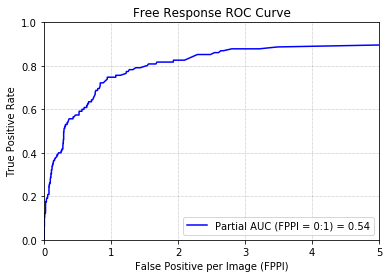

In [41]:
# Counts to adjust the TPR and to create the False Positive per Image
_, counts = np.unique(all_labels, return_counts=True)
num_img = 410
num_pos_img = 115
regions = all_labels.shape[0]
pos_reg = counts[1]
neg_reg = counts[0]
neg_reg_per_img = neg_reg / num_img

print(f"Negative regions per image {neg_reg_per_img}")
print(f"Number of positive images {num_pos_img}, number of positive regions {pos_reg}")

def get_roc(test_labels, out_probs):
    
    if (not isinstance(test_labels, list)) and (not isinstance(test_labels, tuple)):
        test_labels = (test_labels,)
    
    if (not isinstance(out_probs, list)) and (not isinstance(out_probs, tuple)):
        out_probs = (out_probs,)
        
    for i, labels_probs in enumerate(zip(test_labels, out_probs)):
        test_ls, out_prob = labels_probs
        fpr, tpr, _ = roc_curve(test_ls, out_prob[:,1], pos_label=1, drop_intermediate=True)
        roc_auc = auc(fpr, tpr)
        
        fpr = fpr * neg_reg_per_img
        tpr = tpr * pos_reg / num_pos_img
        
        # Calculates Partial AUC
        partial_auc = partial_auc_scorer(fpr, tpr, 1)
        
#         plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}, ROC #{i+1}')
        plt.plot(fpr, tpr, 'b',label='Partial AUC (FPPI = 0:1) = %0.2f'% partial_auc)
        plt.legend(loc='lower right')

    plt.title('Free Response ROC Curve')
    plt.xlim([-0,5])
    plt.ylim([-0,1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive per Image (FPPI)')
    plt.grid(color='k', linestyle='dotted', linewidth=0.5, alpha=0.5)
    plt.show()


get_roc(all_labels, prob)

## Example of saving classifier to the disk and loading it back

Let's save our classifier

In [41]:
import pickle

# save the classifier
with open("./models/rf_classifier.pkl", "wb") as fid:
    pickle.dump(clf, fid)    

Now we will load classifier and test it again

In [46]:
# load it again
with open("./models/rf_classifier.pkl", "rb") as fid:
    rf_classifier_loaded = pickle.load(fid)
    
# let's test performance on the initial data
print(f"Length of test data {len(X_all)}")
print(f"Number of masses in the test data {len(x_test_all)}")

predictions_loaded = rf_classifier_loaded.predict(x_test_all)
print(f"Detected percentage of masses {accuracy_score(y_test_all, predictions_loaded)}")

Length of test data 4273
Number of masses in the test data 114
Detected percentage of masses 0.7719298245614035
